In [41]:
"""
This notebook contains soliton wavelength estimations at a few different
temperatures.
""";

In [35]:
"""
The script that does the heavy lifting per temperature.
"""

import importlib

import numpy as np

import parsing_utils as utils
import ccd_image as ccd
import cluster

importlib.reload(utils)
importlib.reload(ccd)
importlib.reload(cluster)


# max_field = 100
# scan_dir = "/Users/richard/Data/i10/CSL_Feb_2022/15K/687765-pixis-files/"

# max_field = 100
# scan_dir = "/Users/richard/Data/i10/CSL_Feb_2022/50K/687750-pixis-files/"

# max_field = 77
# scan_dir = "/Users/richard/Data/i10/CSL_Feb_2022/100K/687736-pixis-files/"

# max_field = 81
# scan_dir = "/Users/richard/Data/i10/CSL_Feb_2022/150K/ordered/"

# max_field = 70
# scan_dir = "/Users/richard/Data/i10/CSL_Feb_2022/200K_IP/687702-pixis-files/"

# max_field = 141
# scan_dir = "/Users/richard/Data/i10/CSL_Feb_2022/200K_OOP/ordered/"

# max_field = 60
# scan_dir = "/Users/richard/Data/i10/CSL_Feb_2022/250K/ordered/"

max_field = 60
scan_dir = "/Users/richard/Data/i10/CSL_Feb_2022/300K/ordered"

clusters_per_field = []
bkg_in_clusters_per_field = [
    np.zeros_like(utils.get_rough_background(utils.SCAN_DIRS_20K[0], True))
    for _ in range(max_field)
]

for field in range(max_field):
    print(f"Field: {field} mT", end='\r')
    # First subtract the background and add the bkg subbed data to the
    # averaged_total_bkg_subbed_images array.
    tiff = utils.get_tiff(scan_dir, field)
    bkg = utils.get_tiff(scan_dir, max_field)
    img = ccd.CCDImage(tiff, bkg, utils.MASK, utils.METADATA)
    img.subtract_bkg()
    bkg_subbed_data = np.copy(img.data)

    # Now do clustering.
    clusters = img.cluster_significant_pixels(utils.SIGNAL_LENGTH_SCALE,
                                                utils.BKG_LENGTH_SCALE, 2)

    # Save the clusters, so I don't have to keep redoing this calculation.
    clusters_per_field.append(clusters)
    cluster_mask = img.mask_from_clusters(clusters)

    # Only look at bkg_subbed_data that's clustered and significant.
    bkg_in_clusters = bkg_subbed_data * cluster_mask
    bkg_in_clusters_per_field[field] += bkg_in_clusters


/Users/richard/Documents/Code/work/i10_experiments/soliton_experiment/parsing_utils.py:221: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/richard/Documents/Code/work/i10_experiments/soliton_experiment/parsing_utils.py:214: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


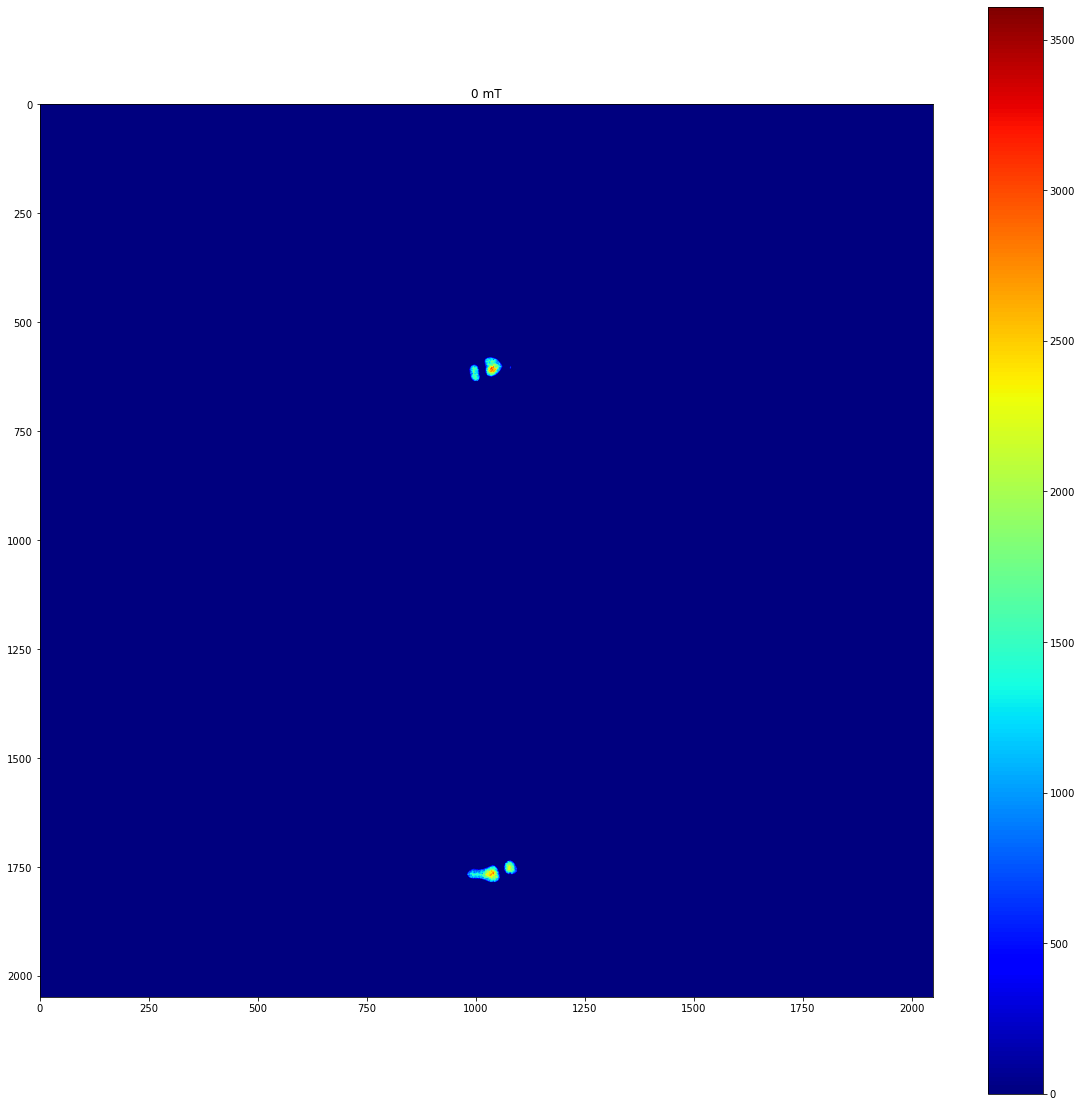

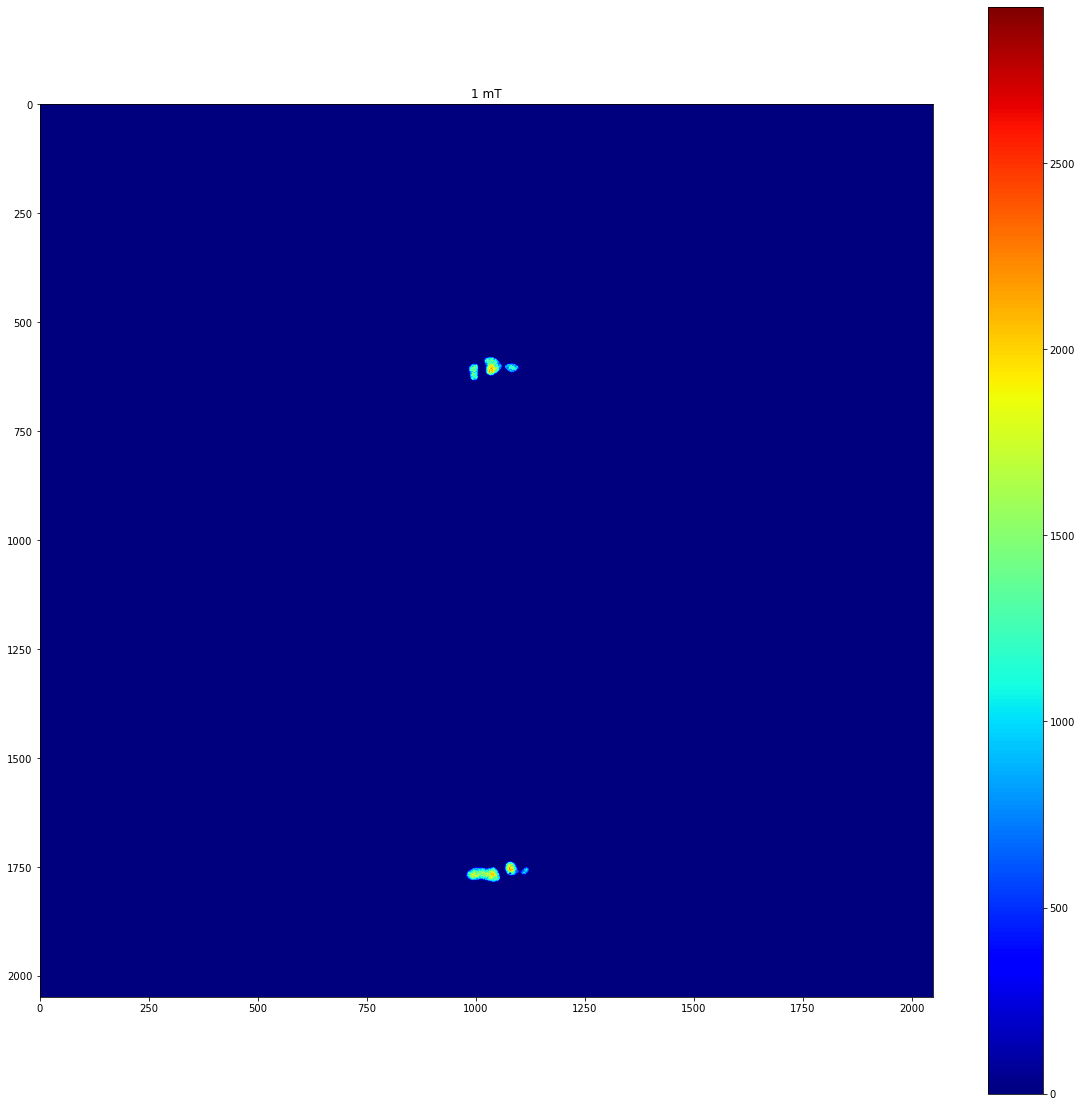

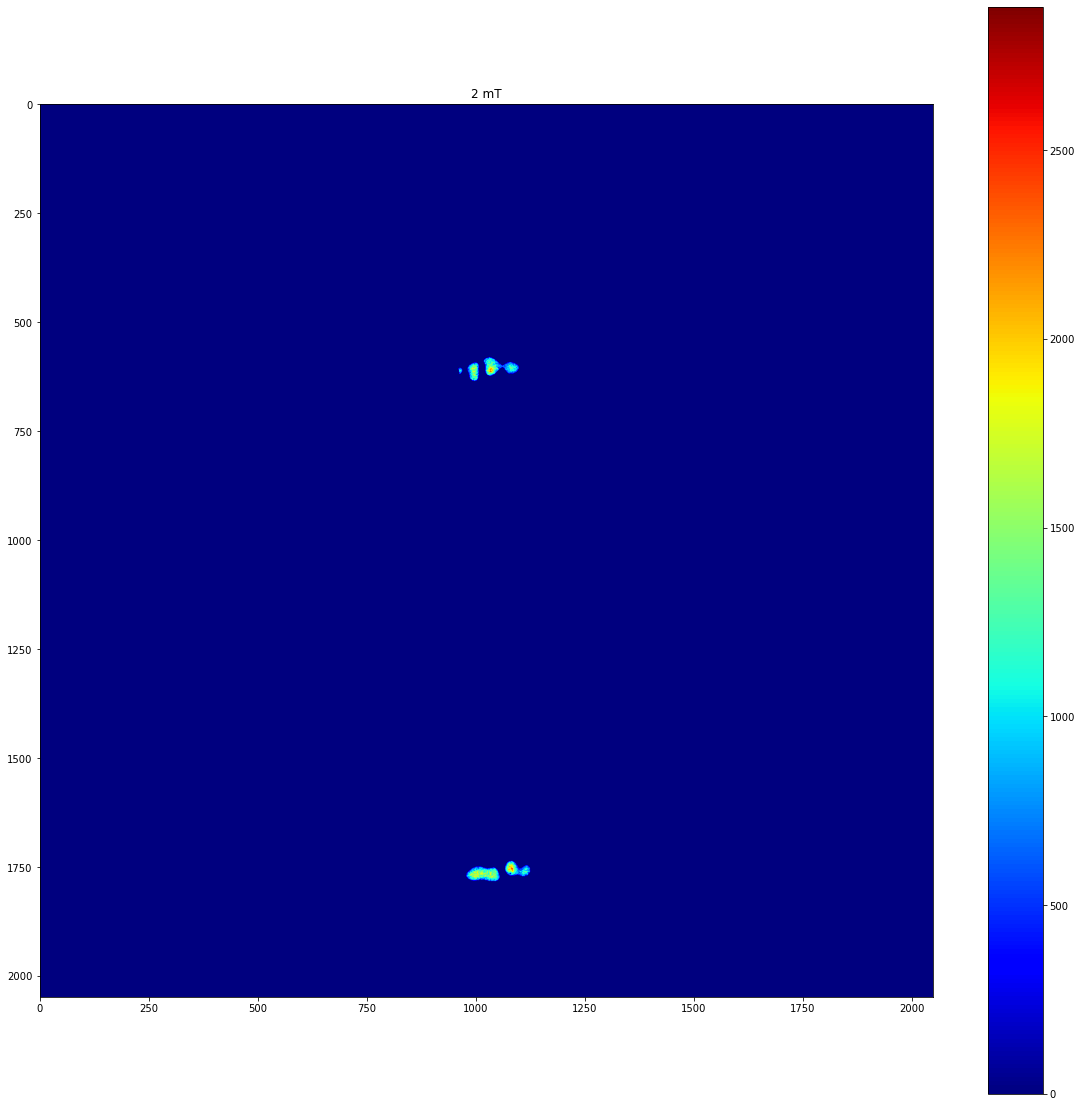

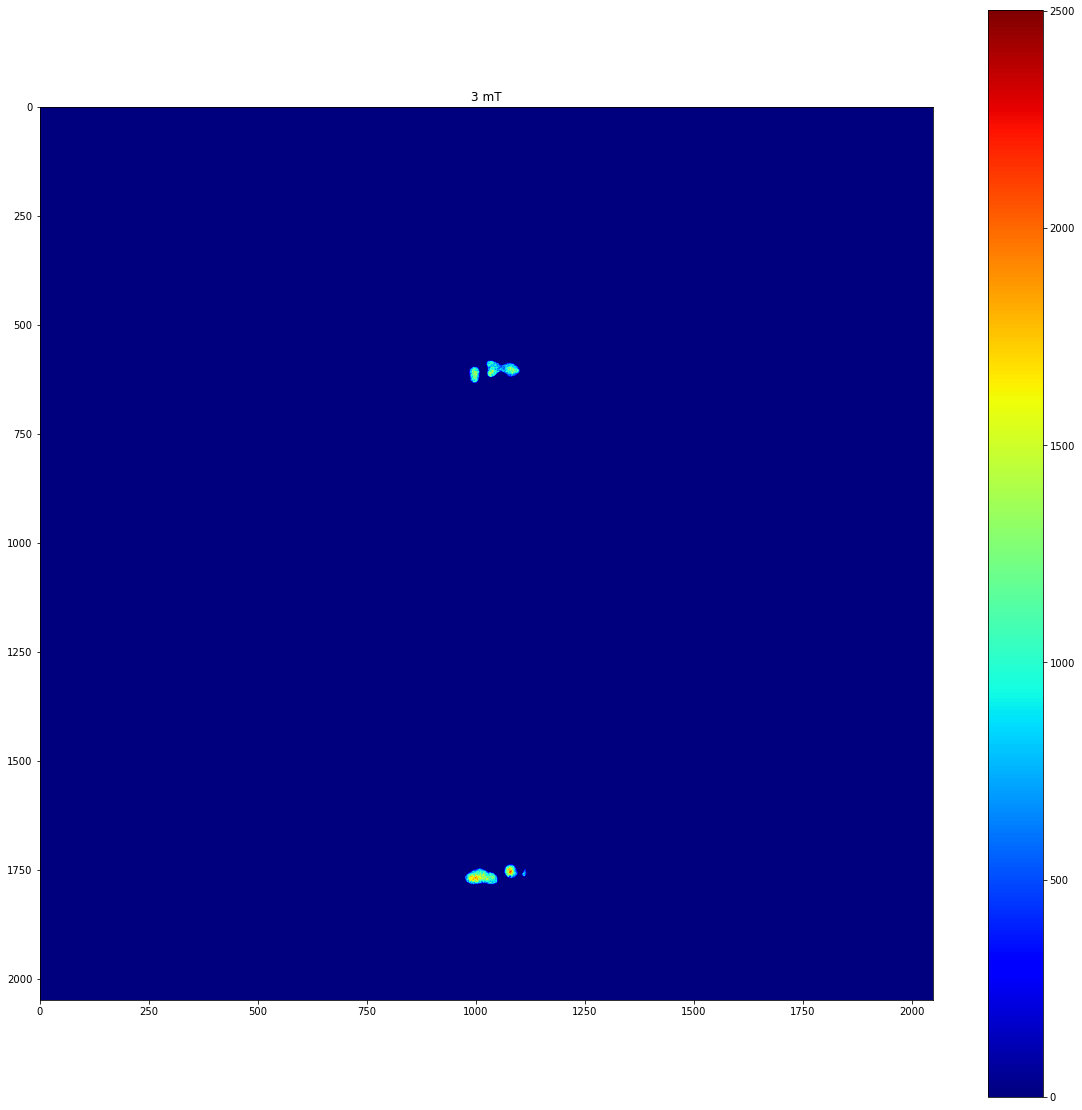

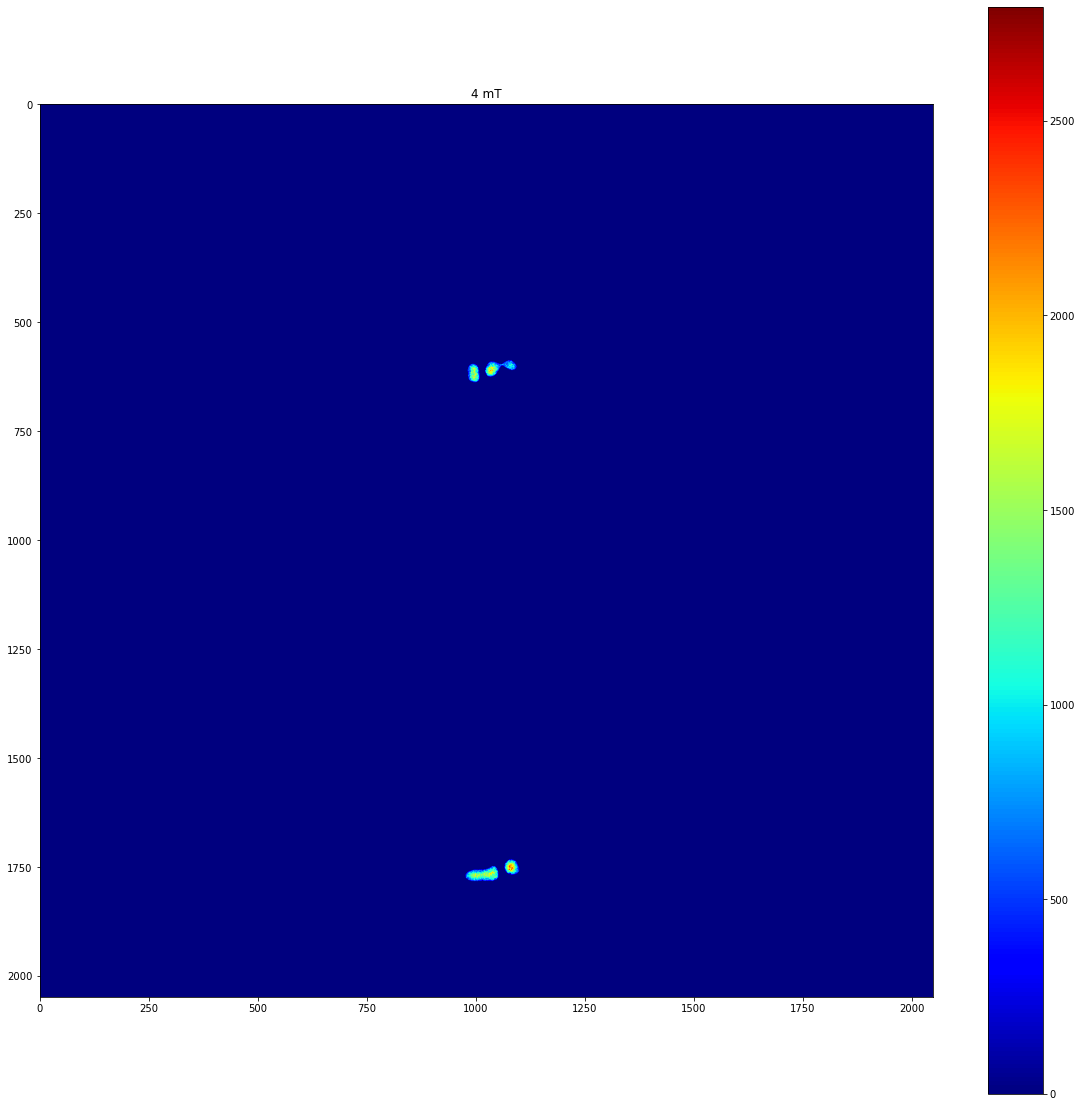

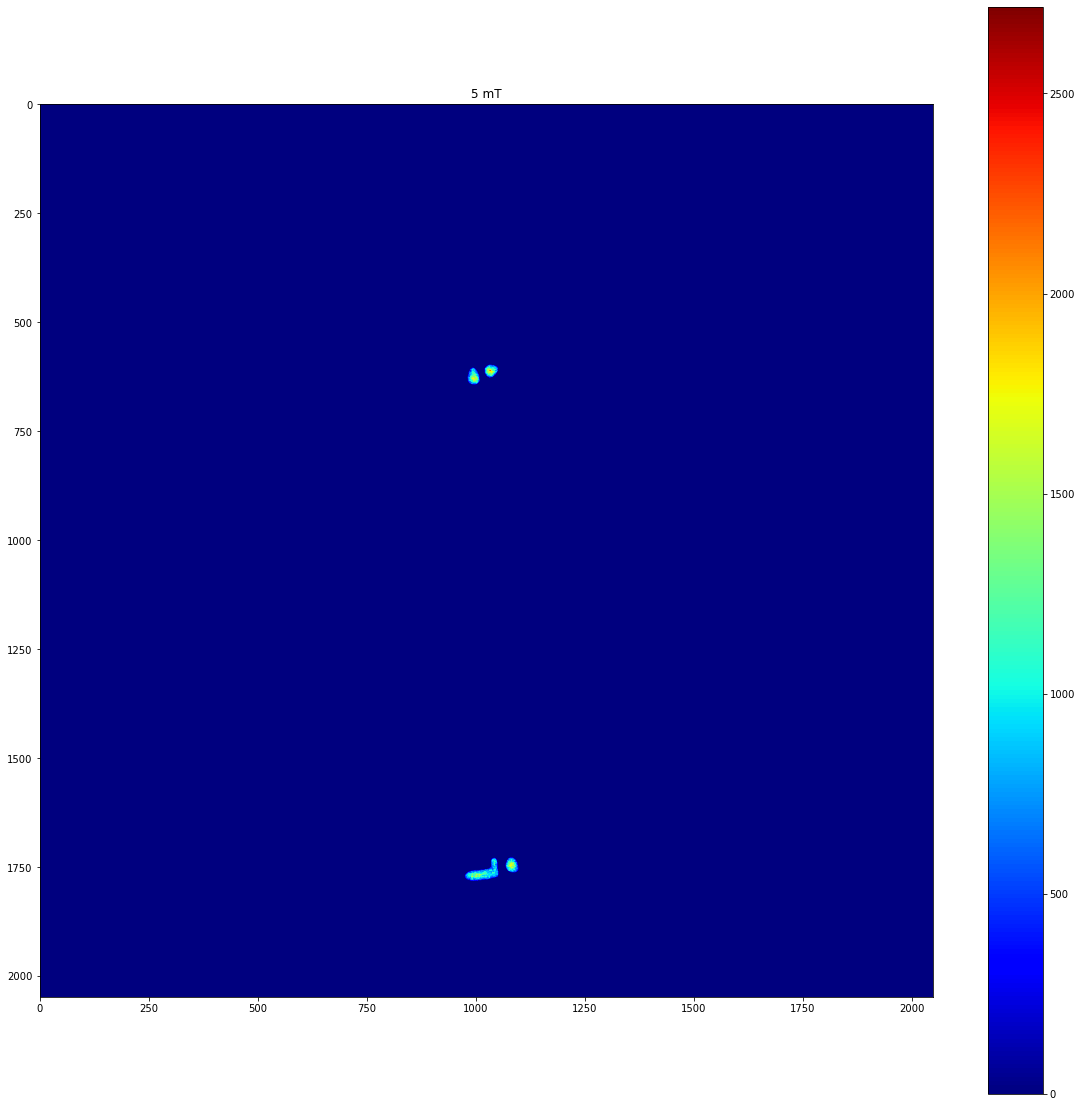

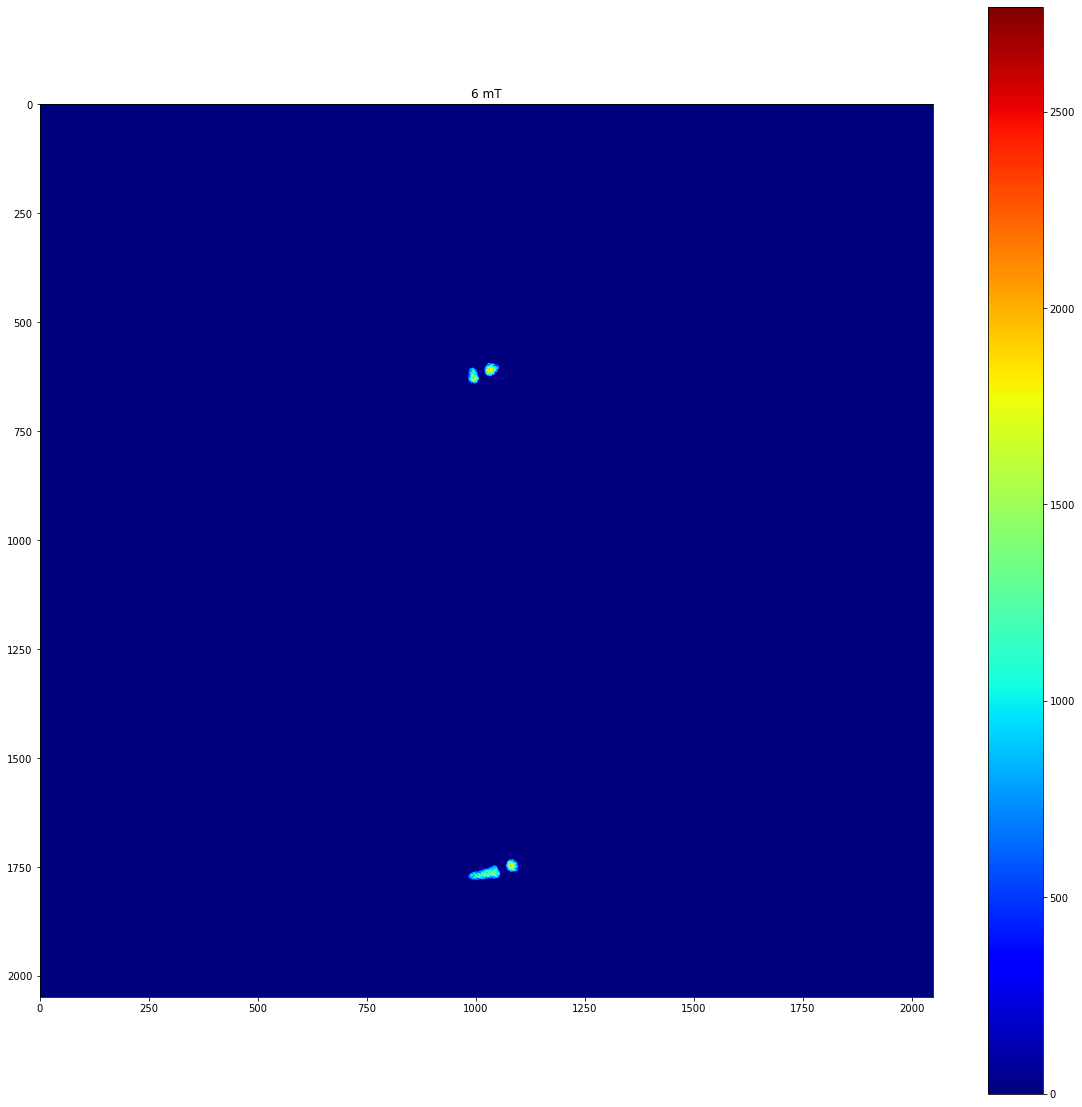

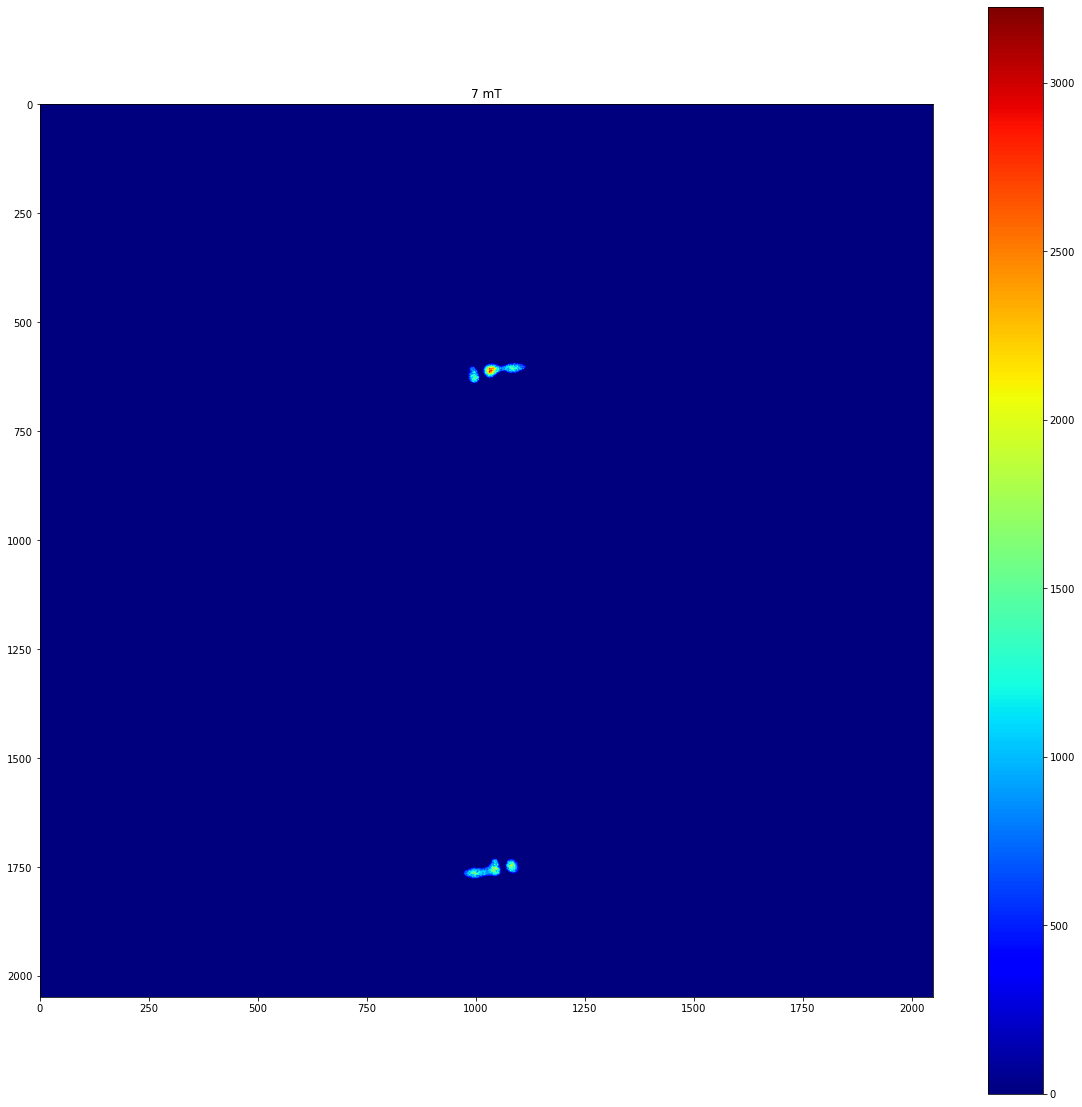

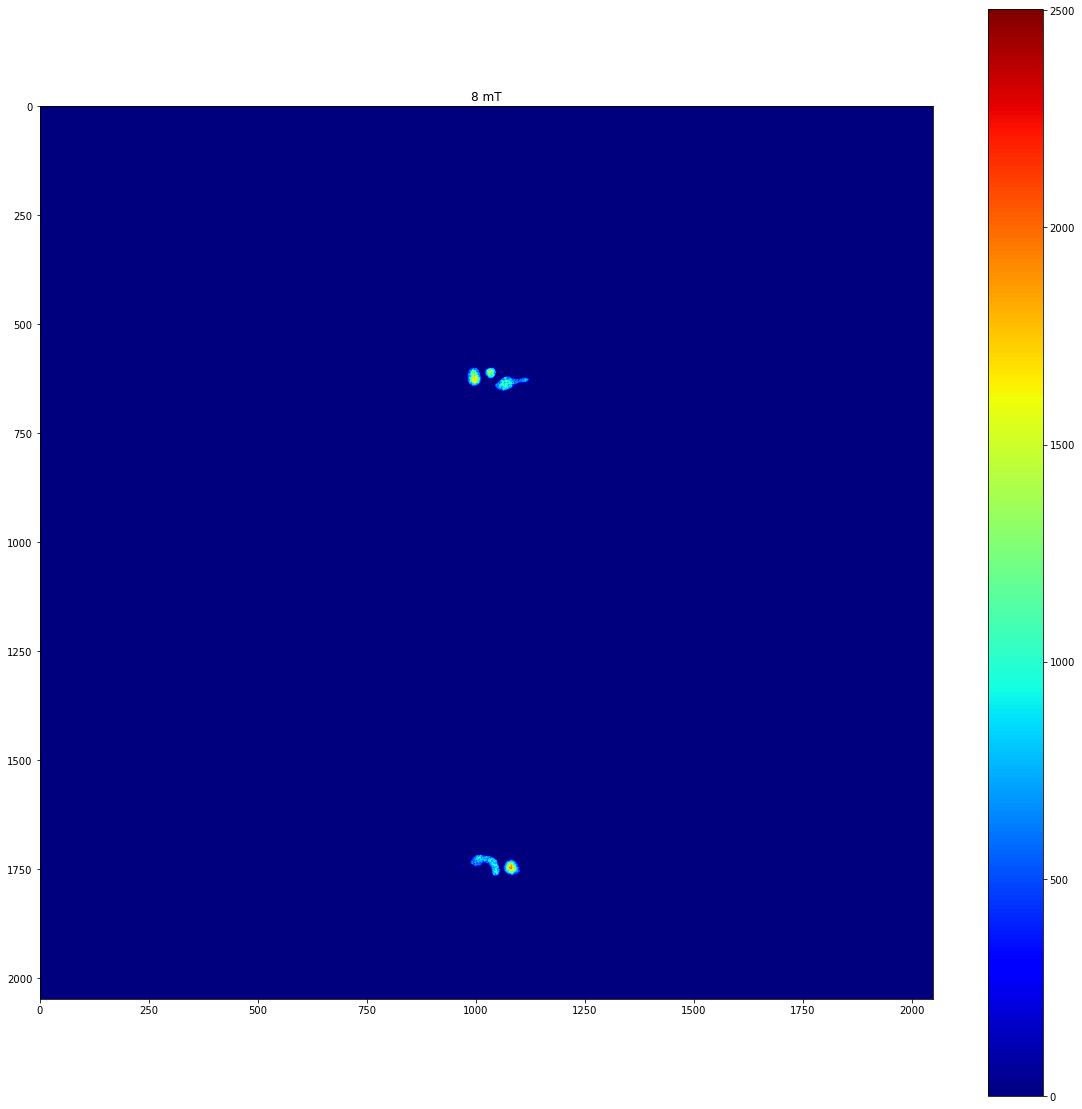

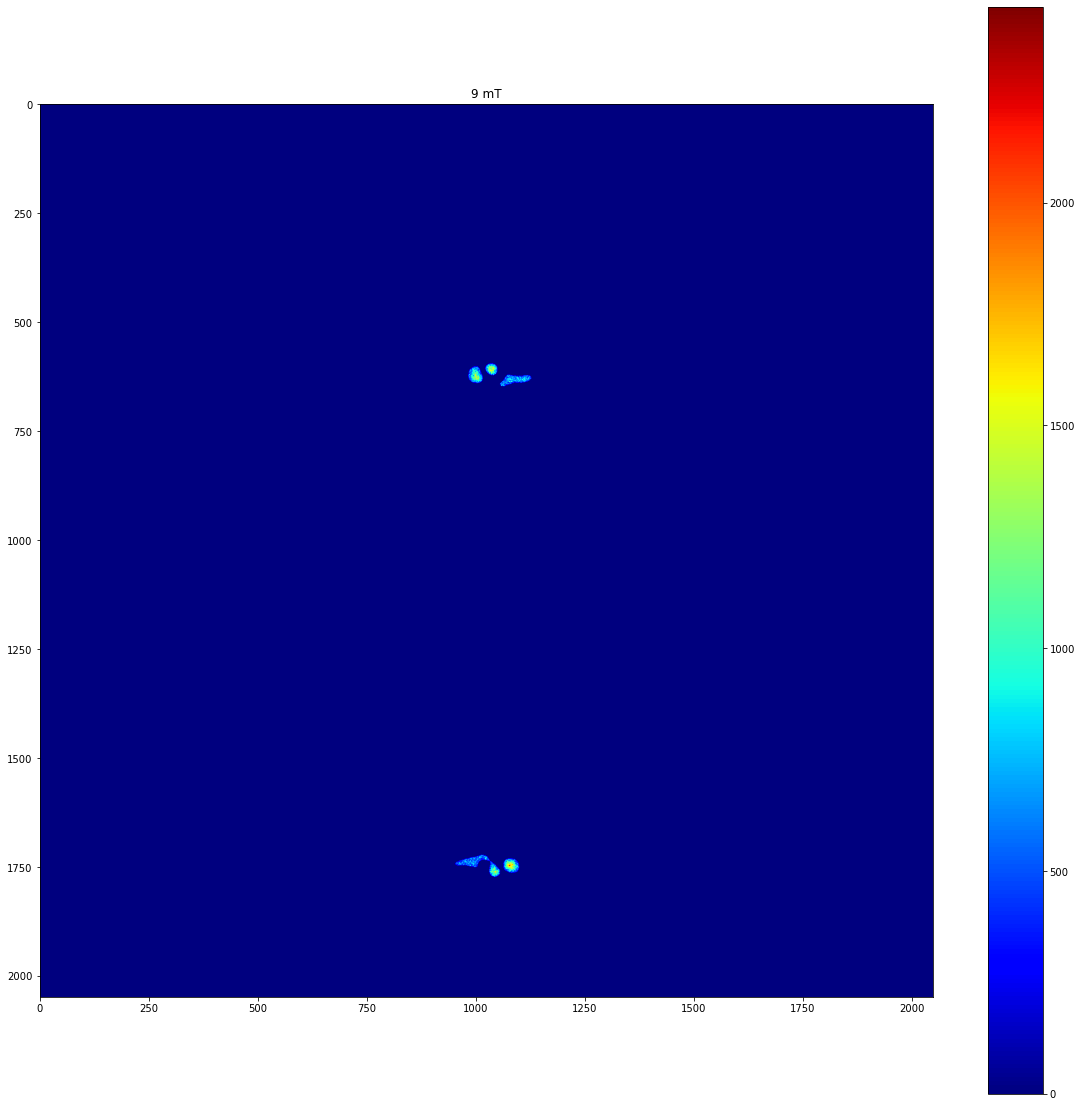

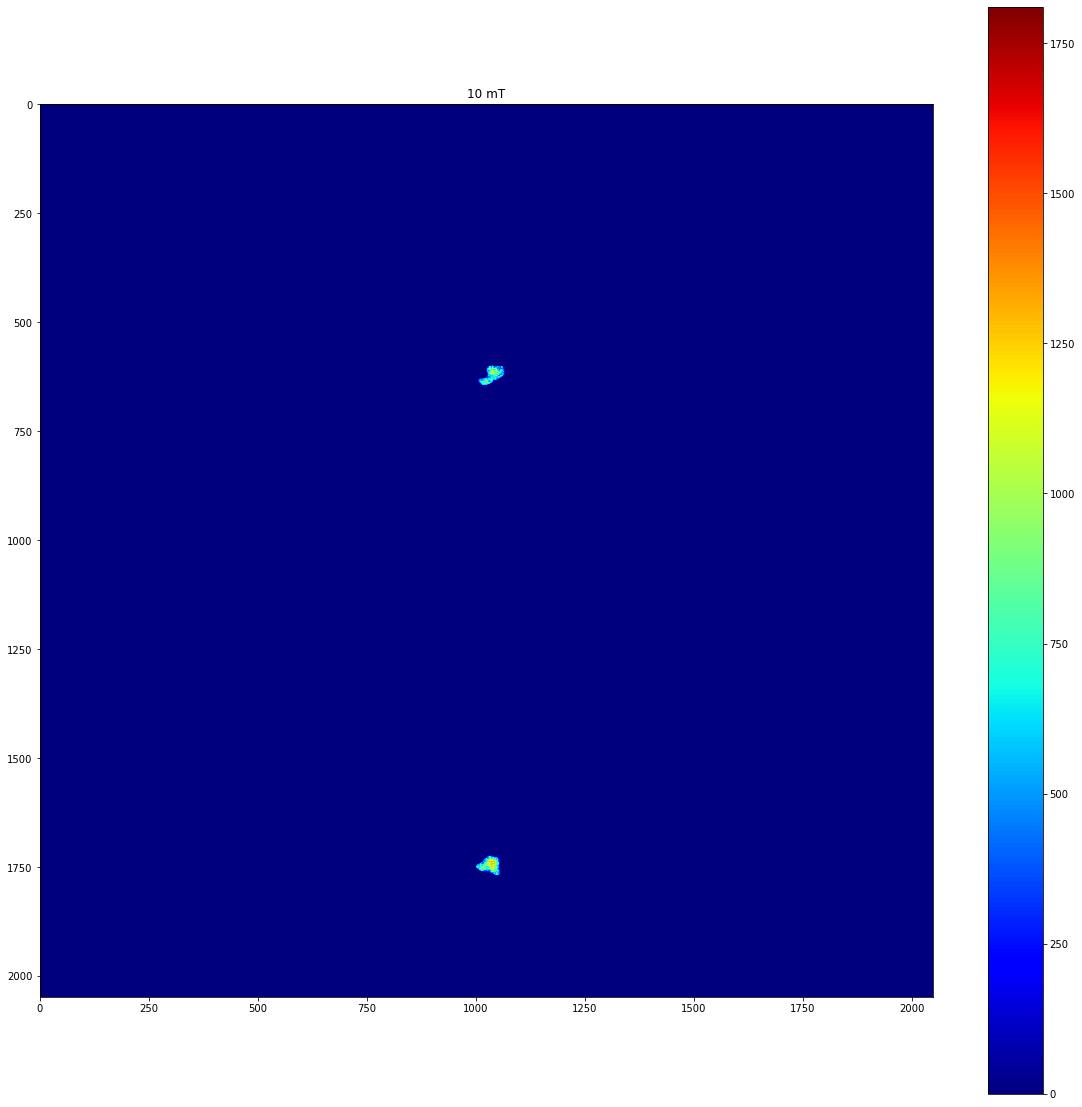

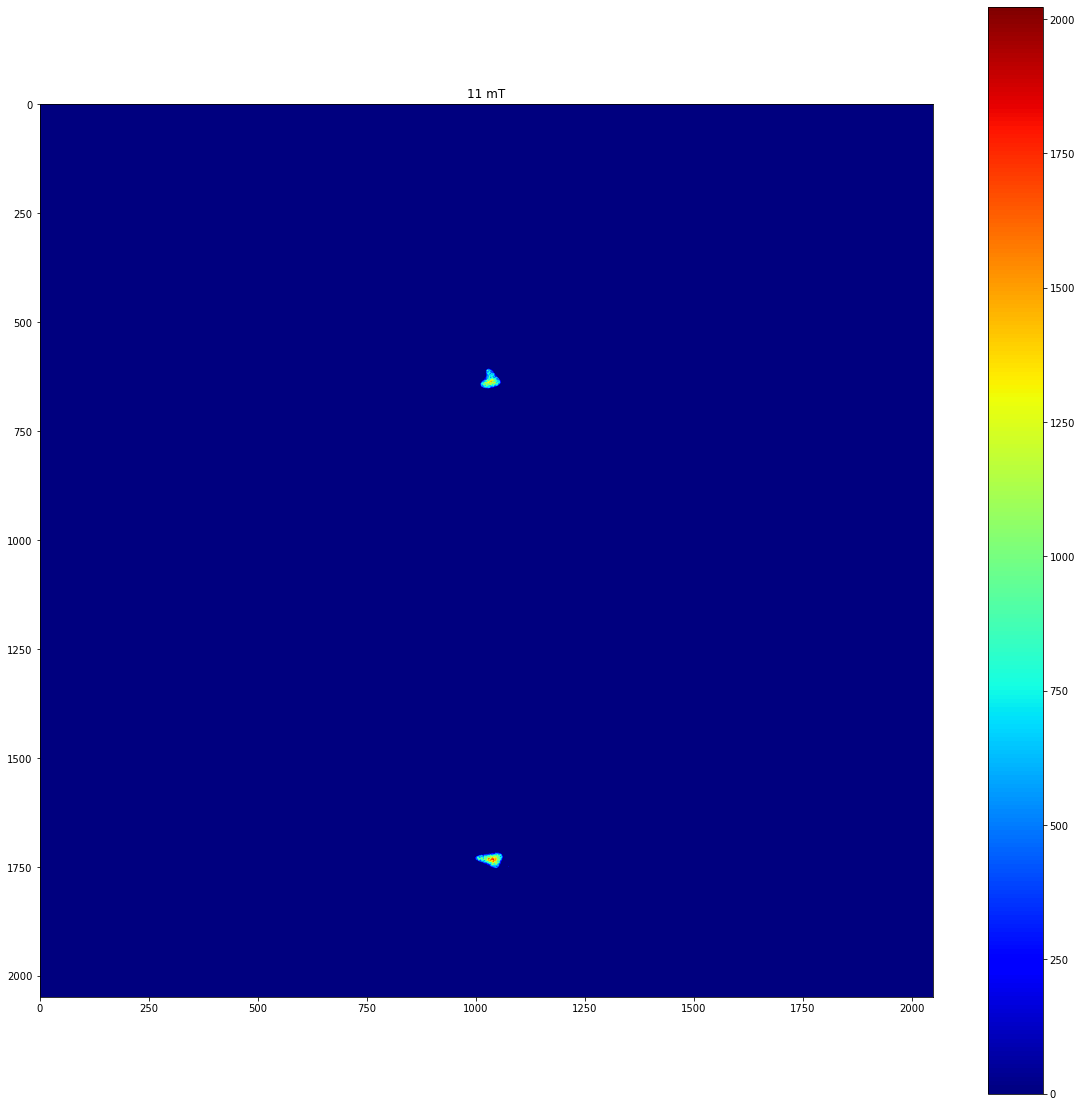

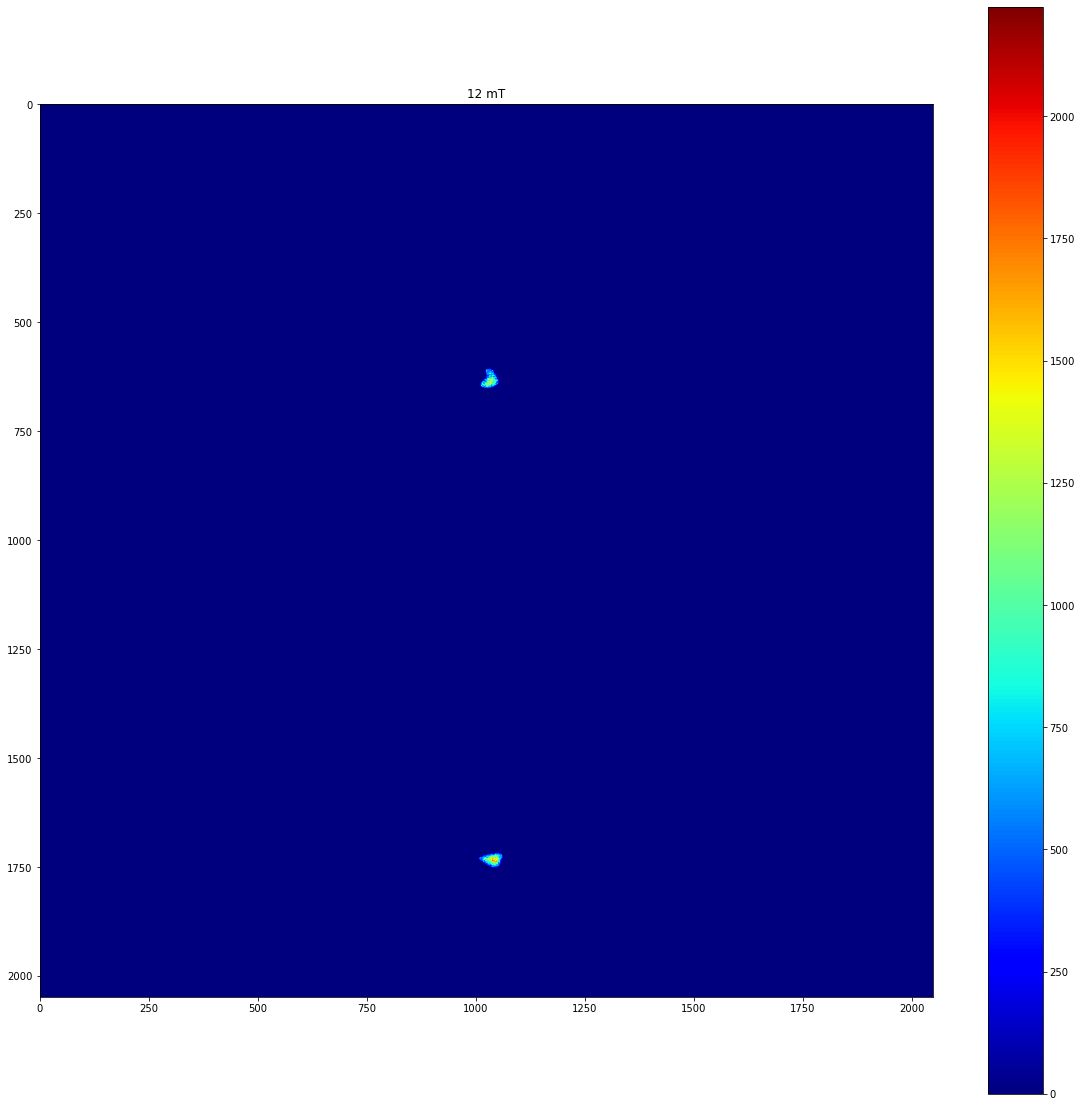

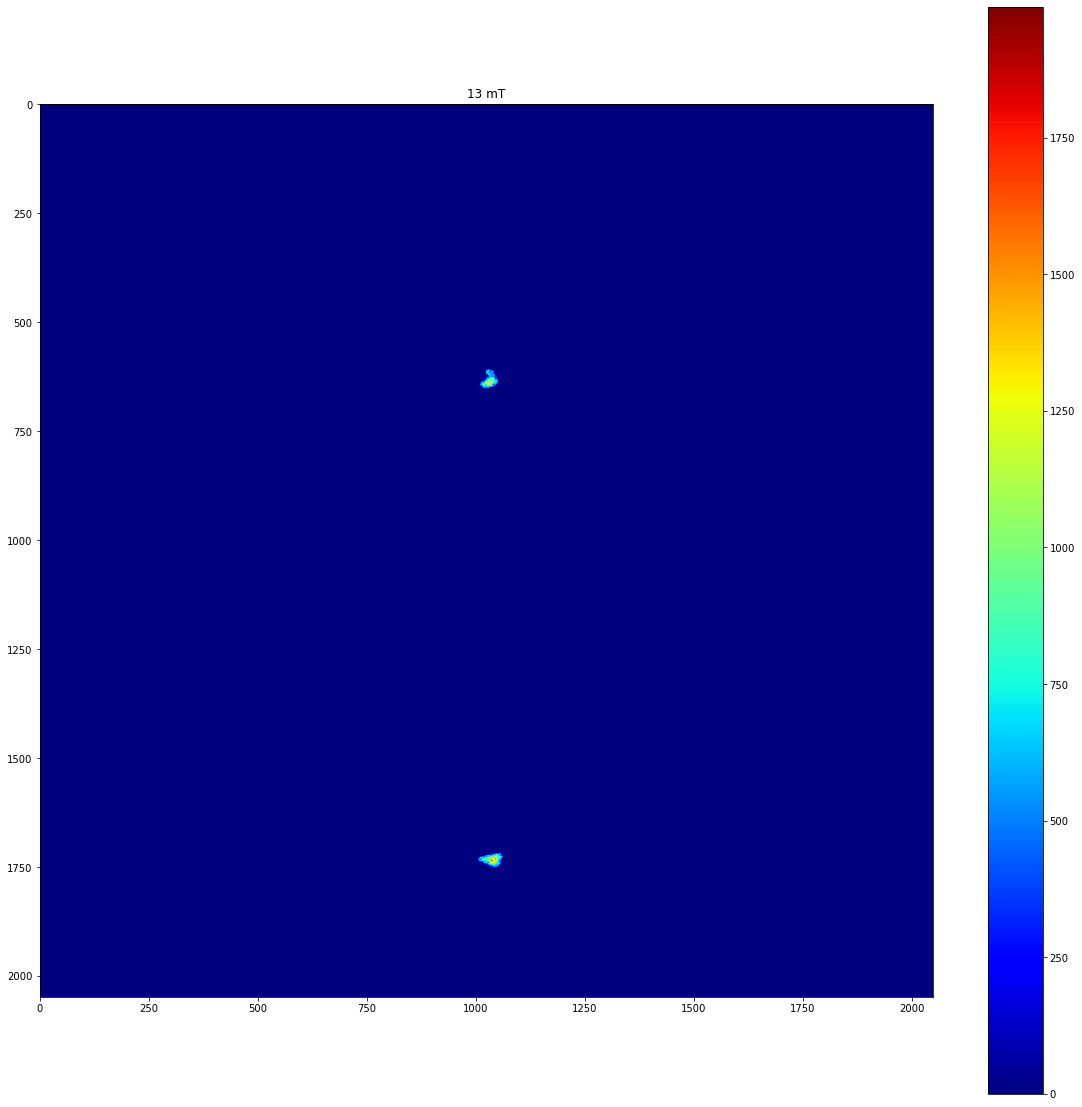

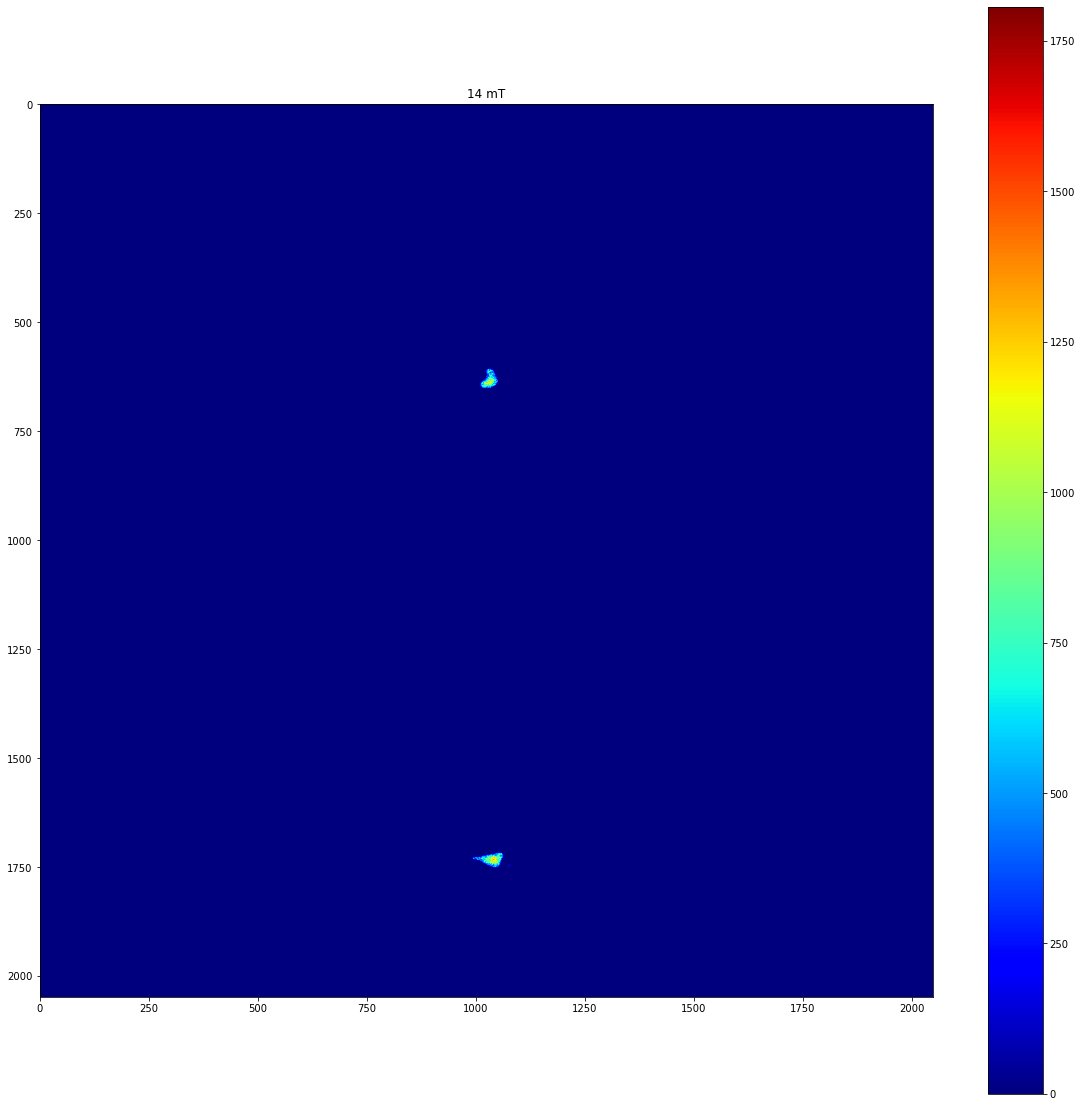

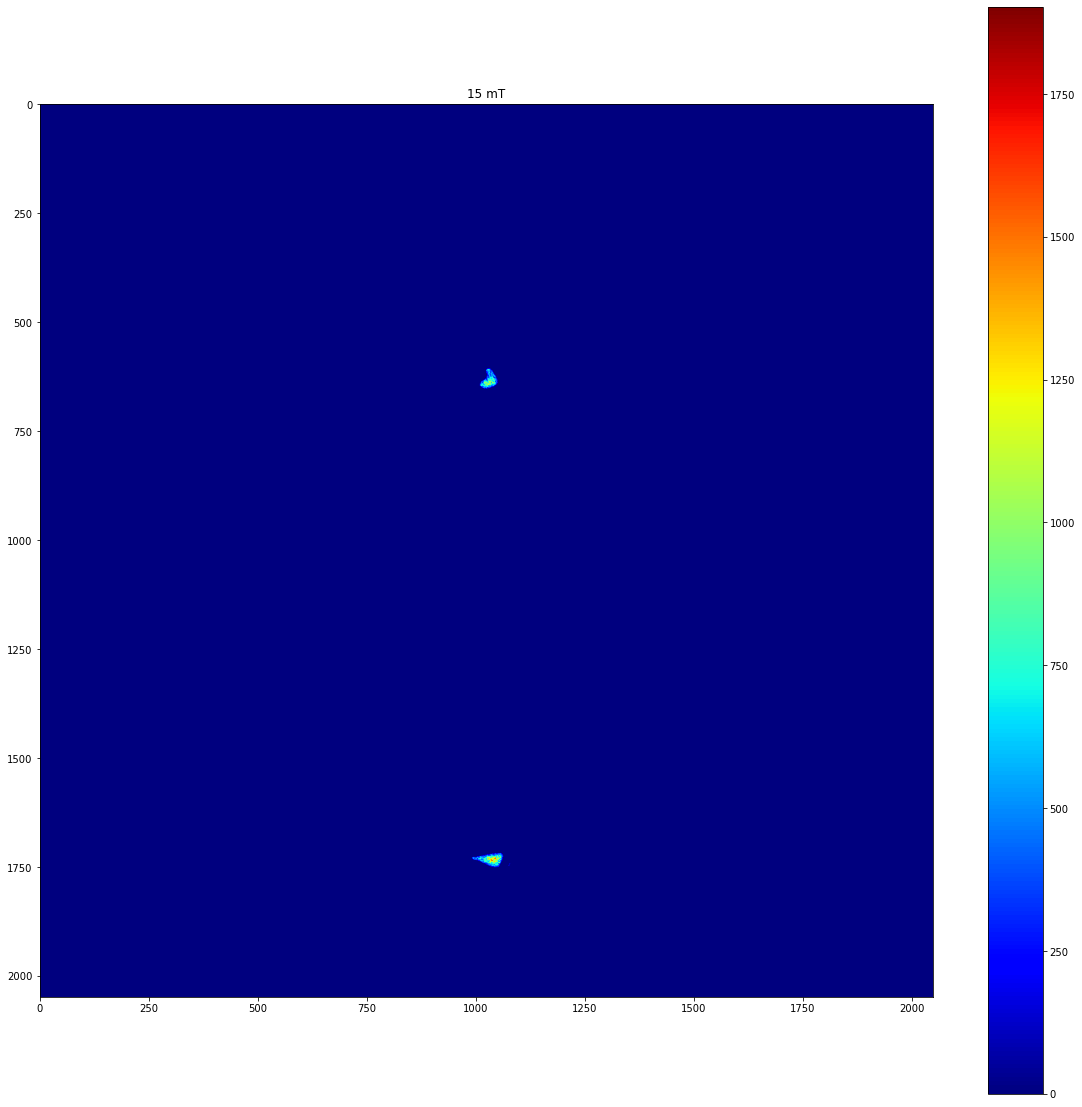

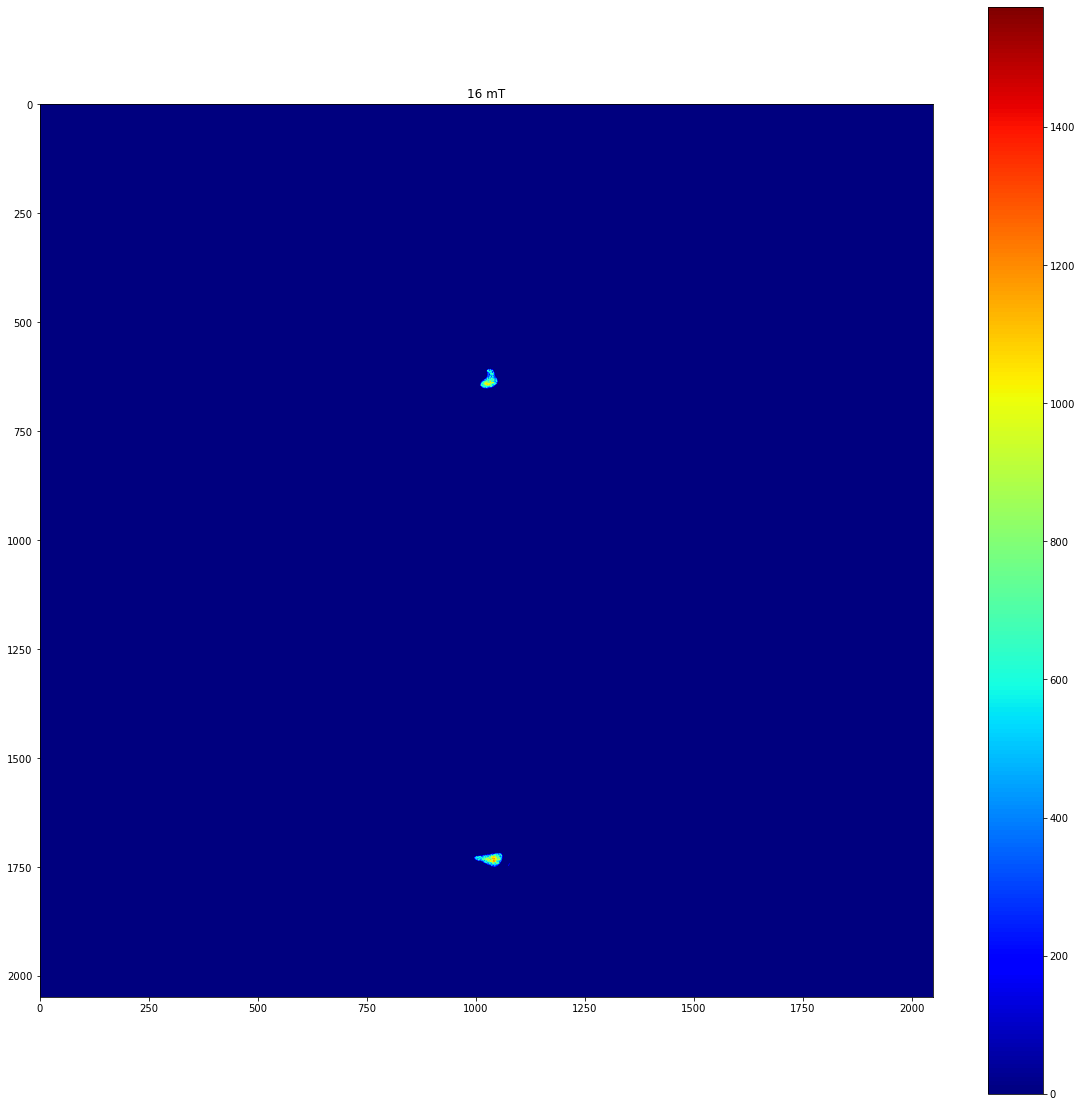

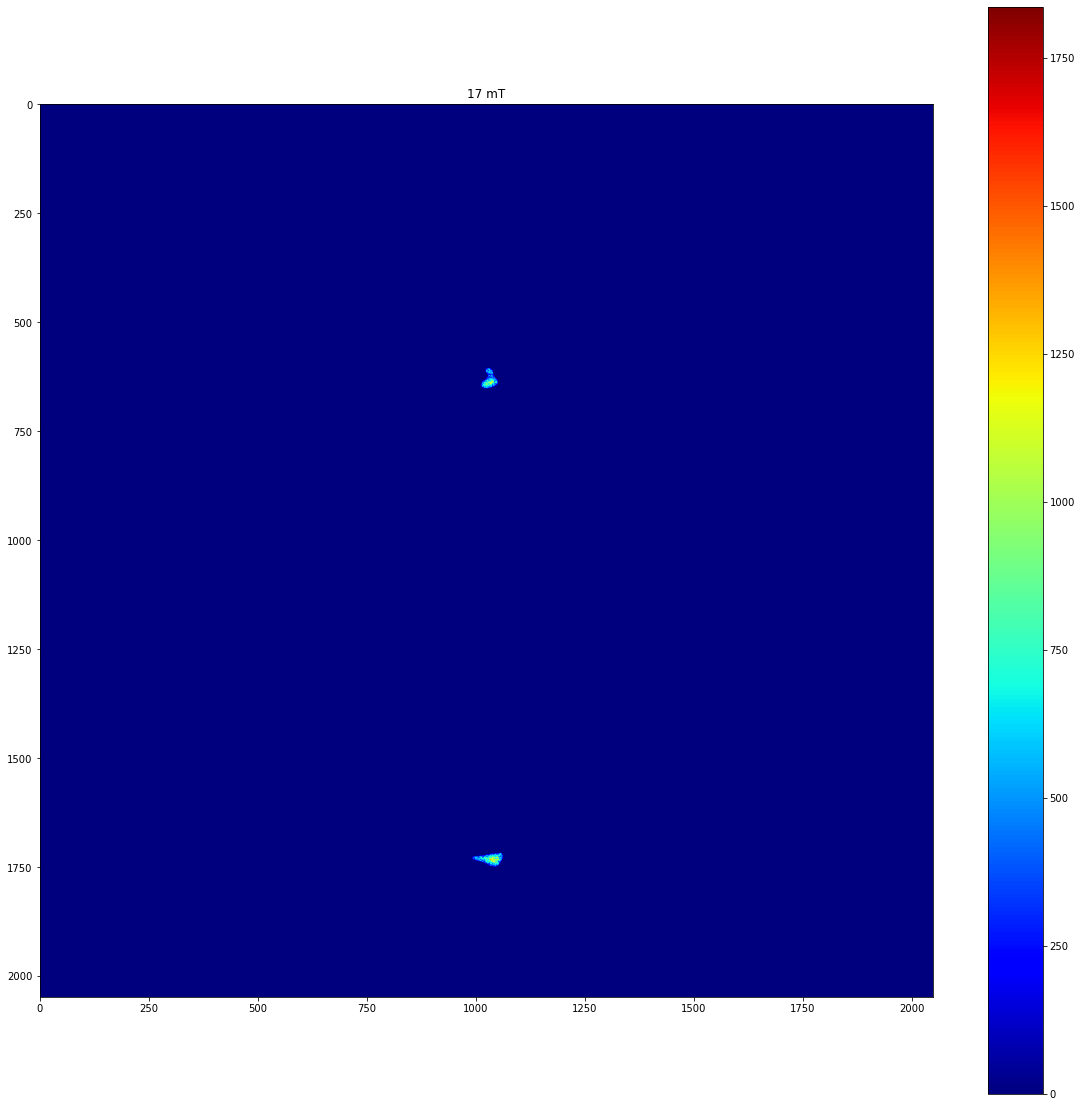

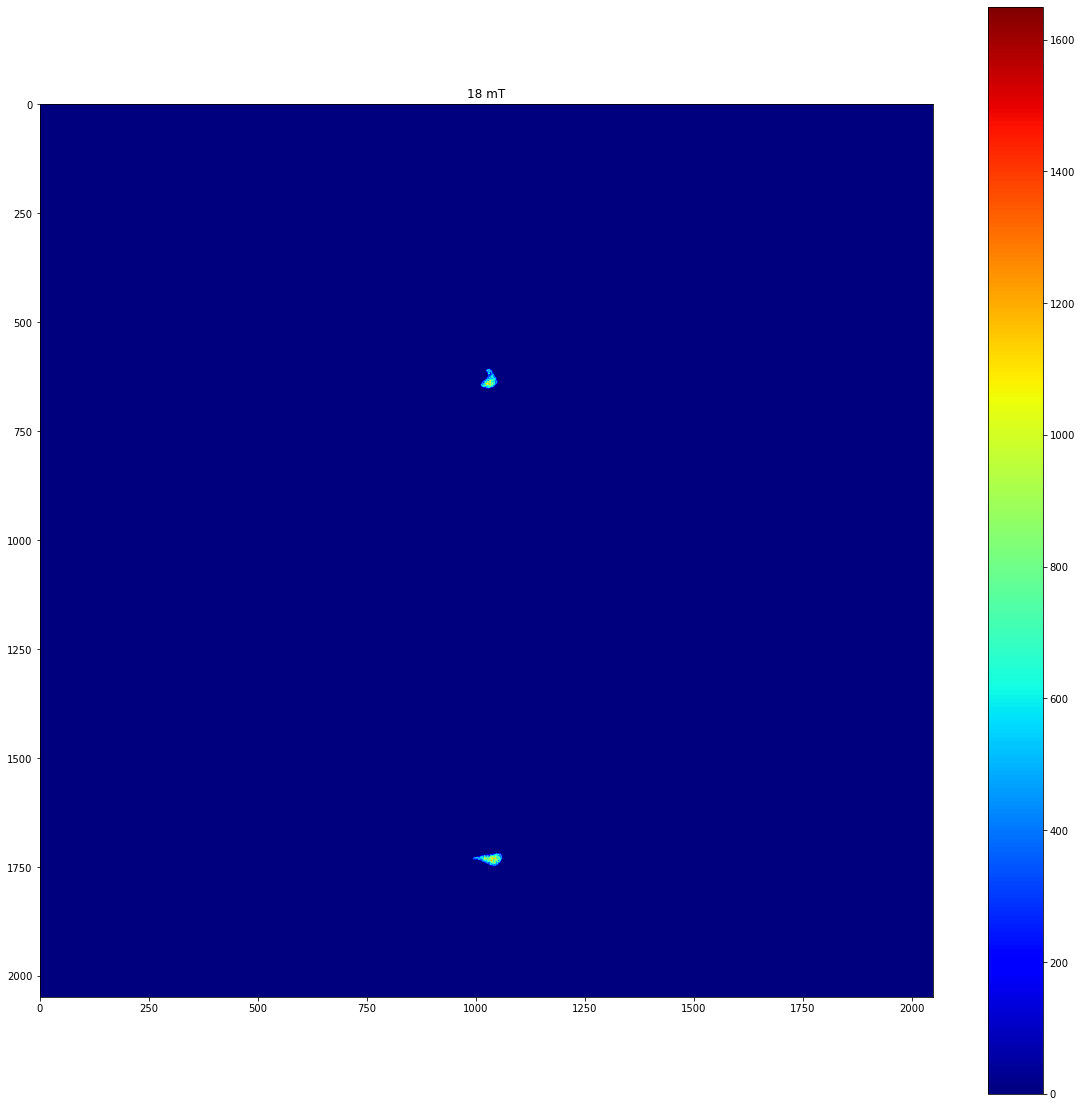

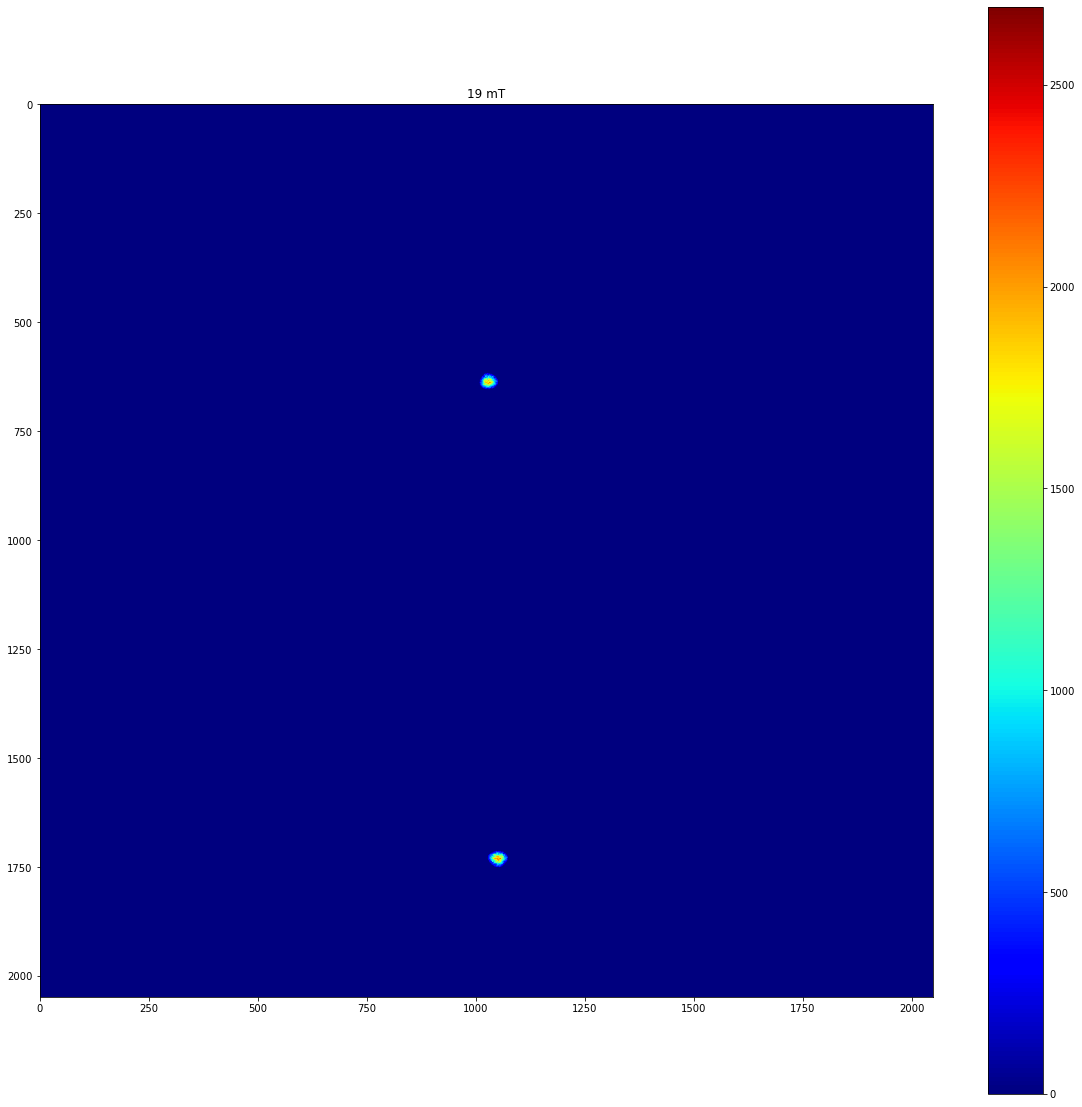

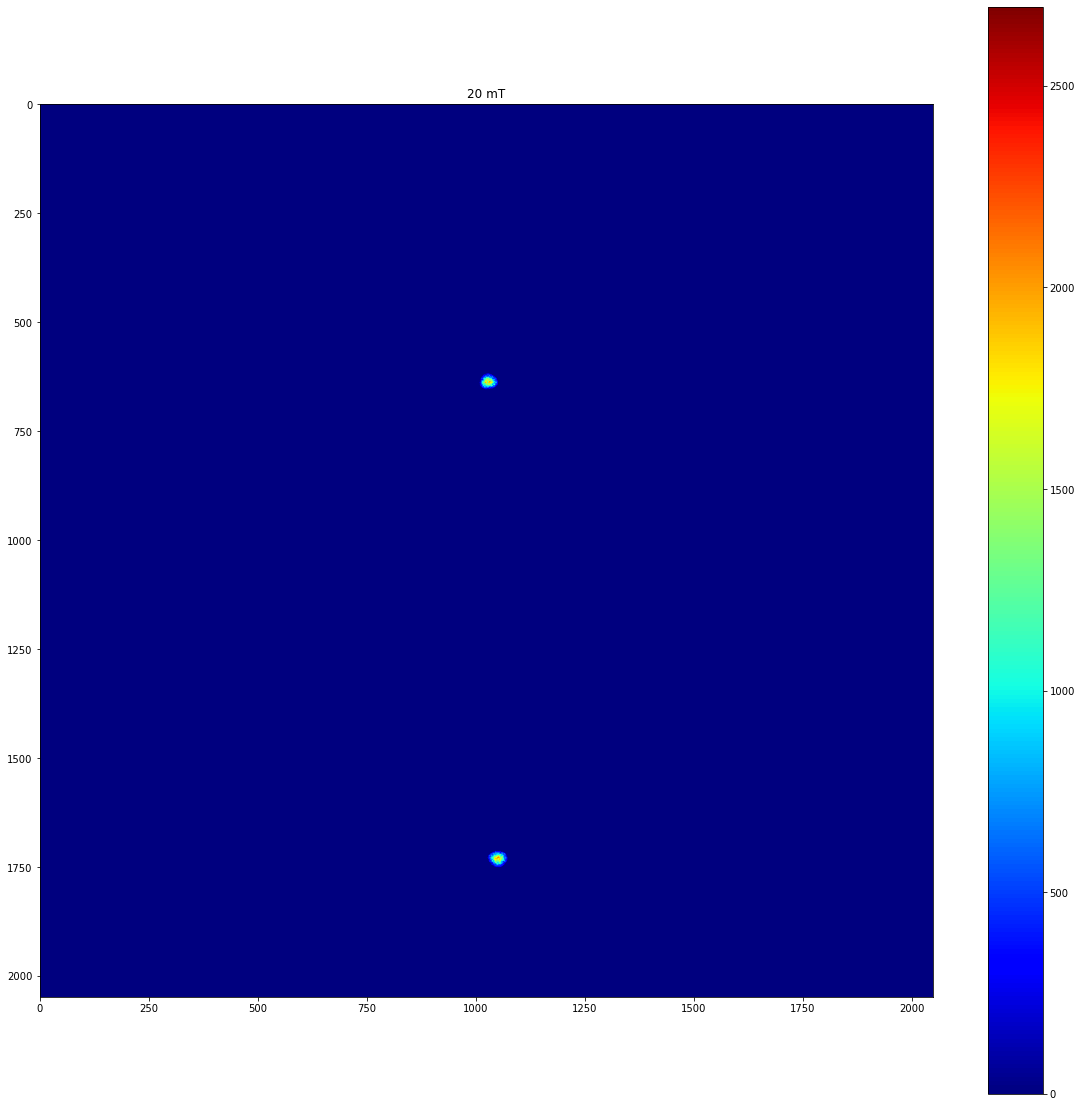

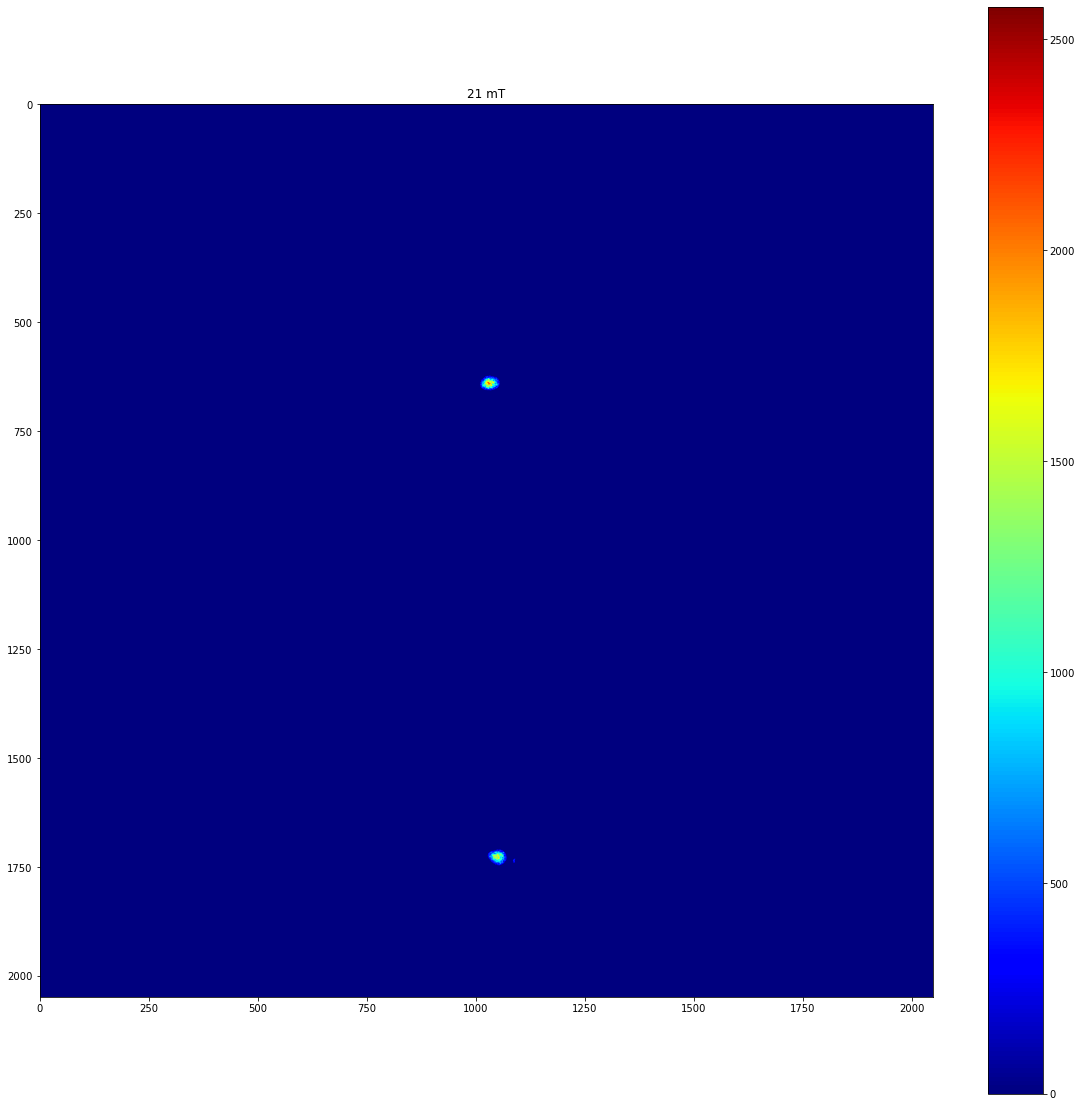

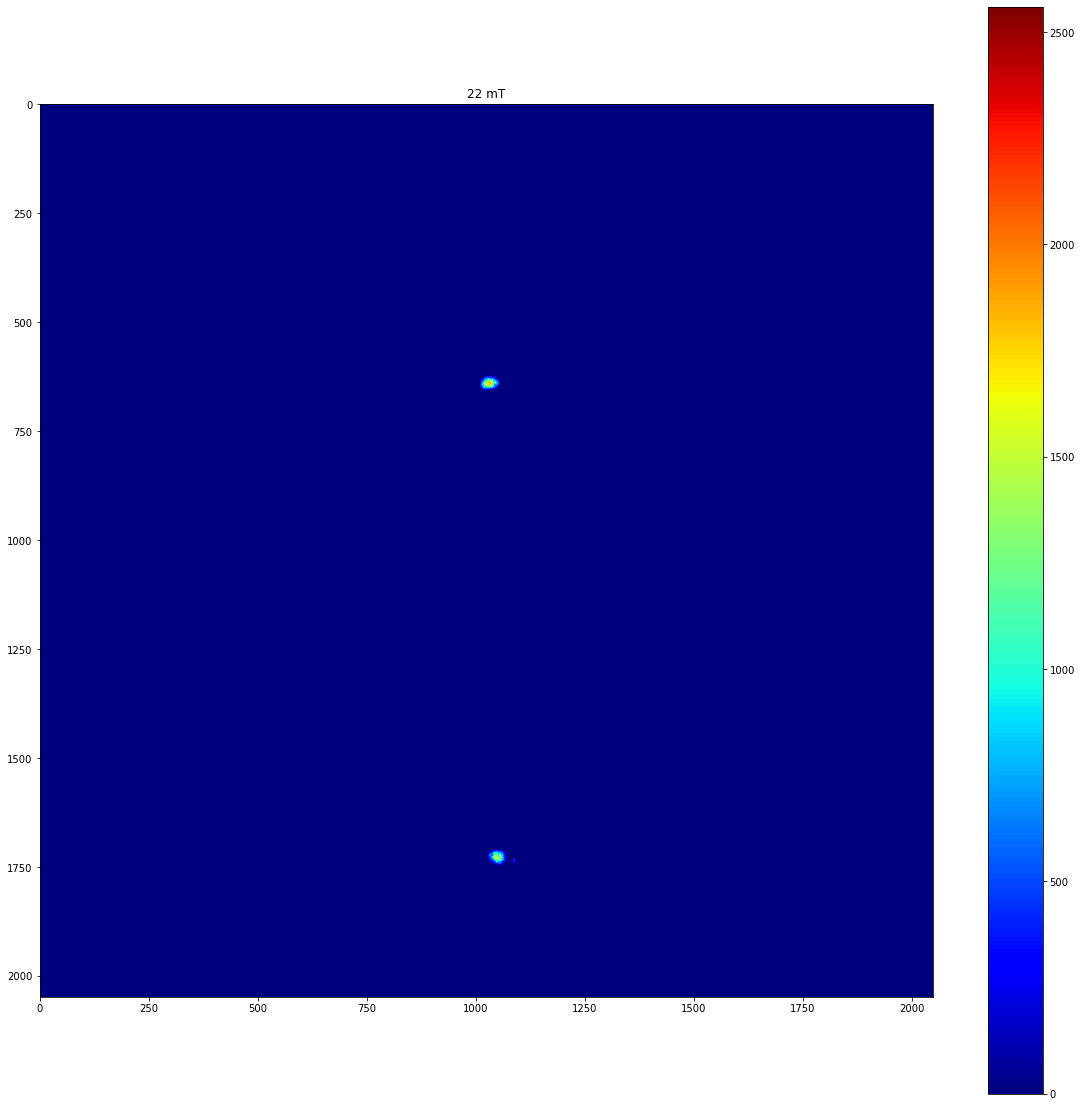

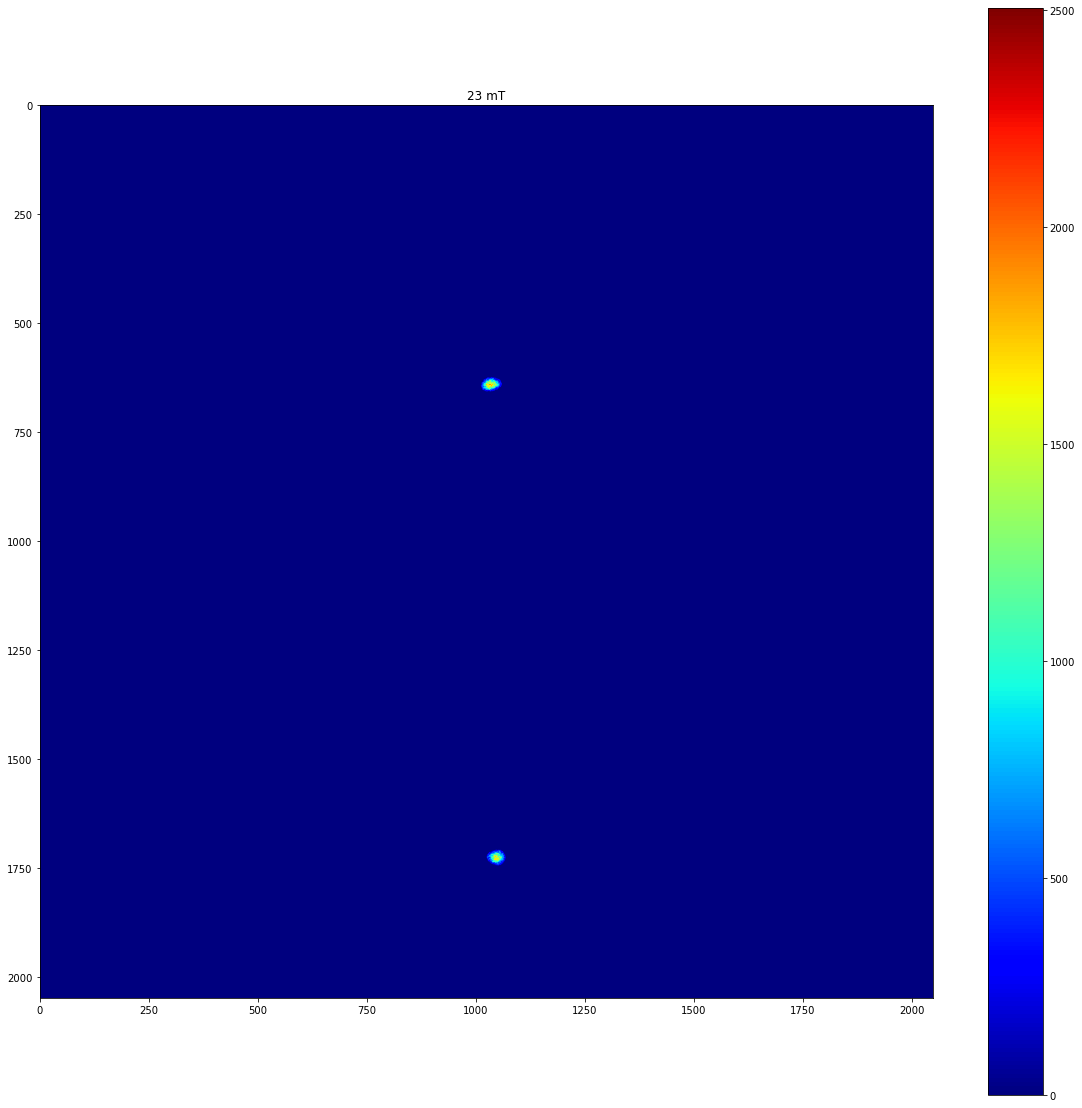

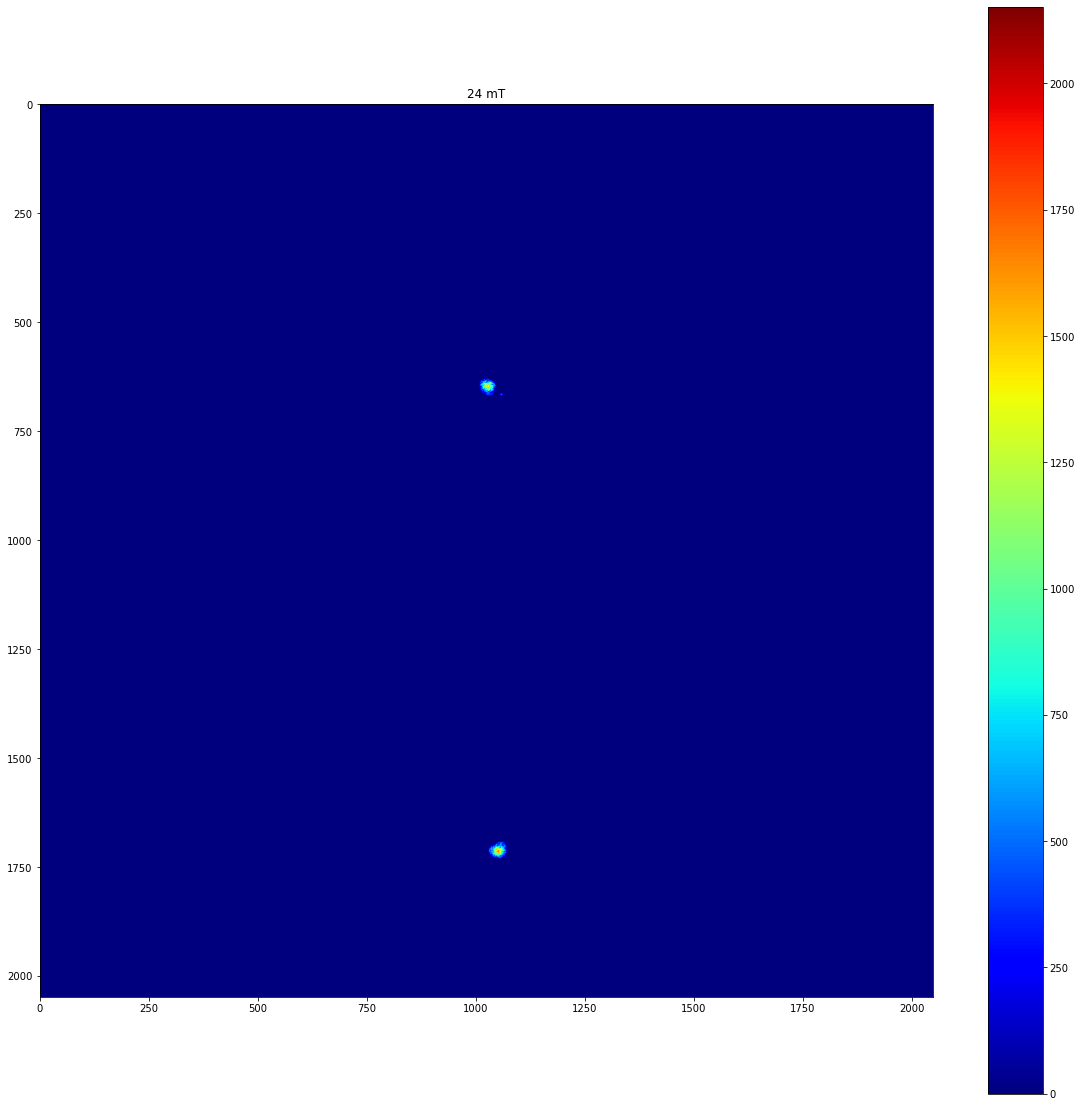

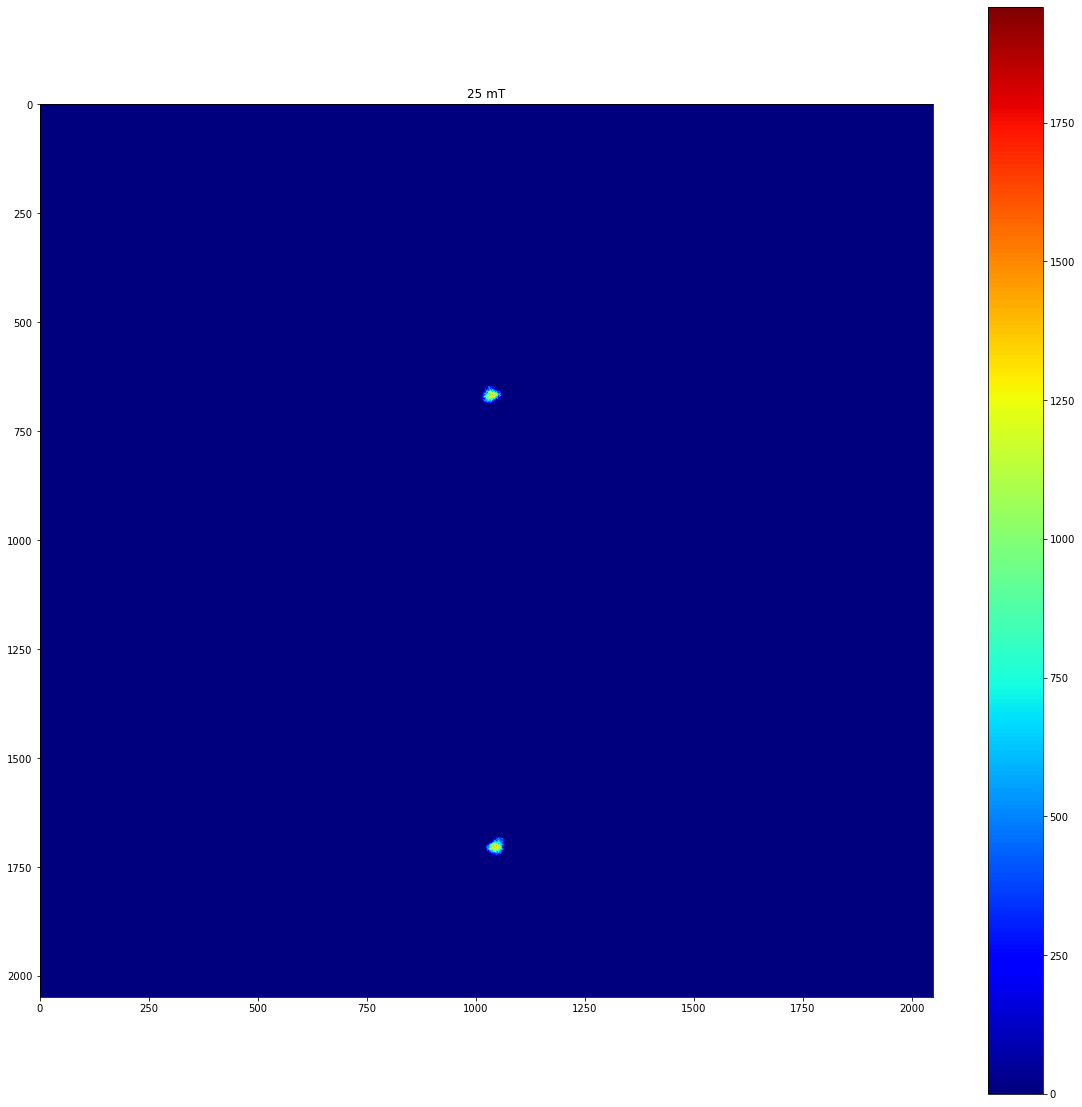

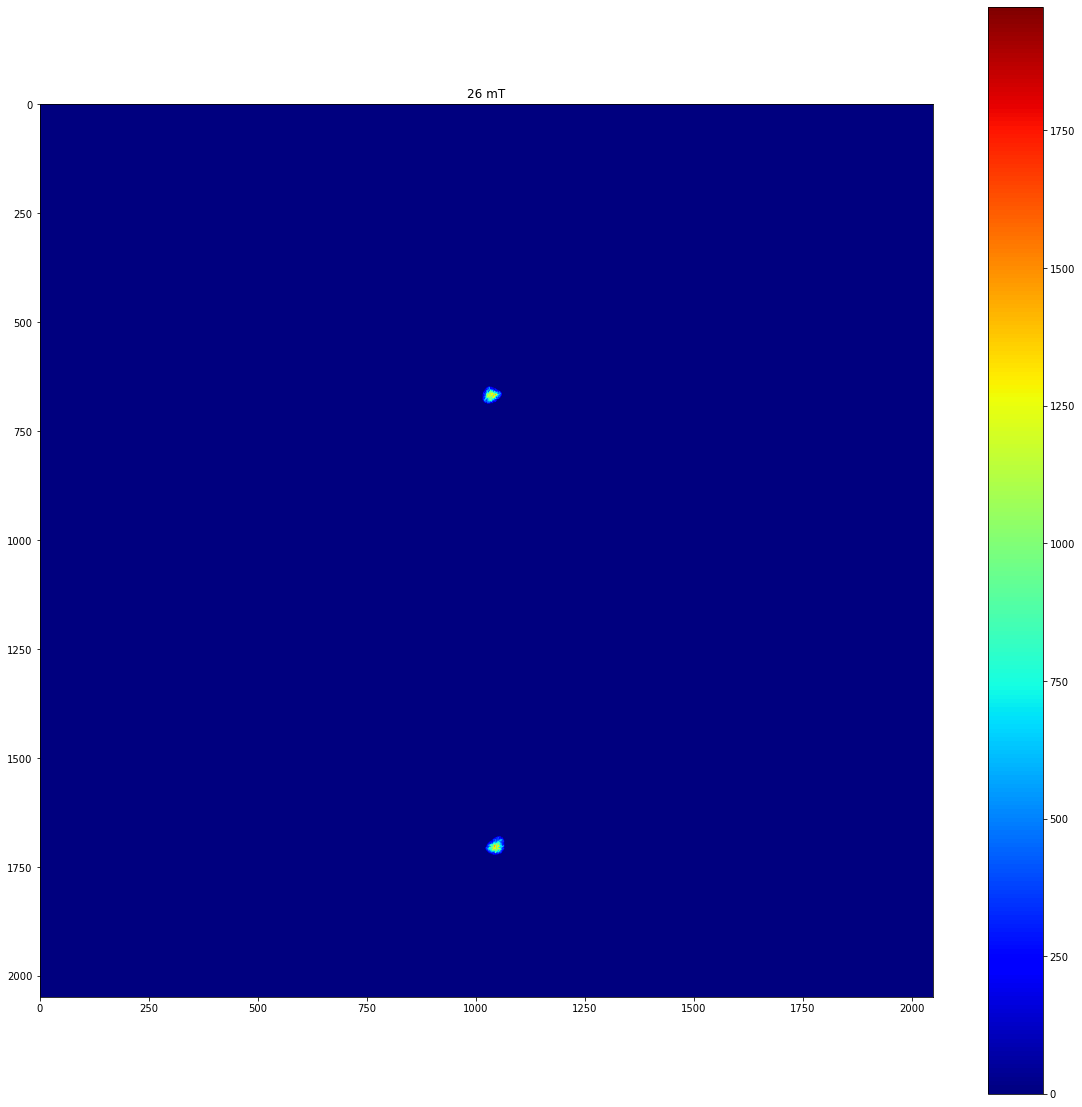

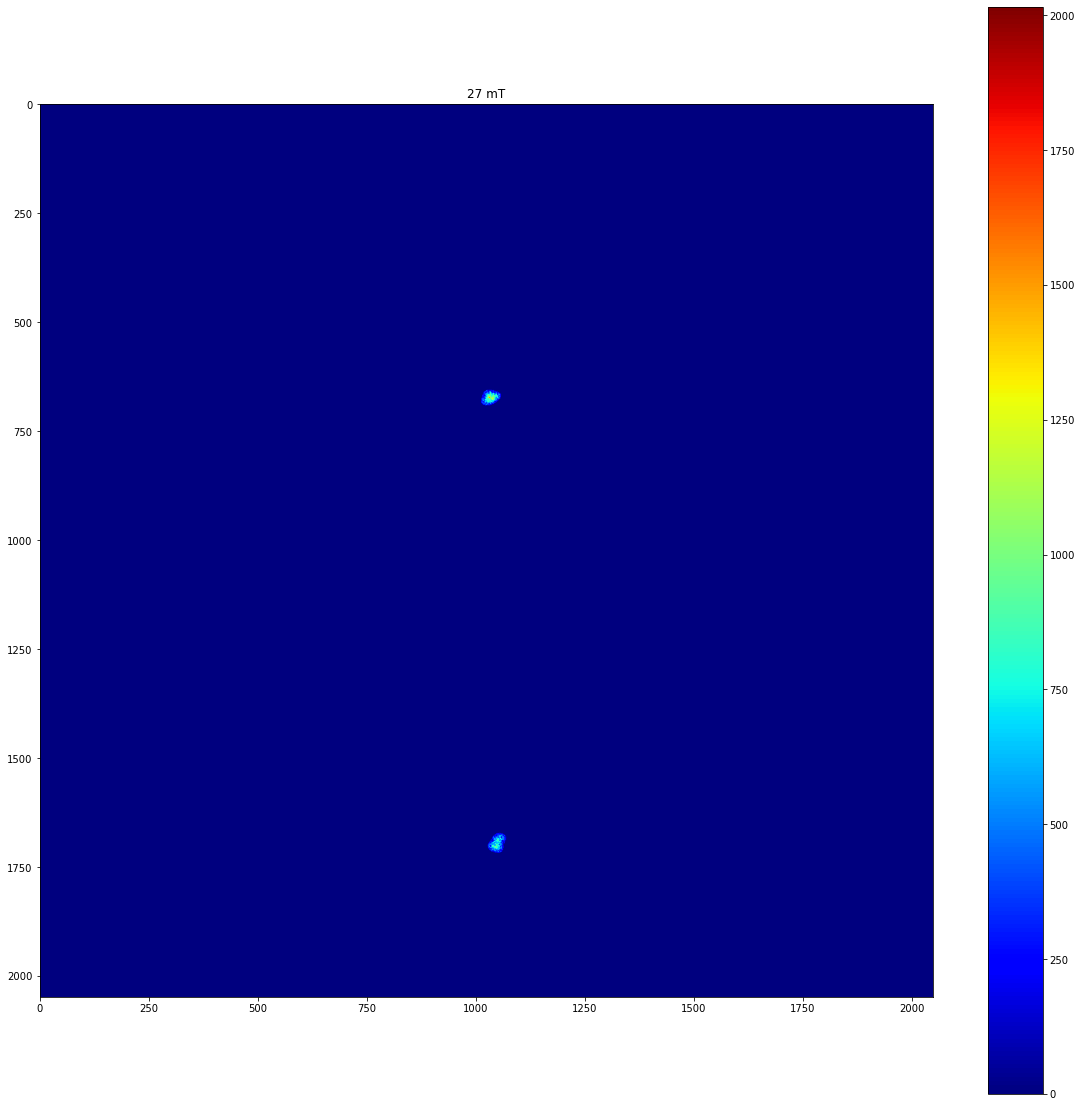

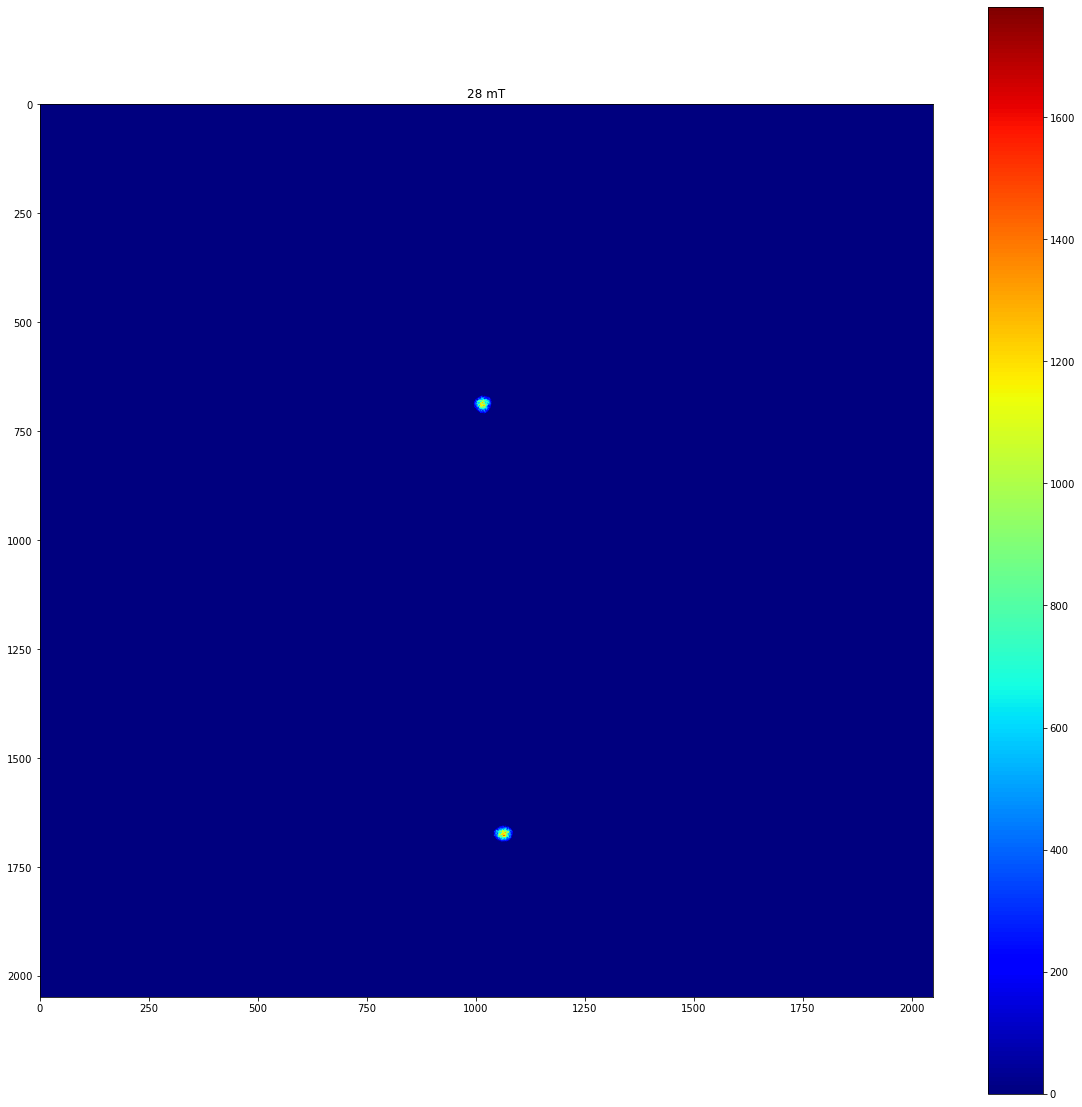

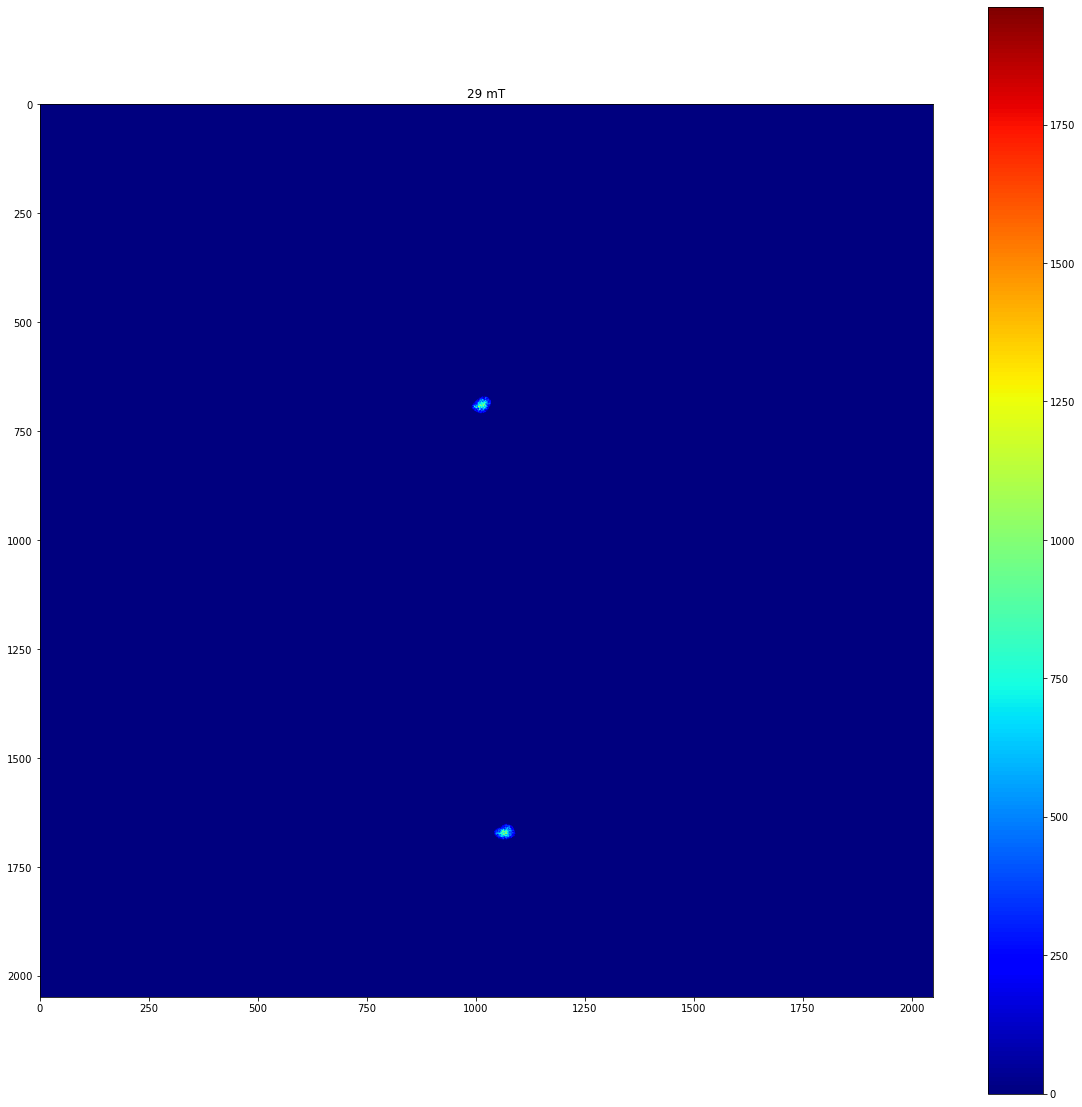

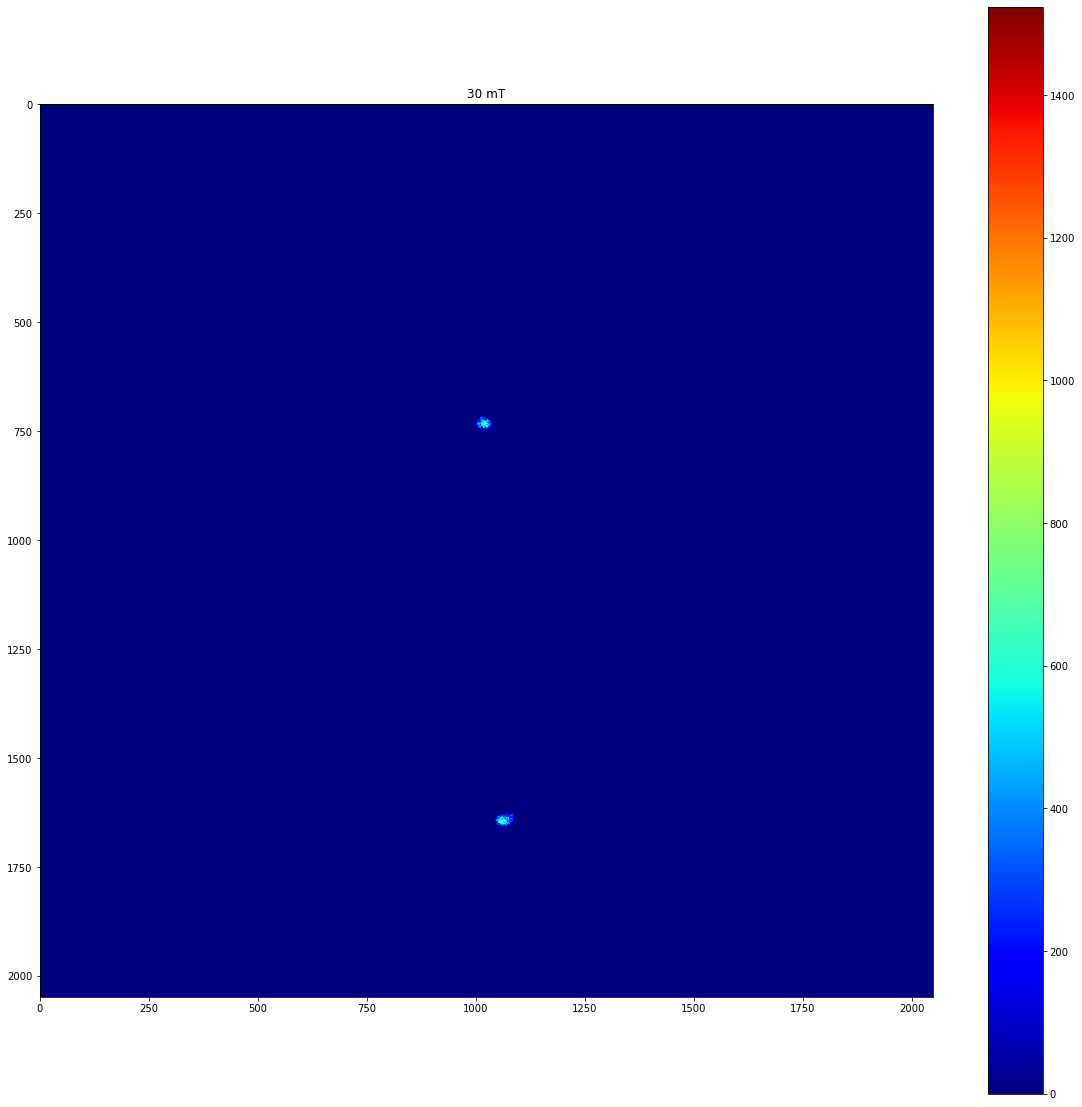

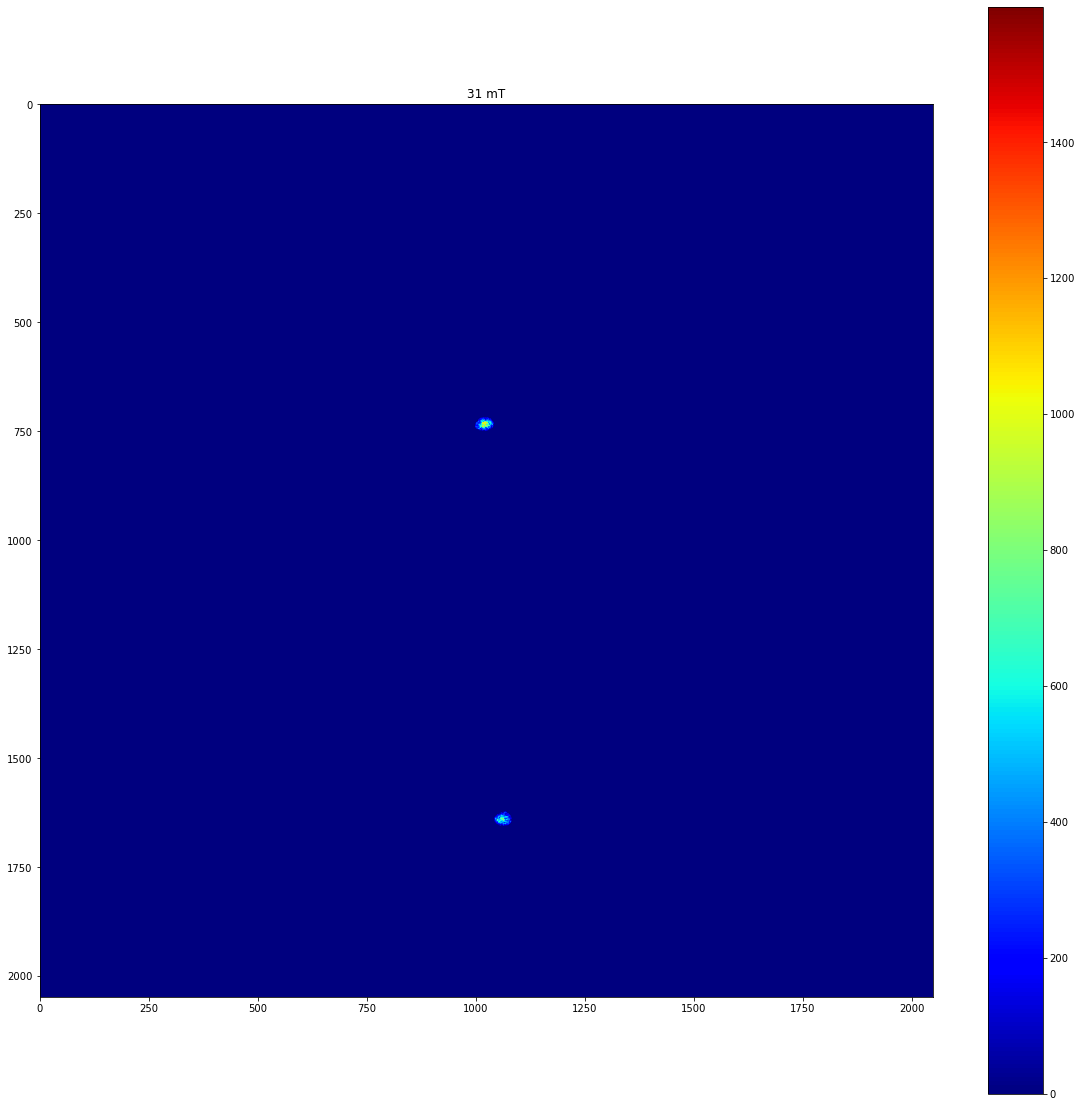

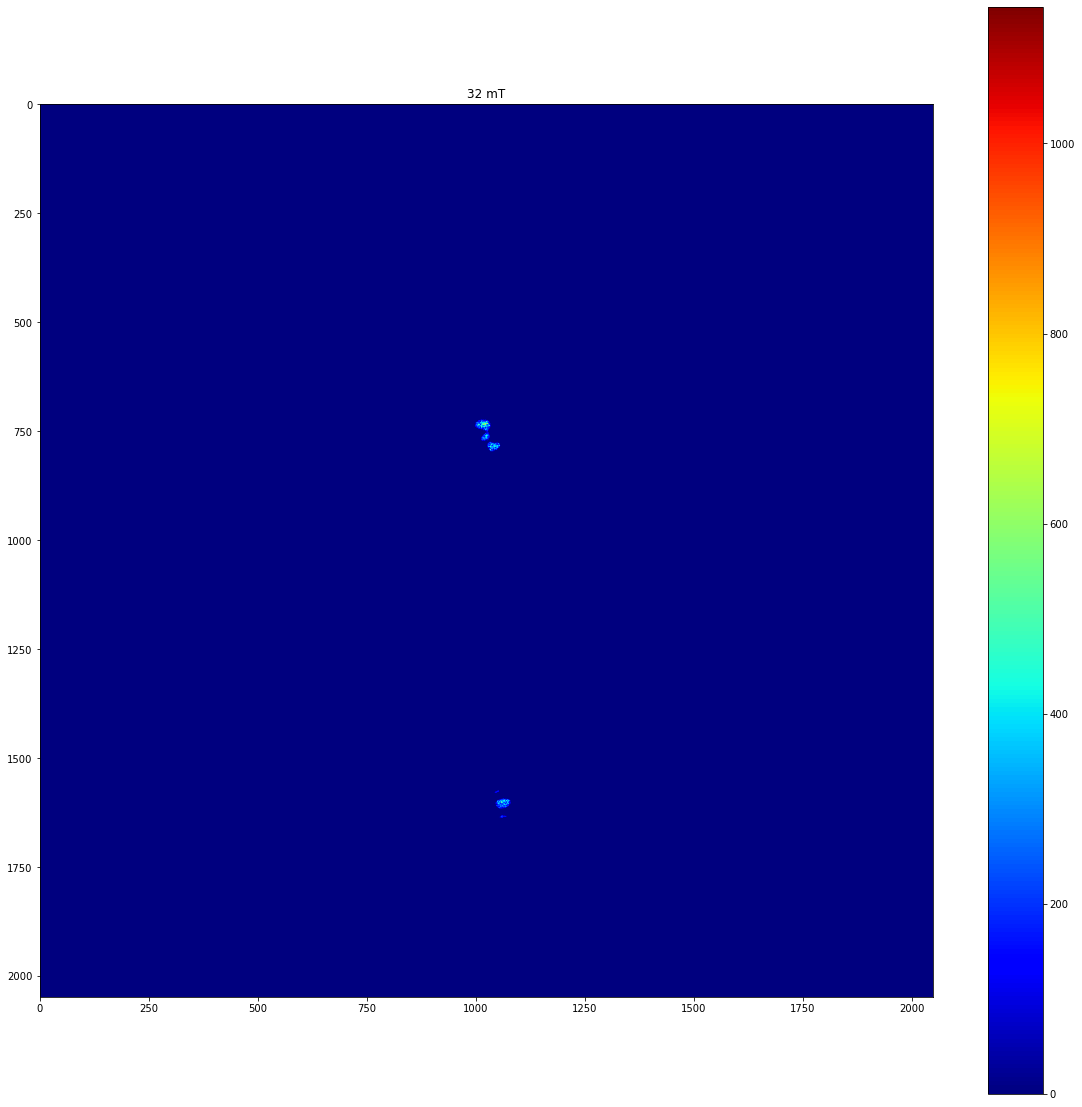

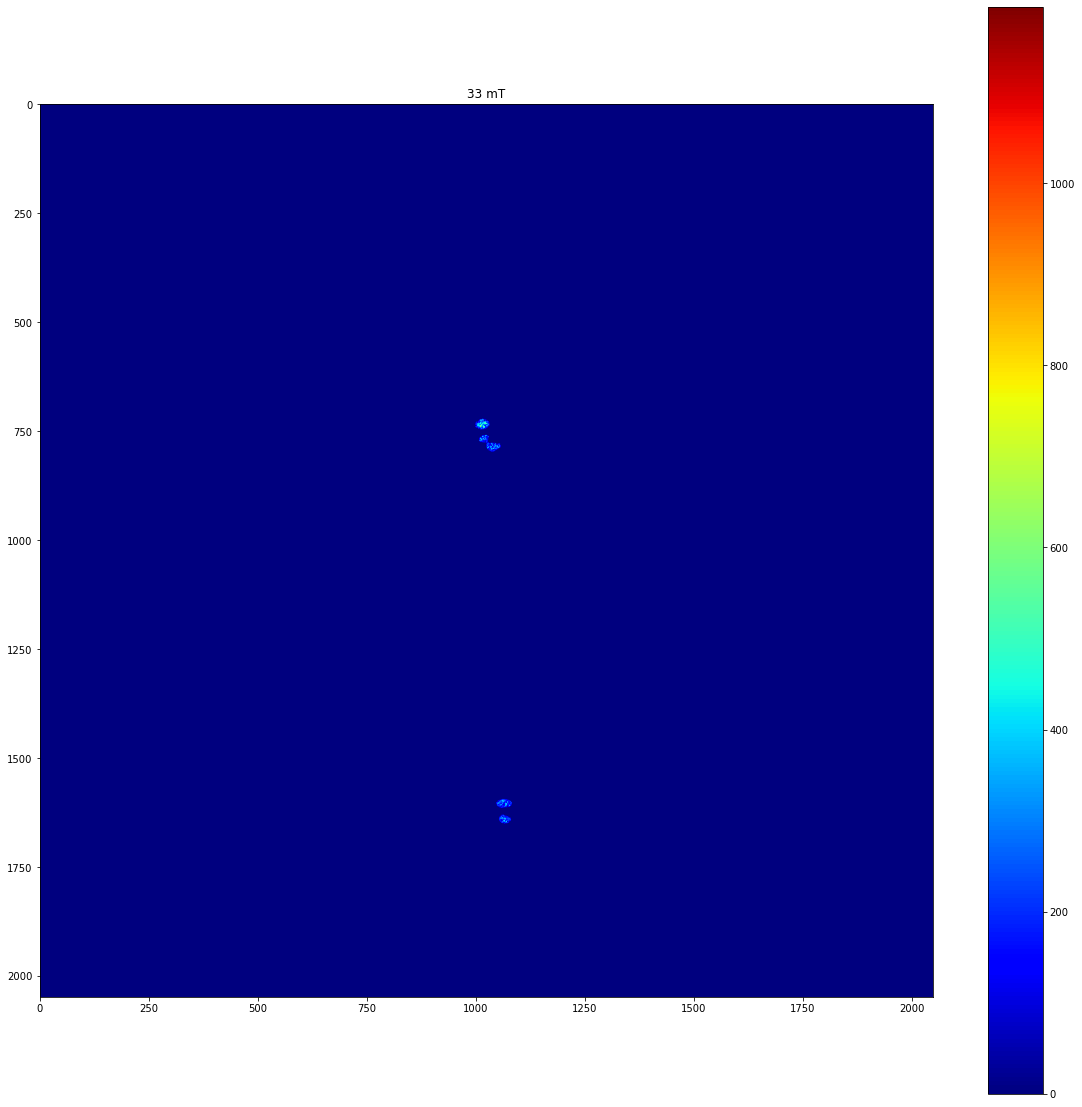

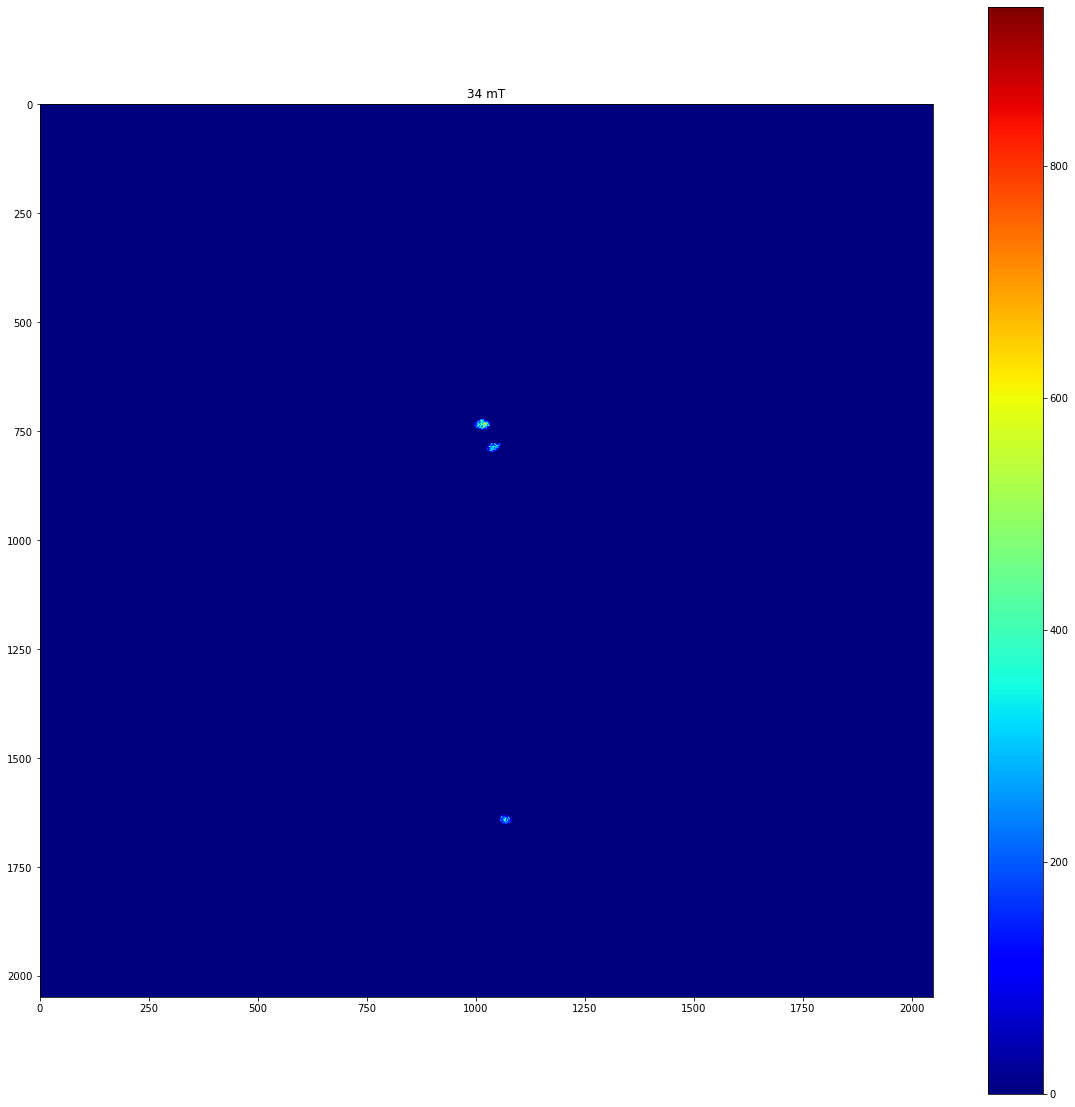

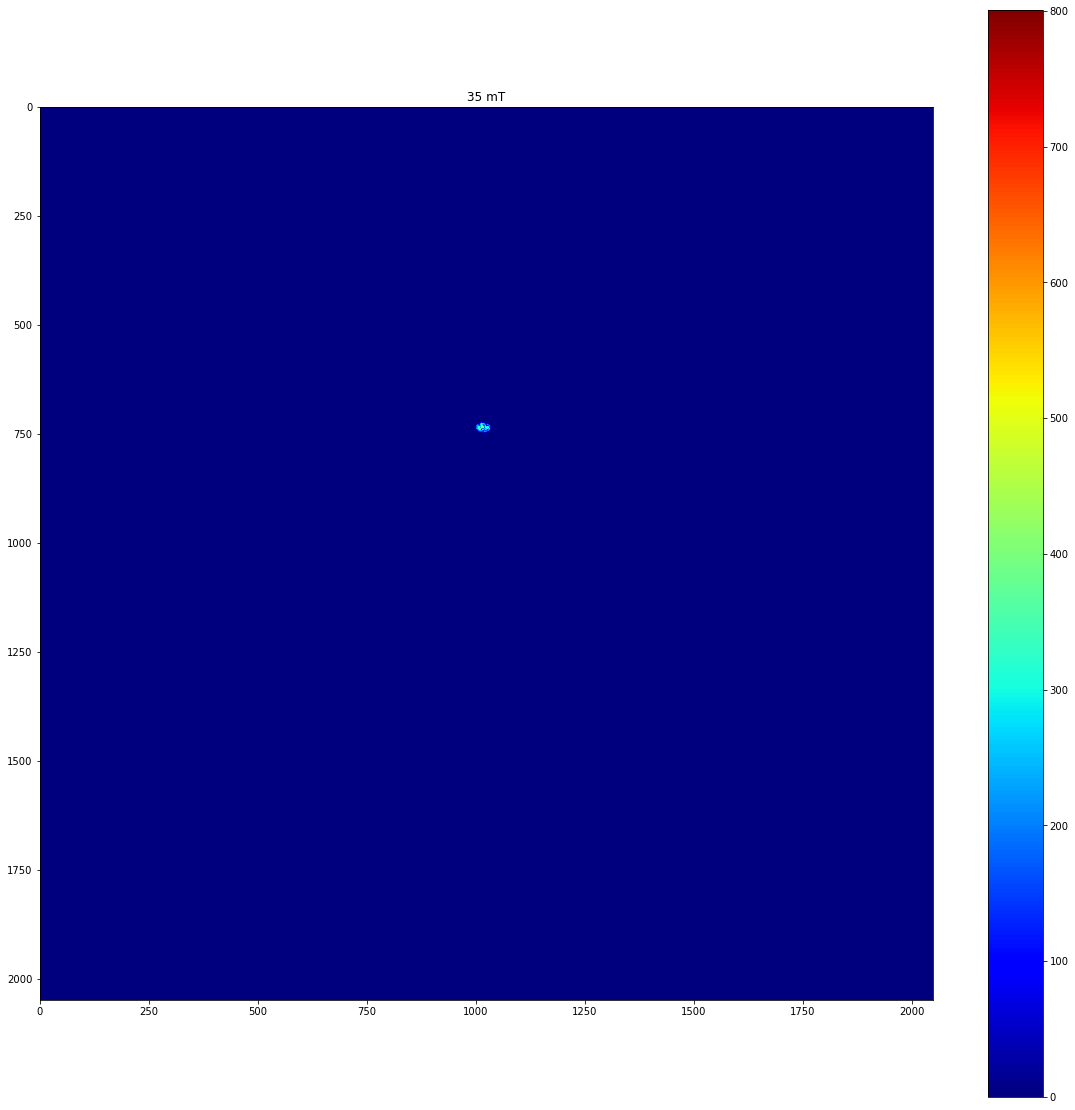

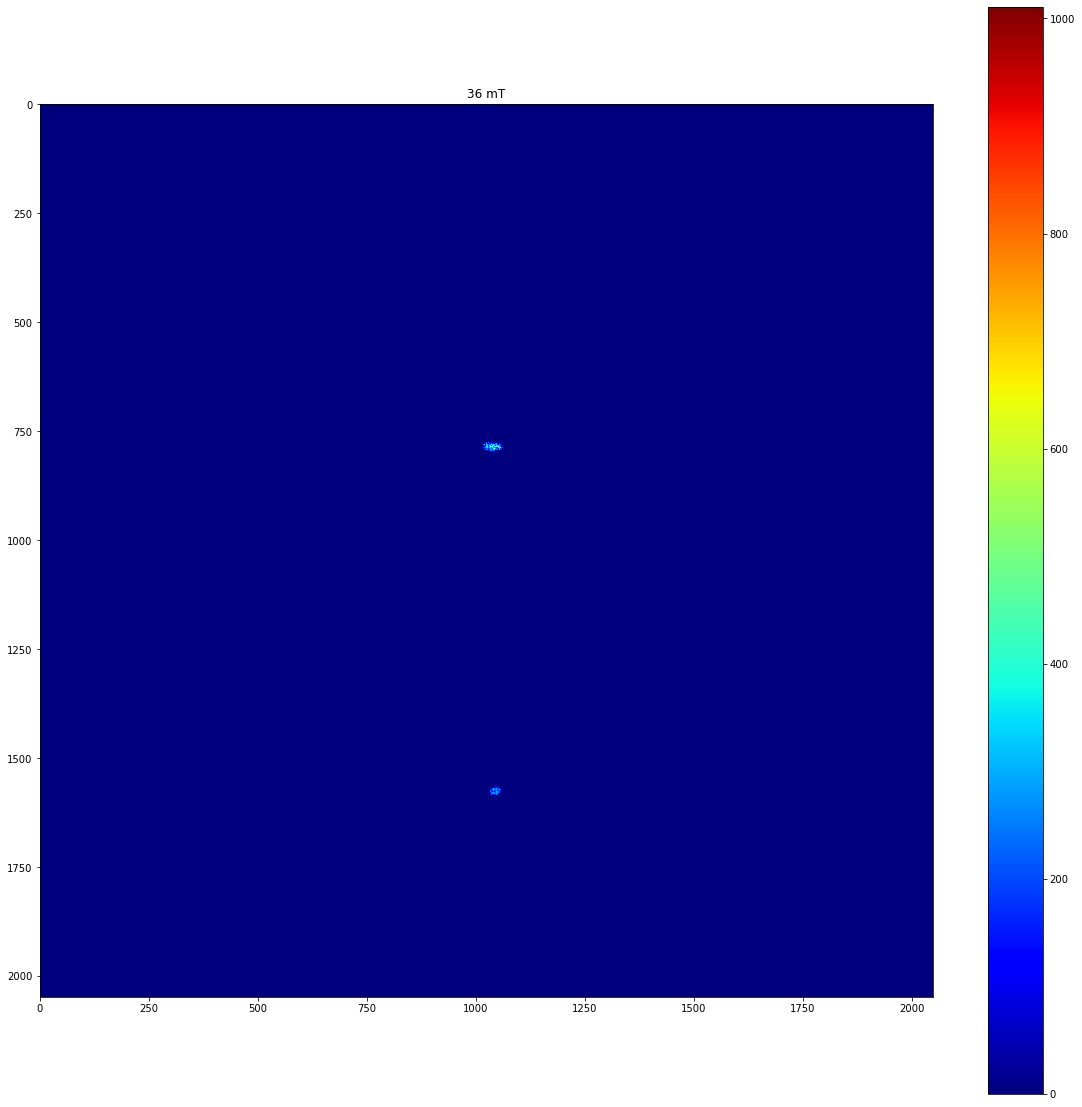

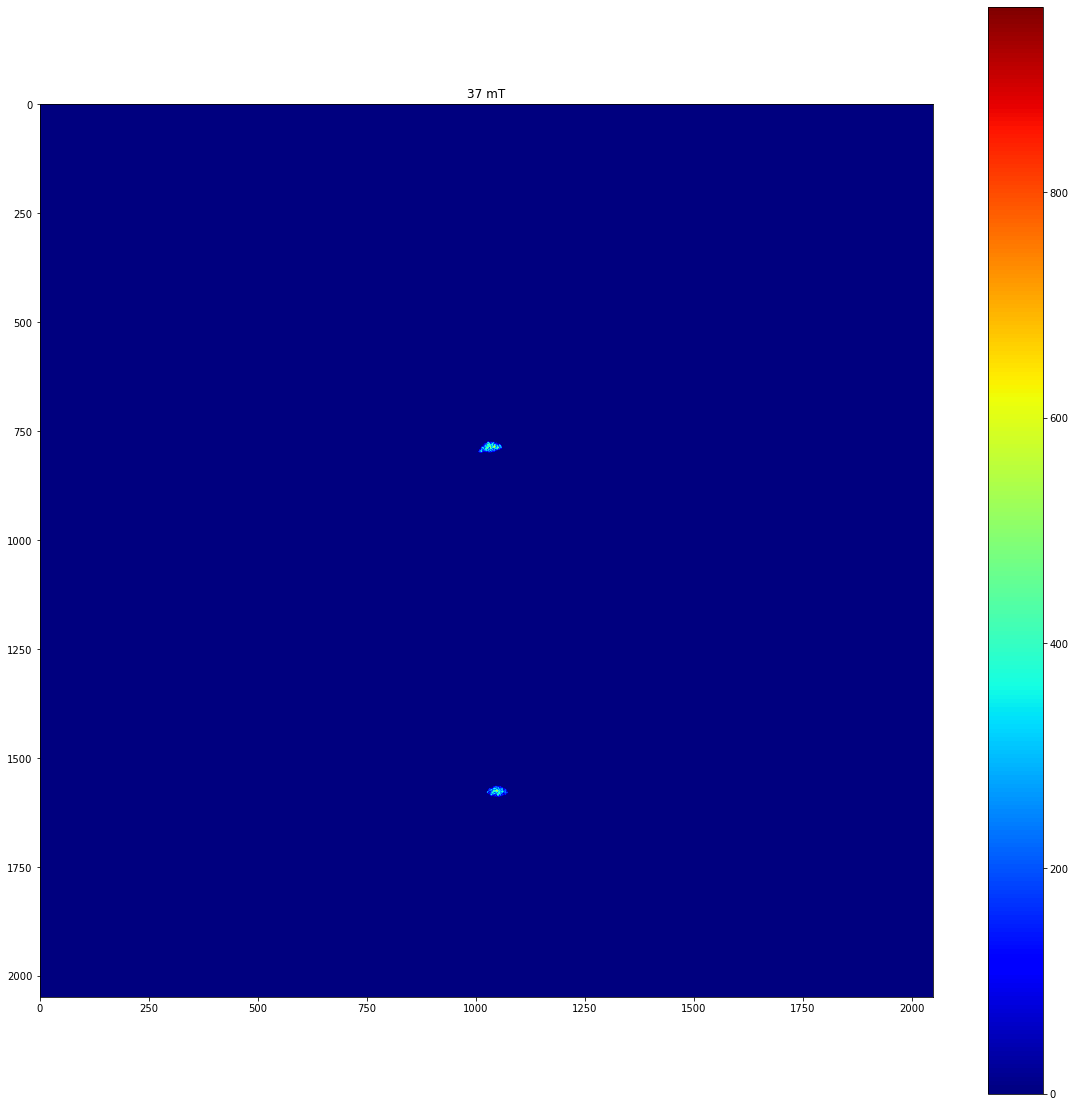

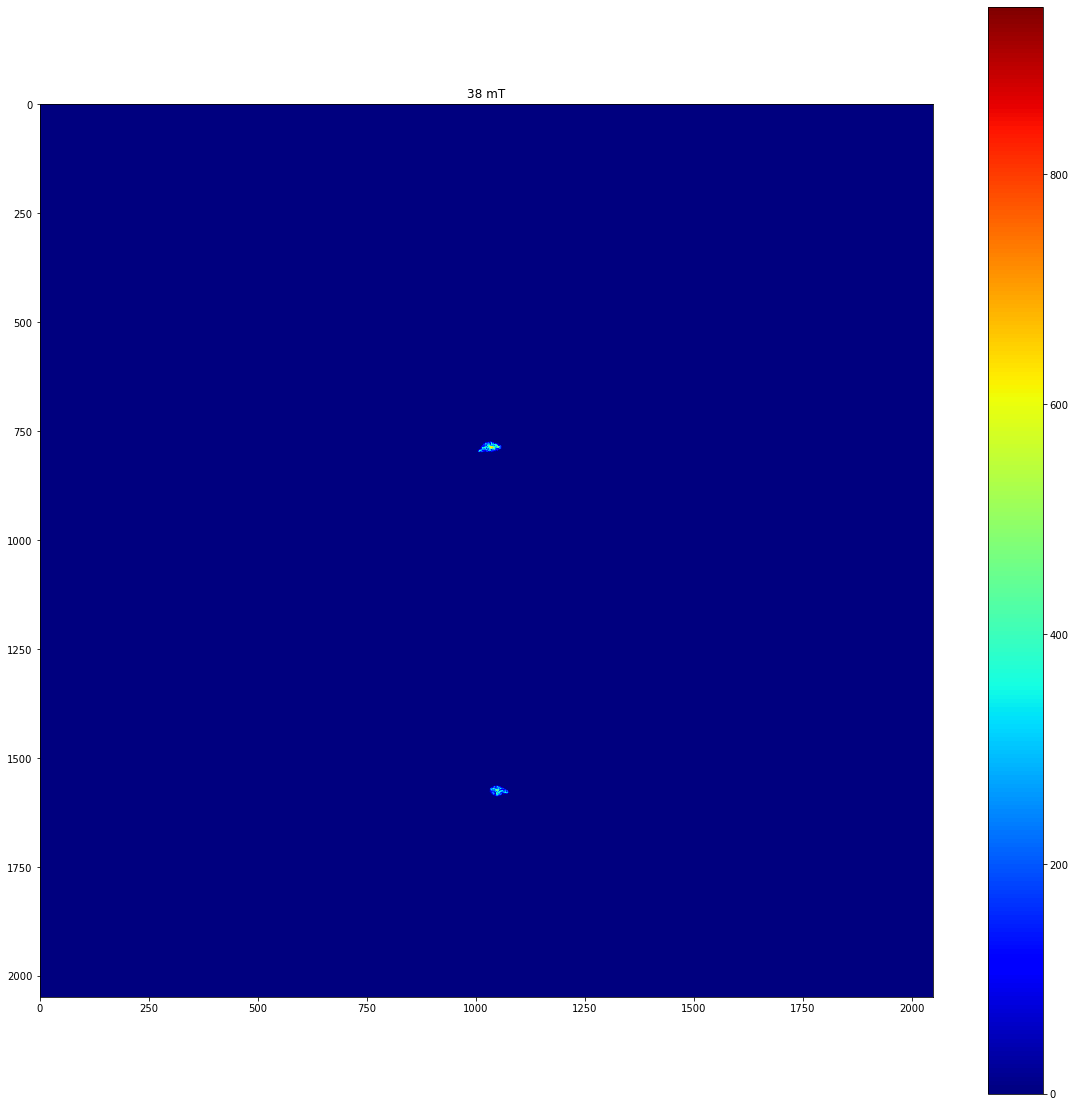

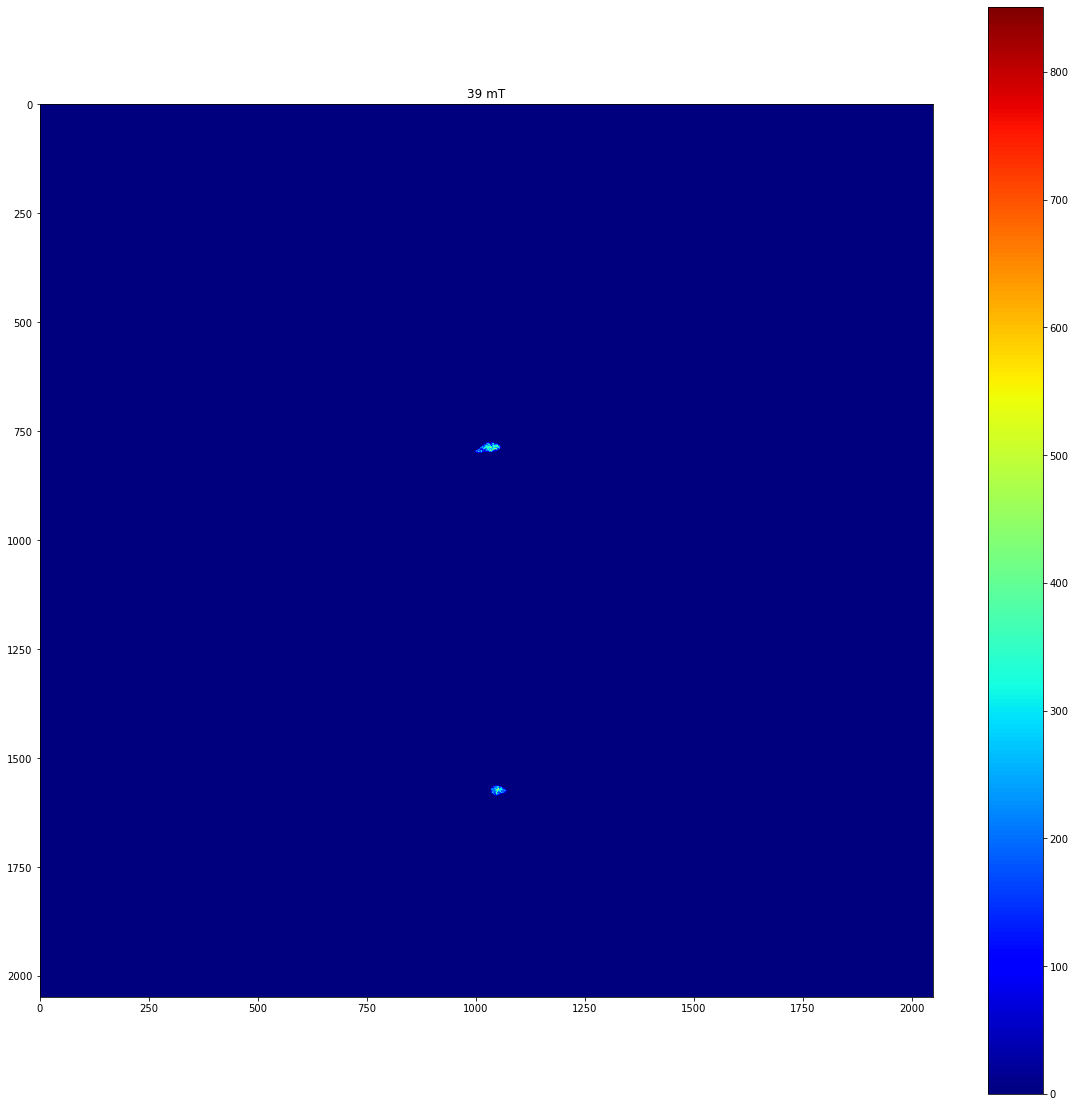

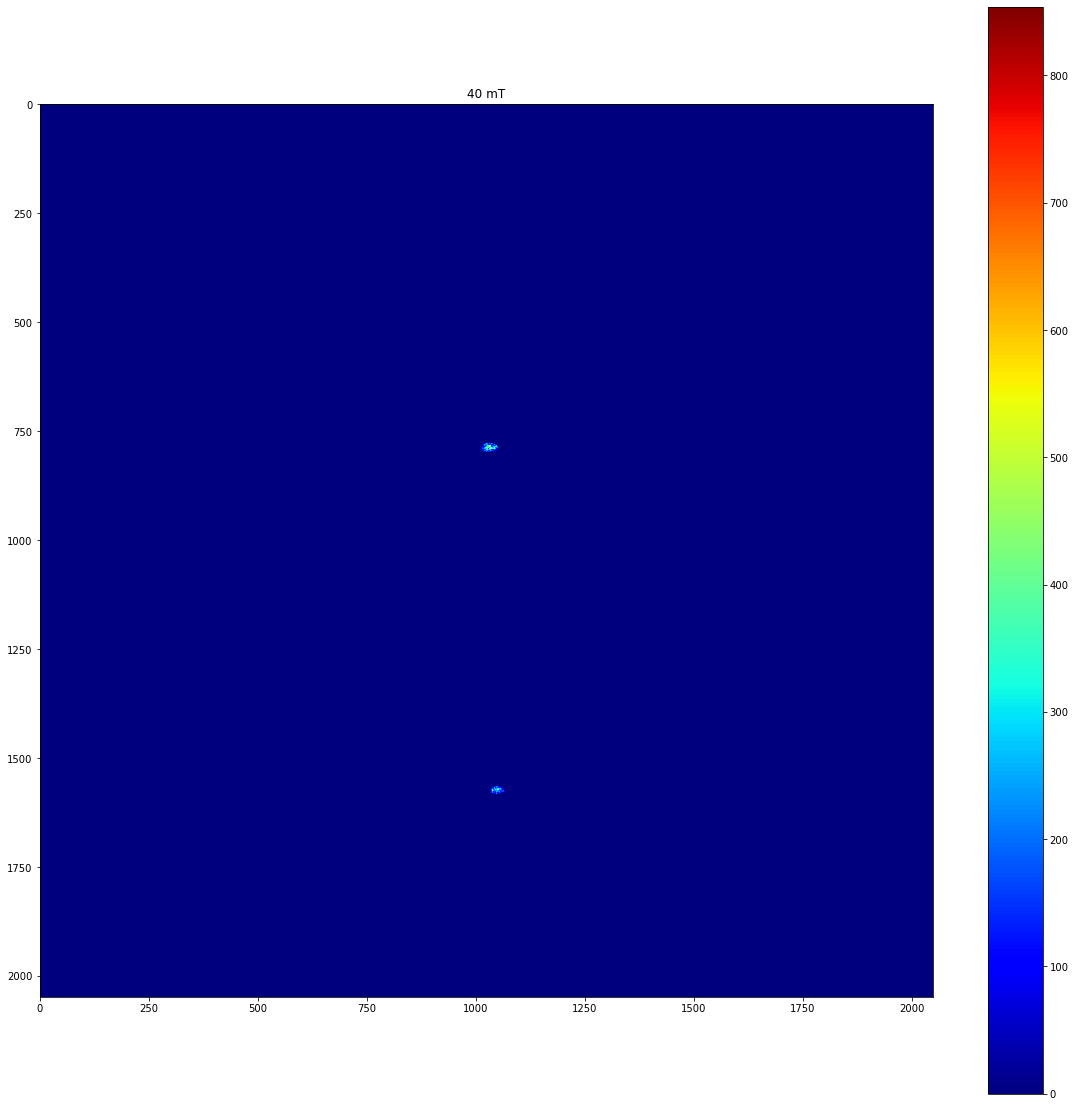

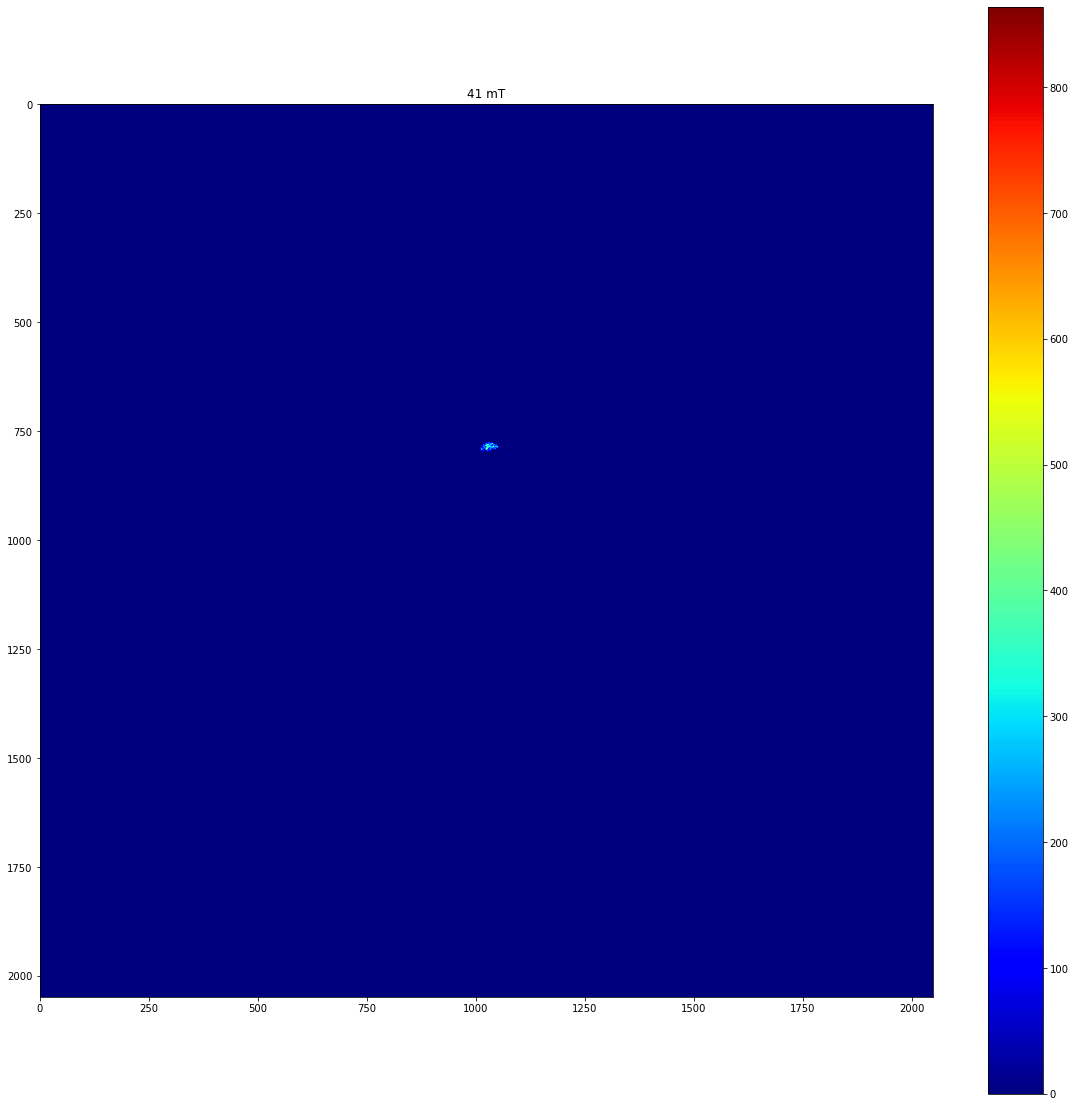

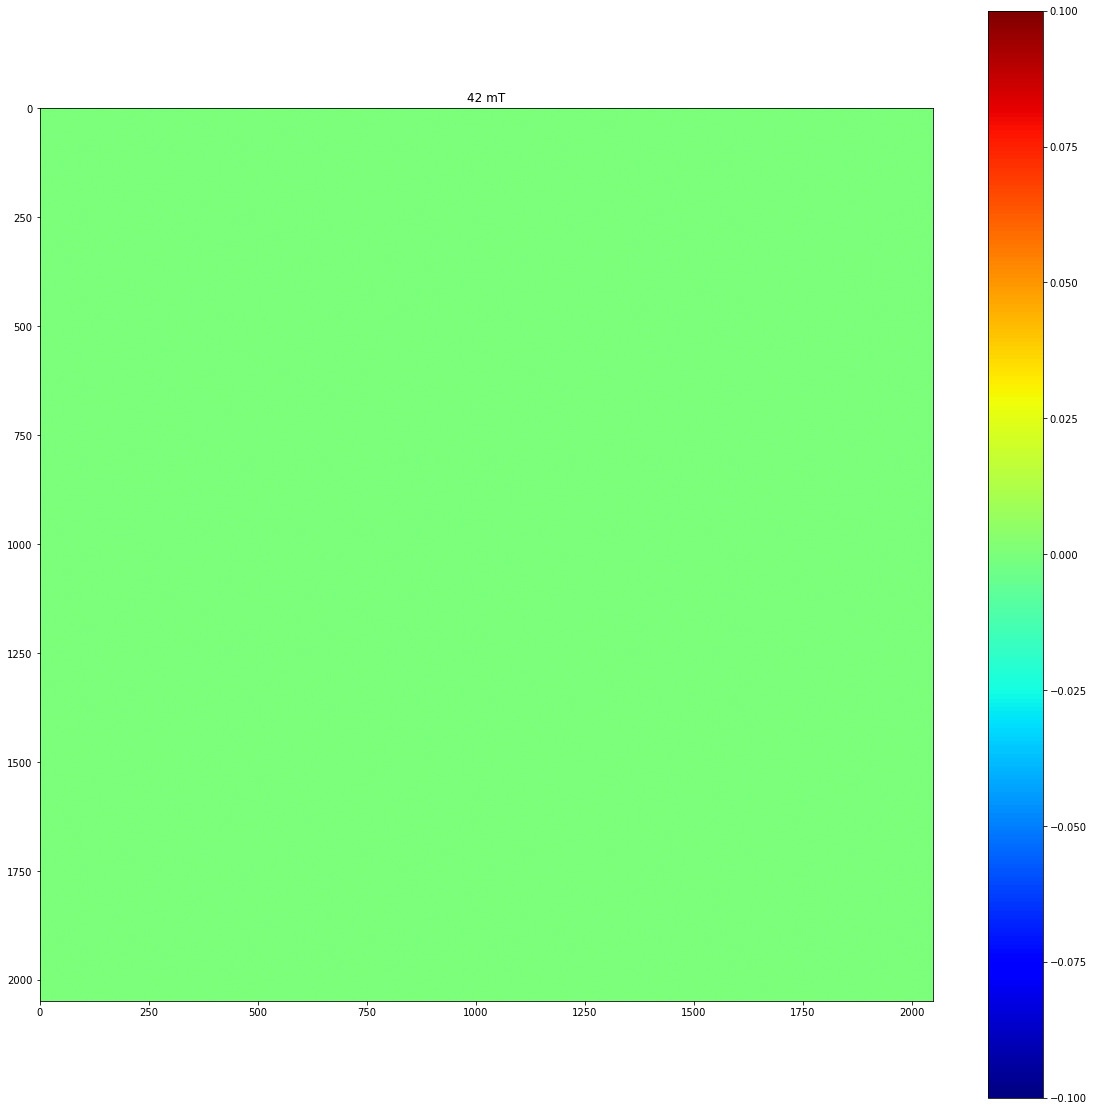

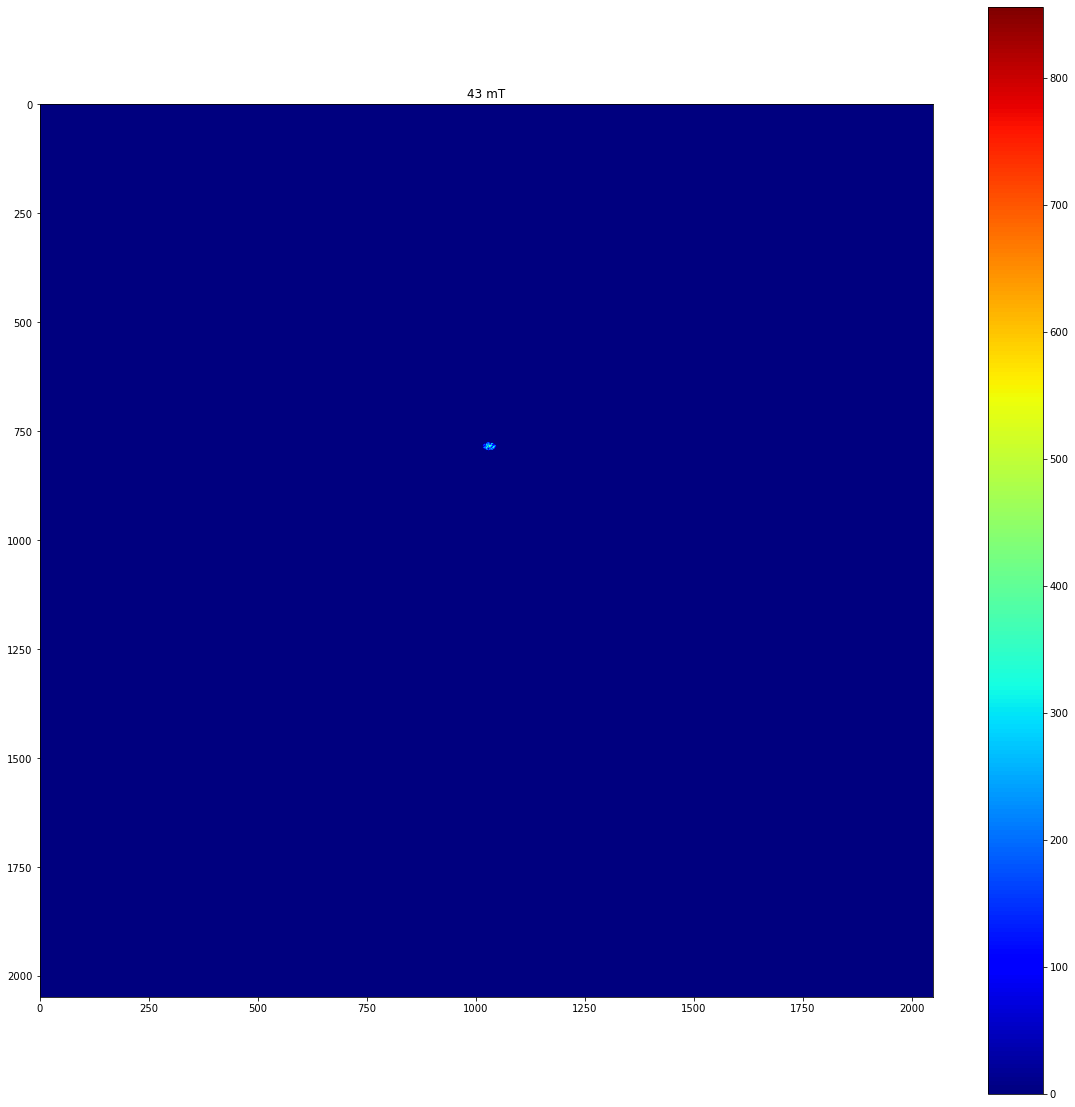

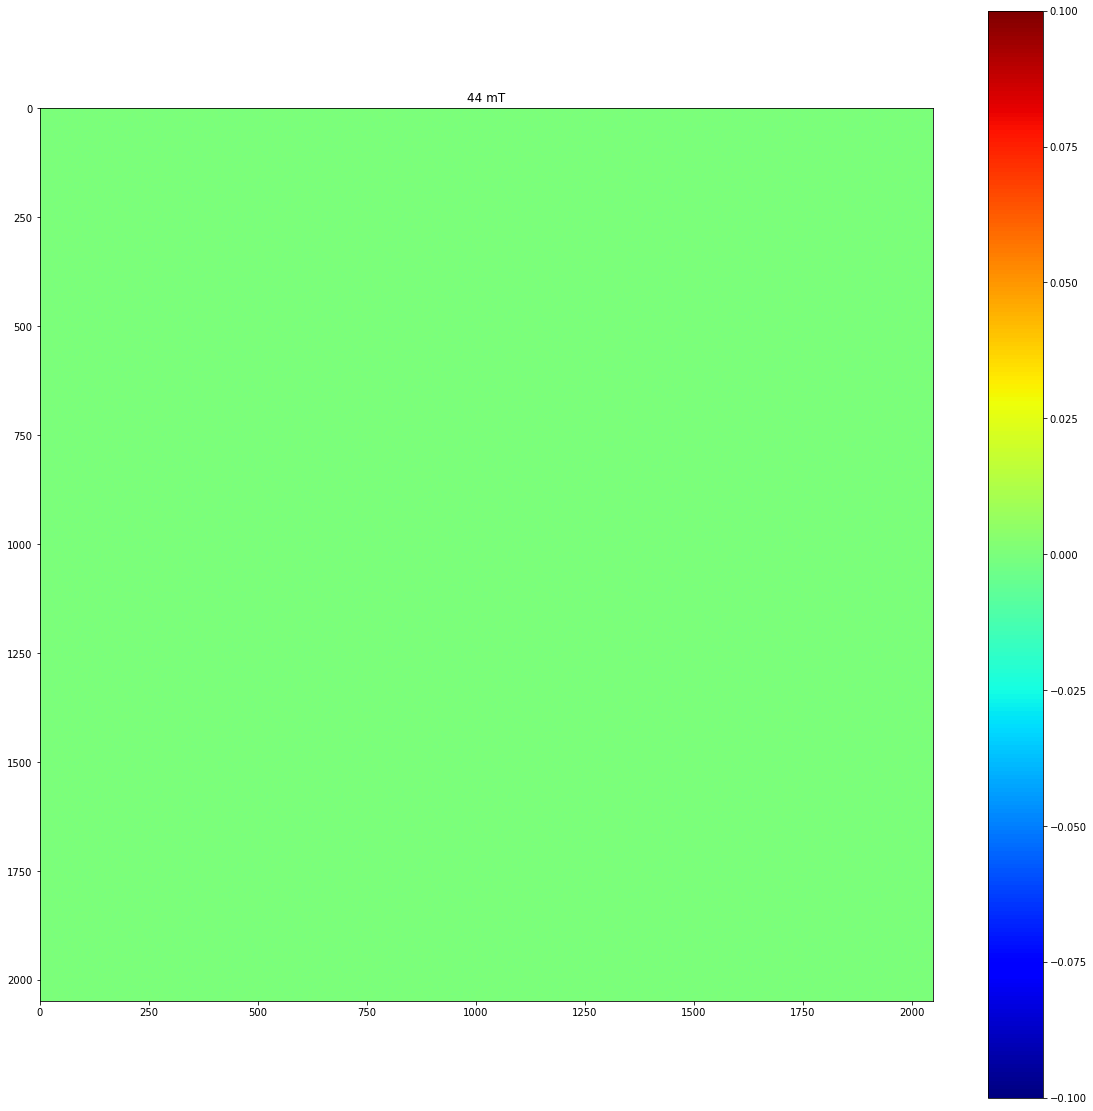

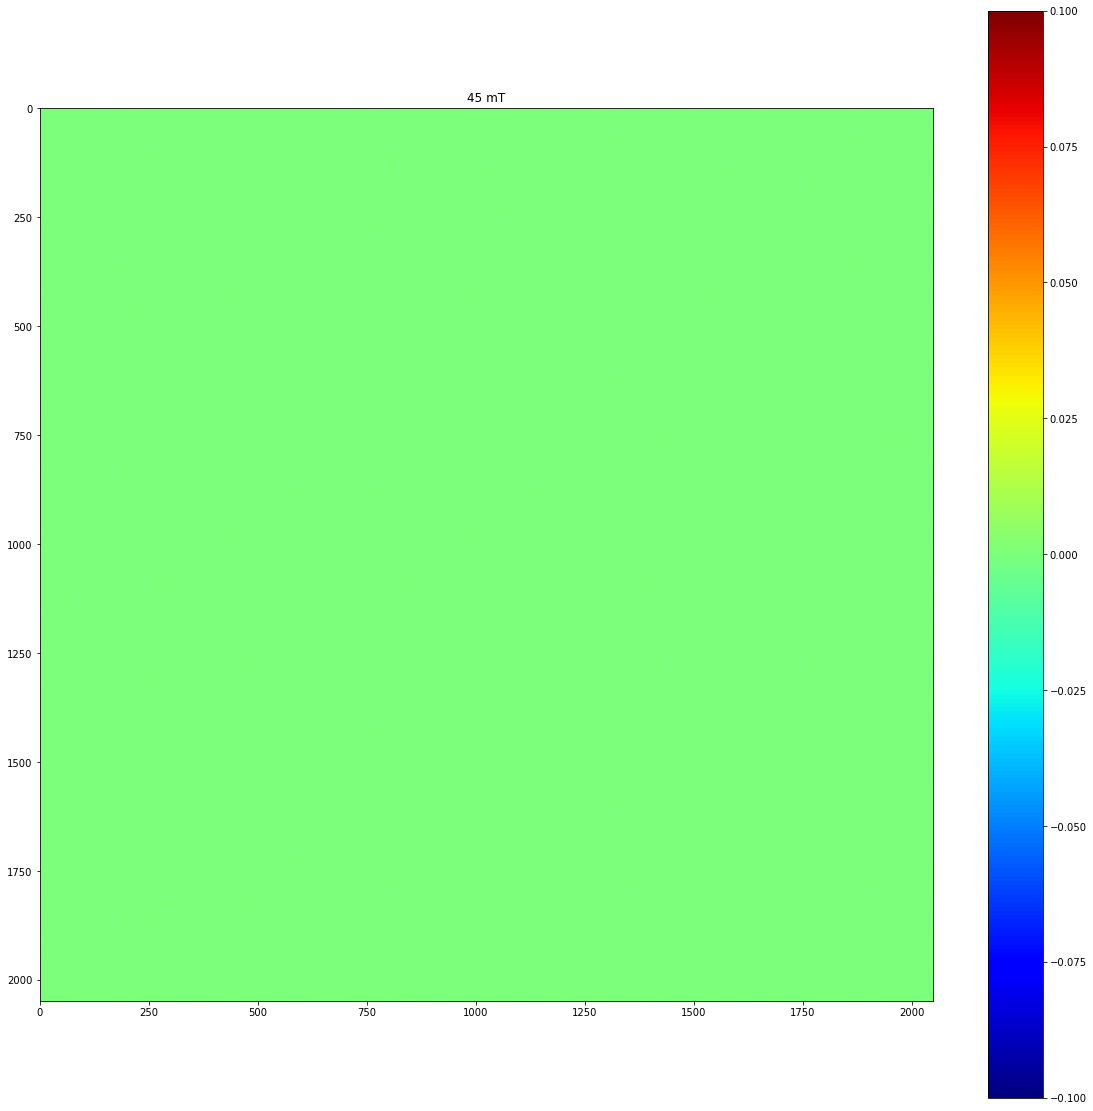

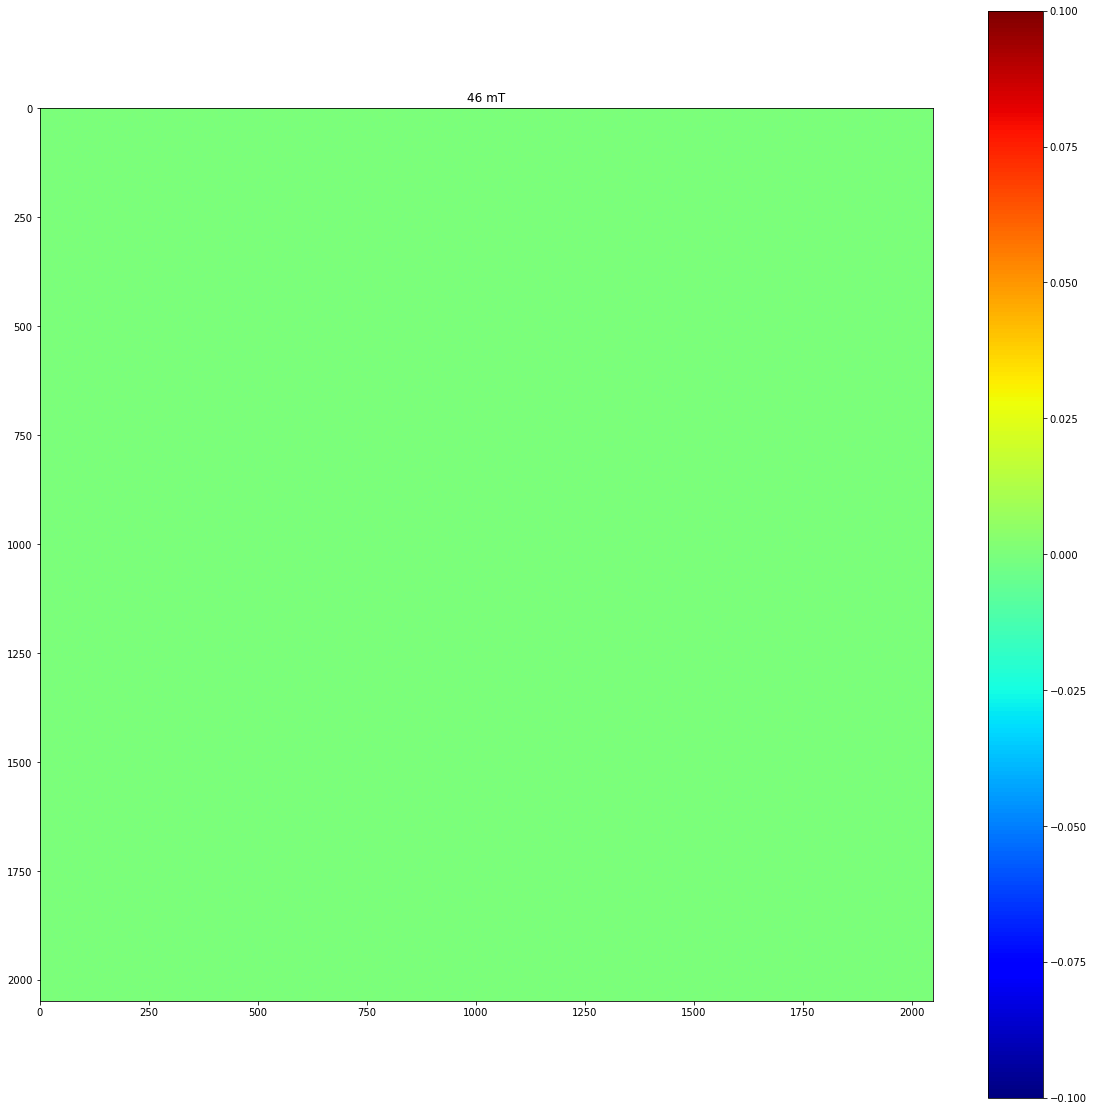

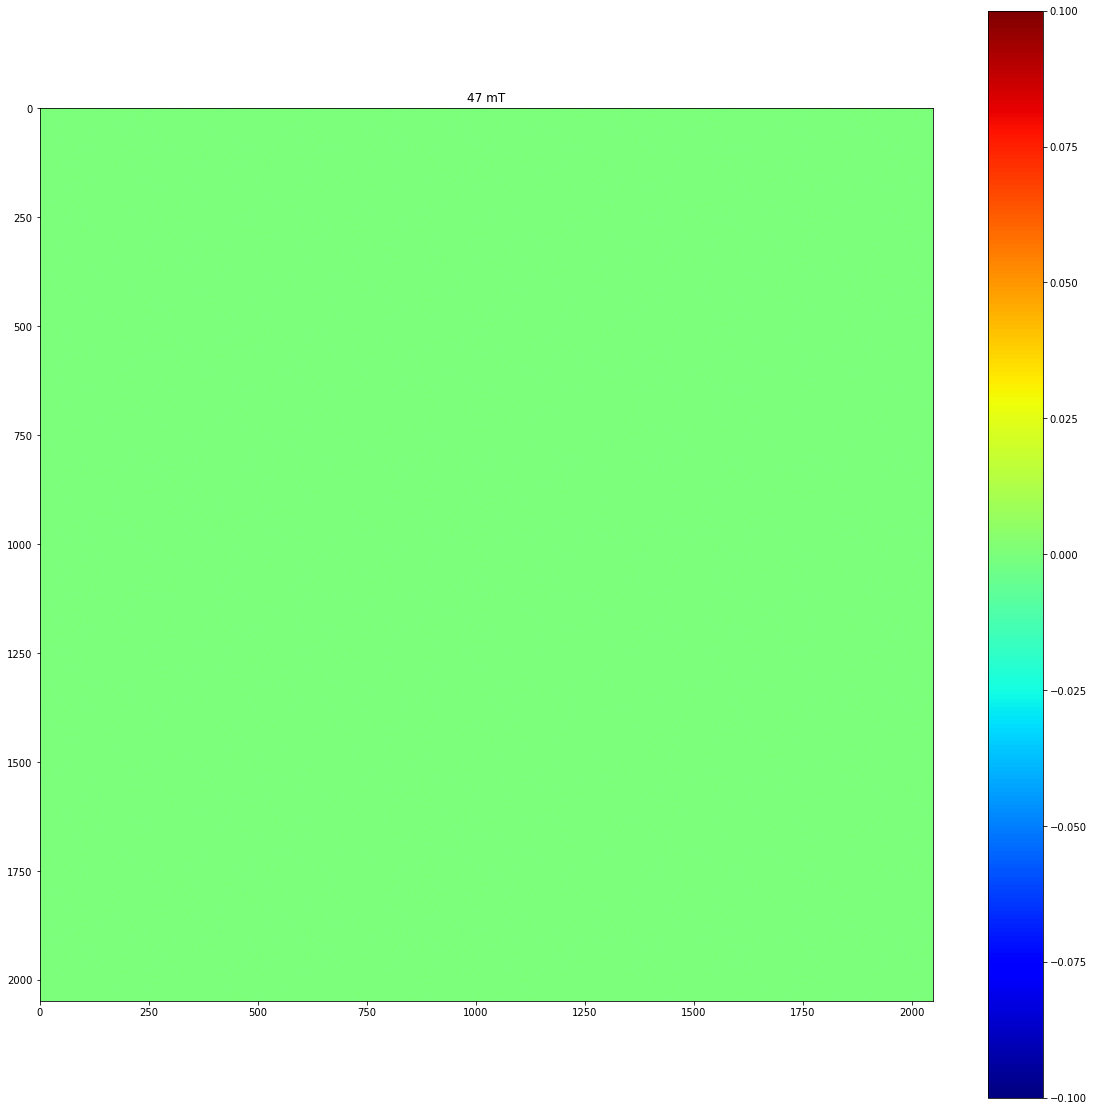

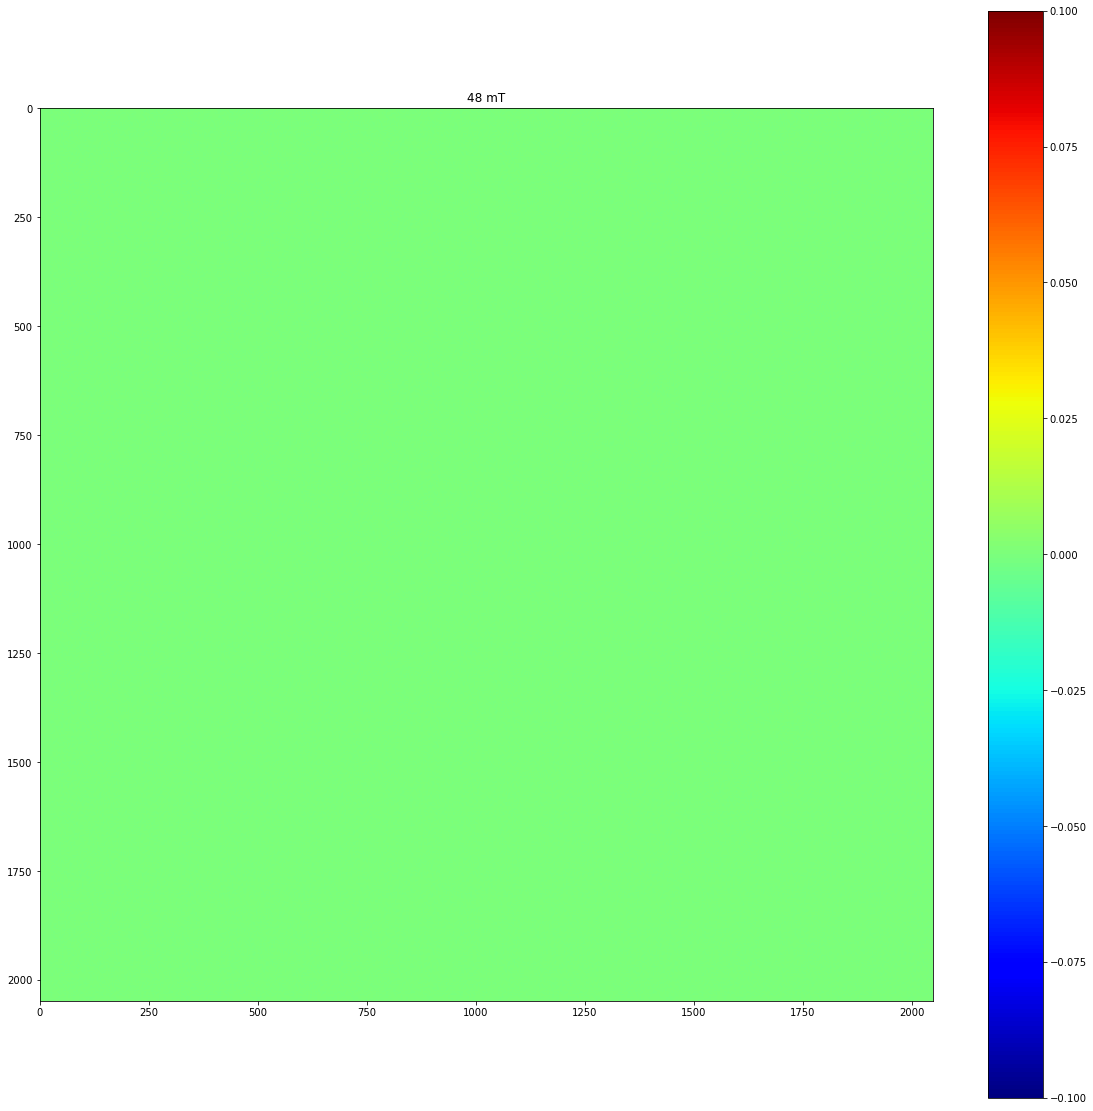

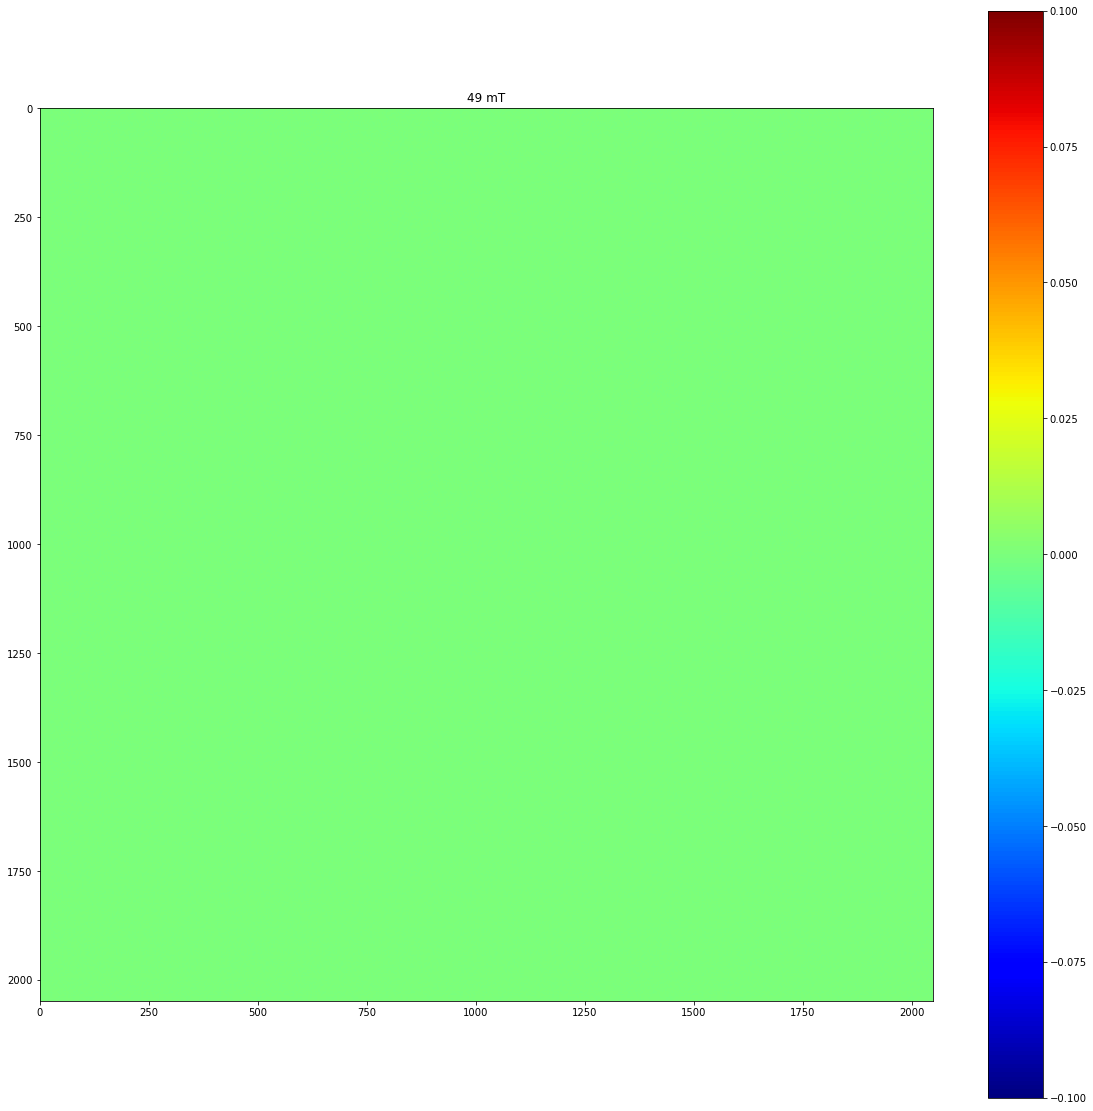

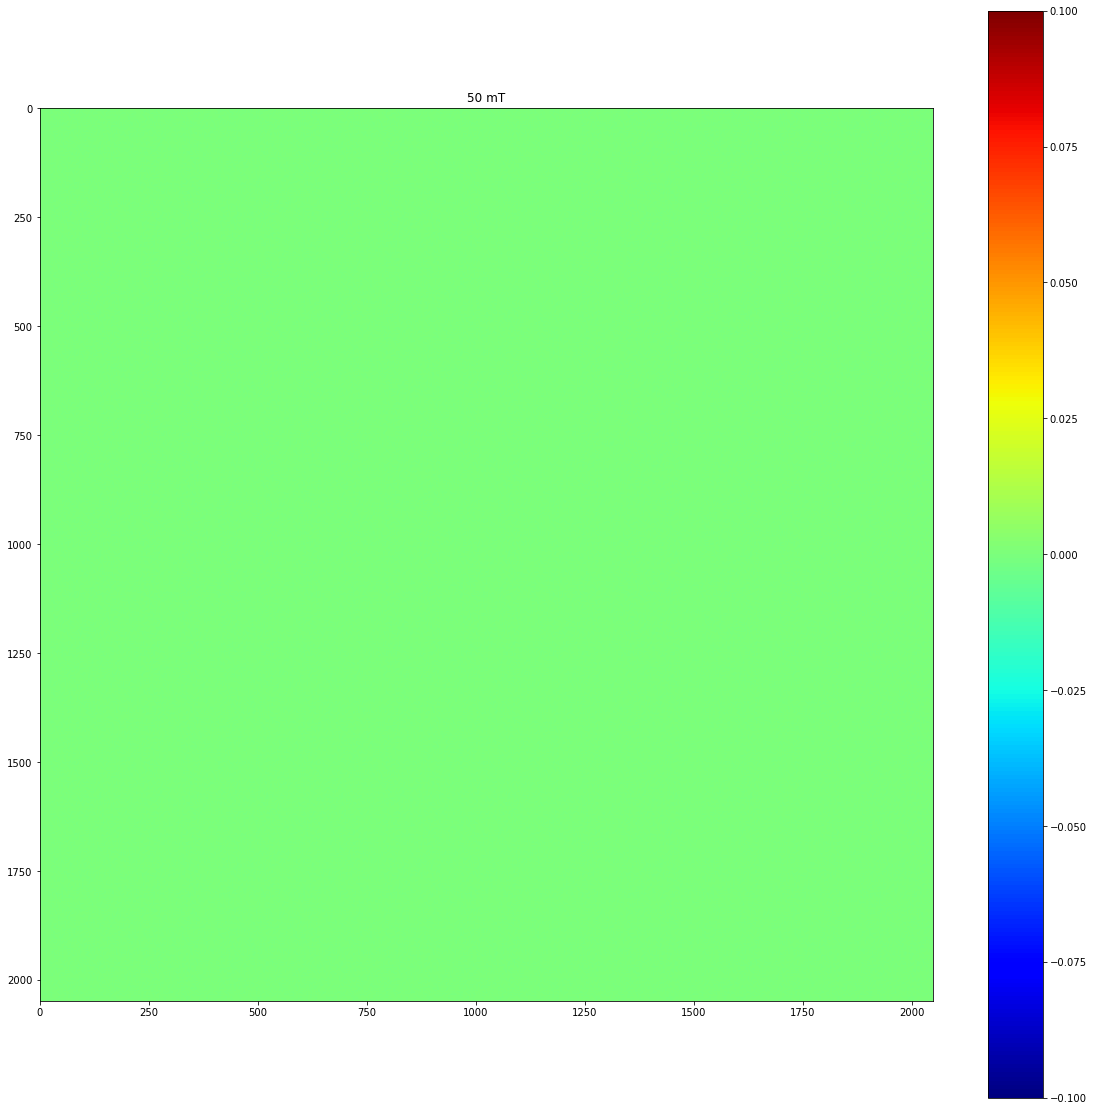

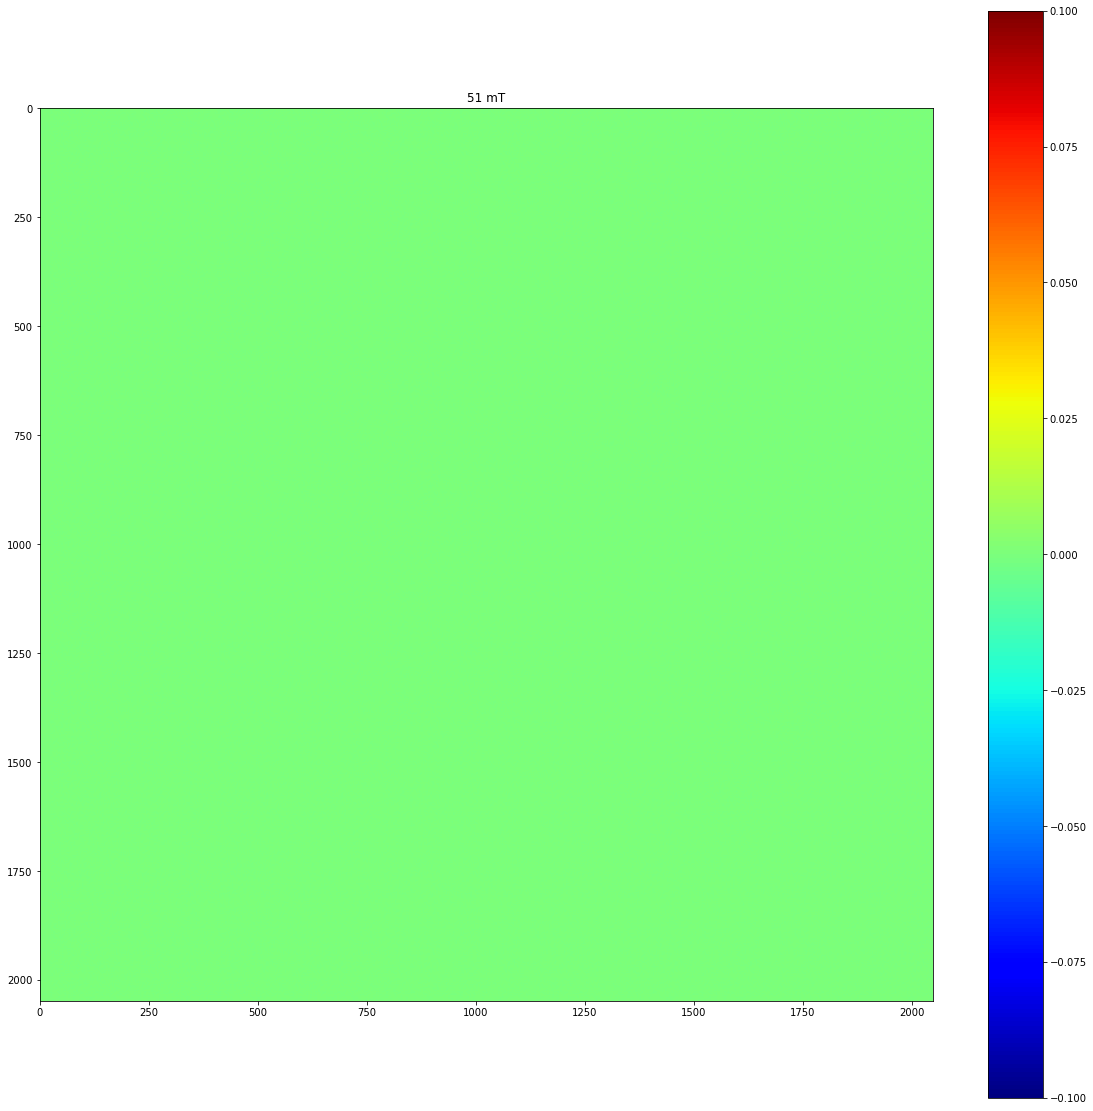

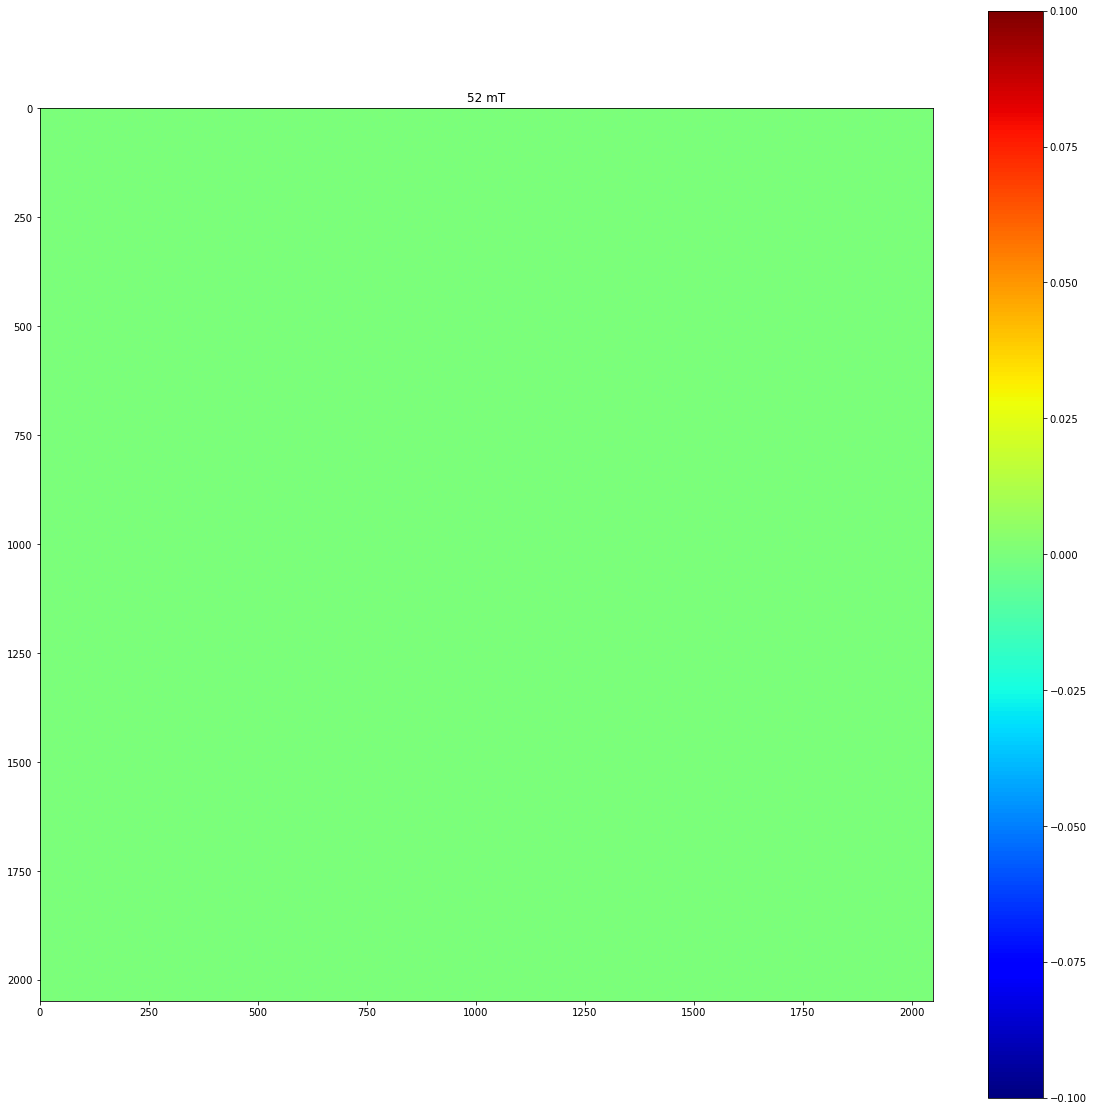

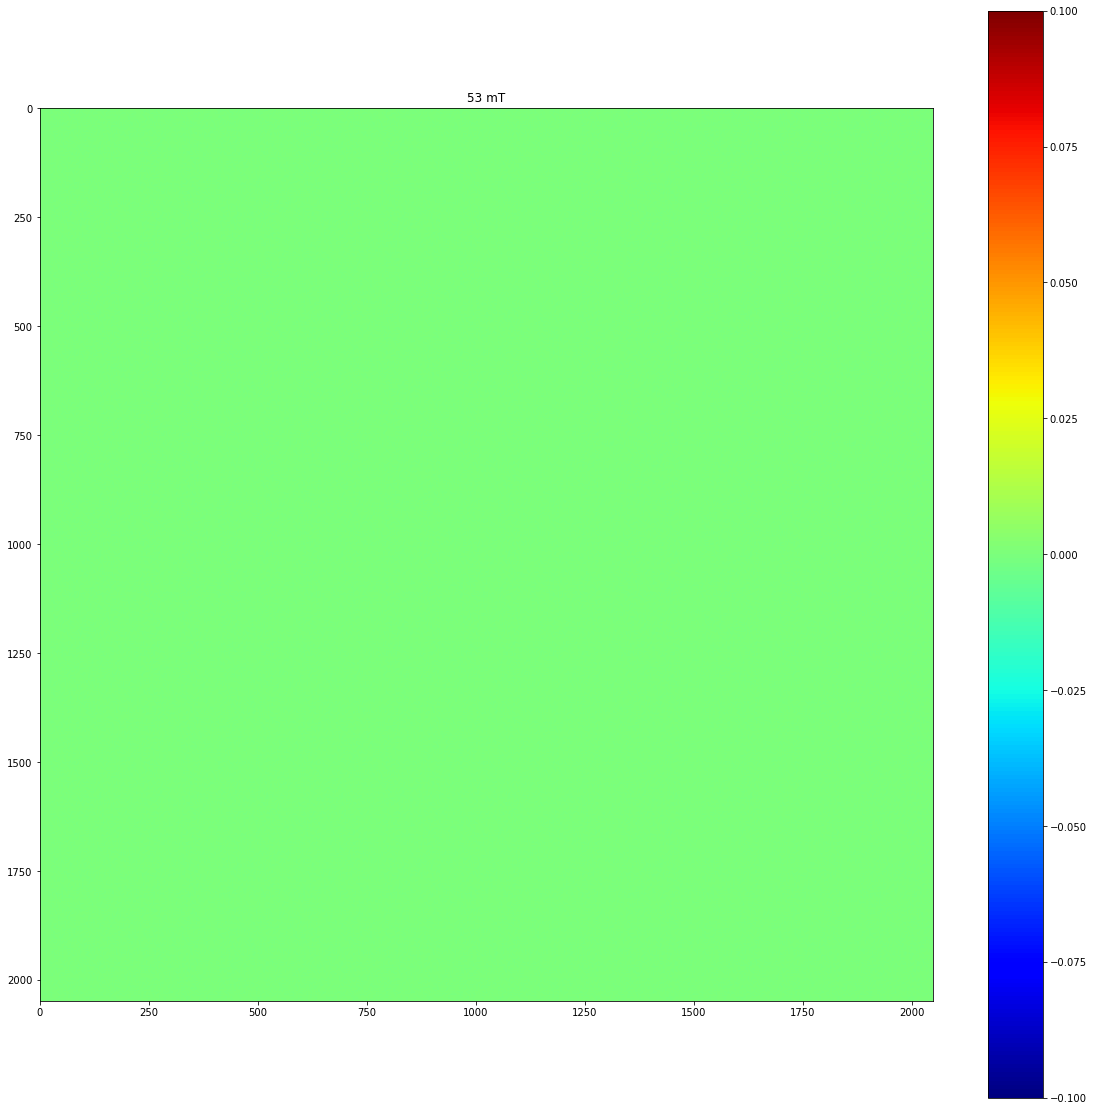

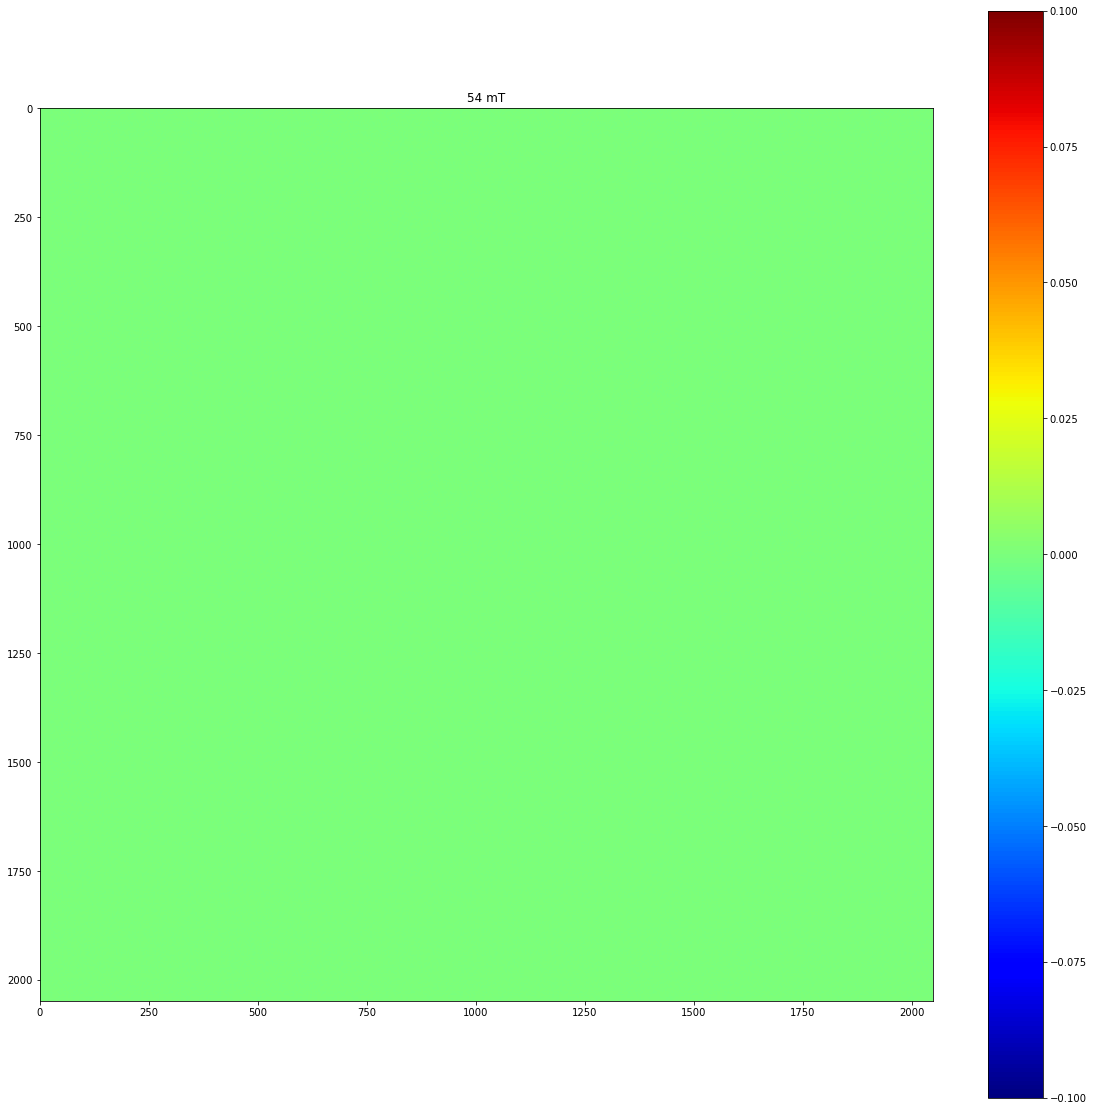

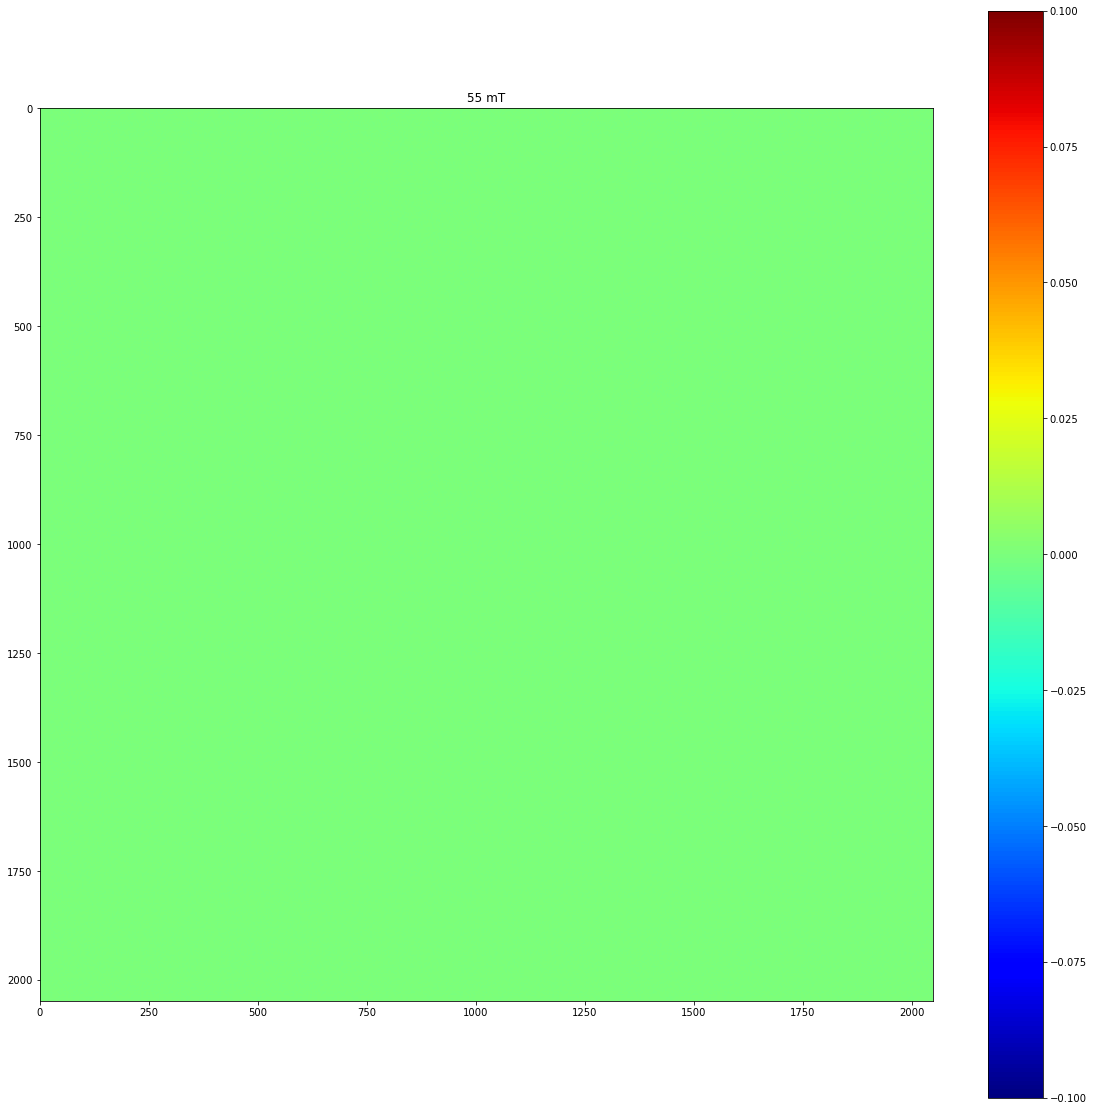

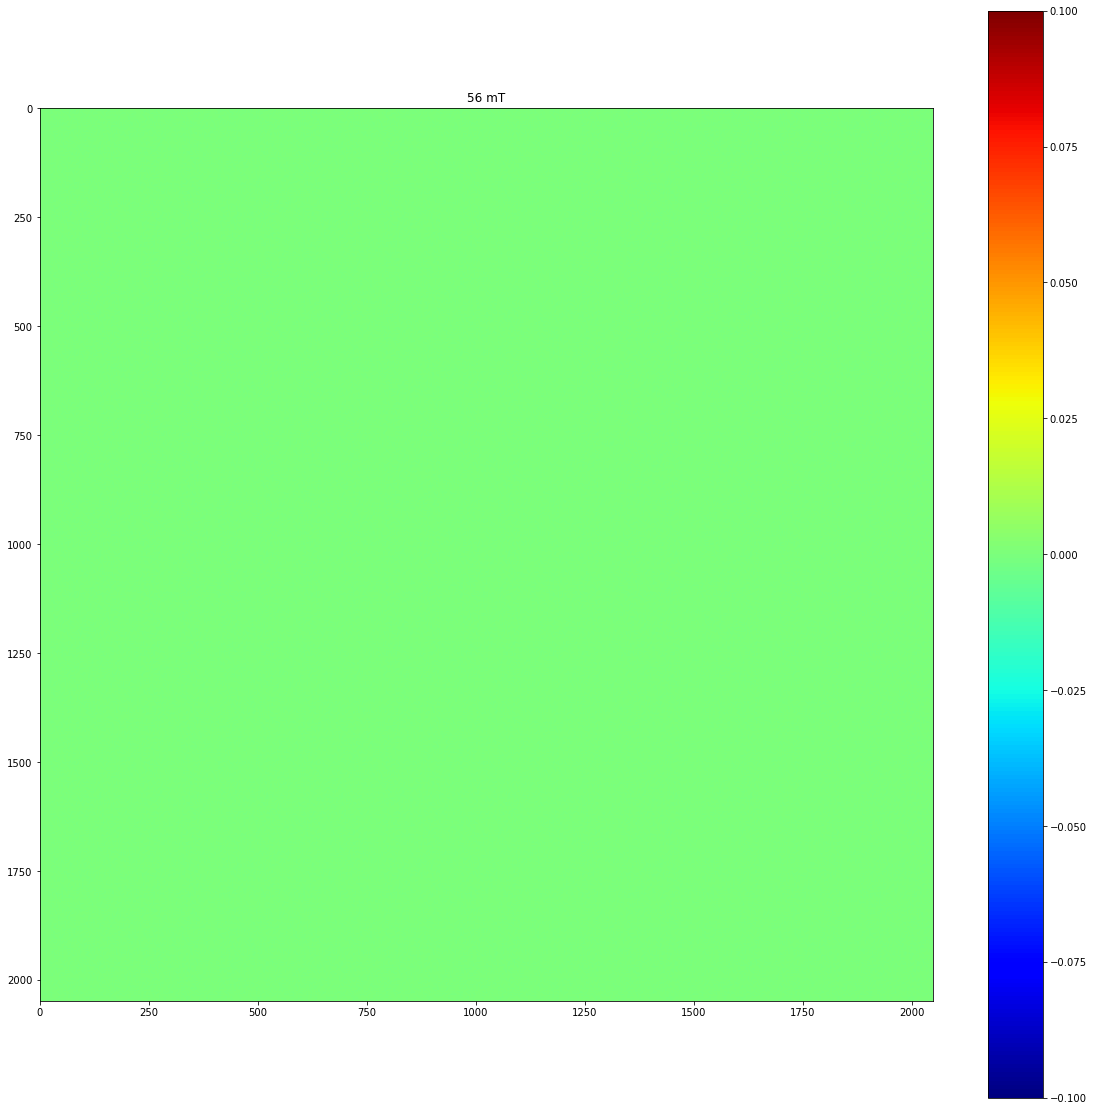

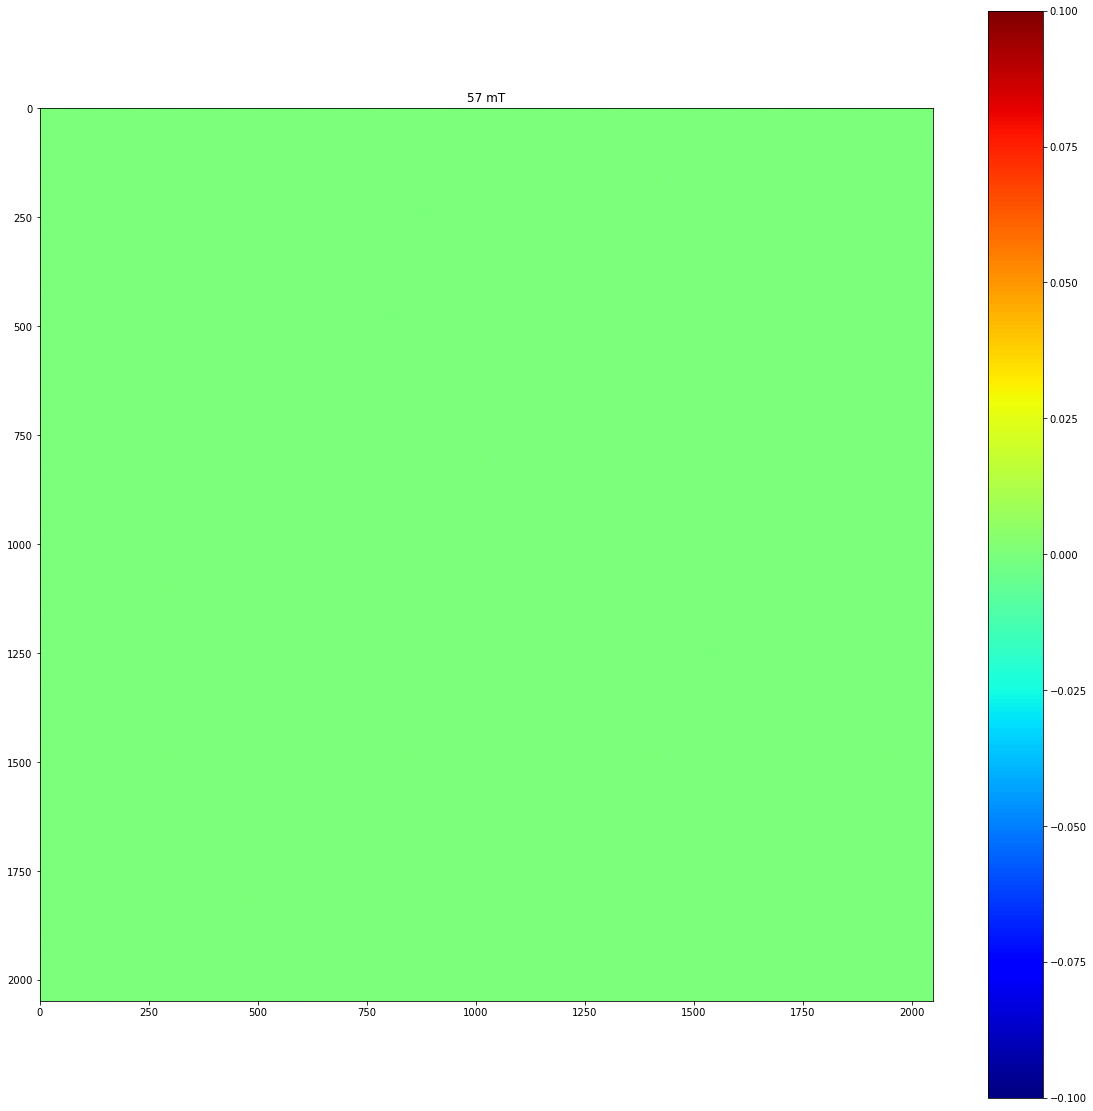

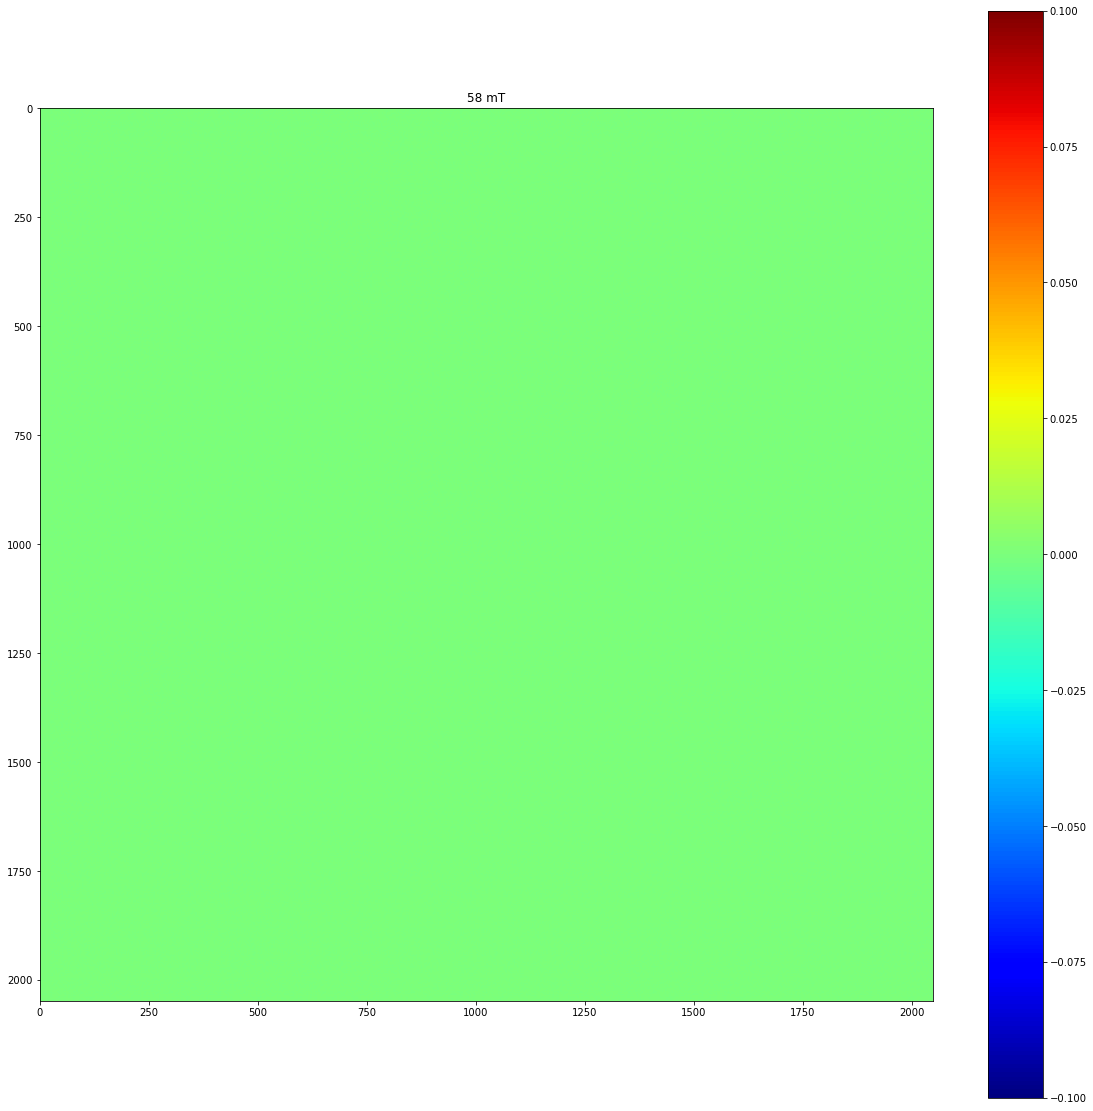

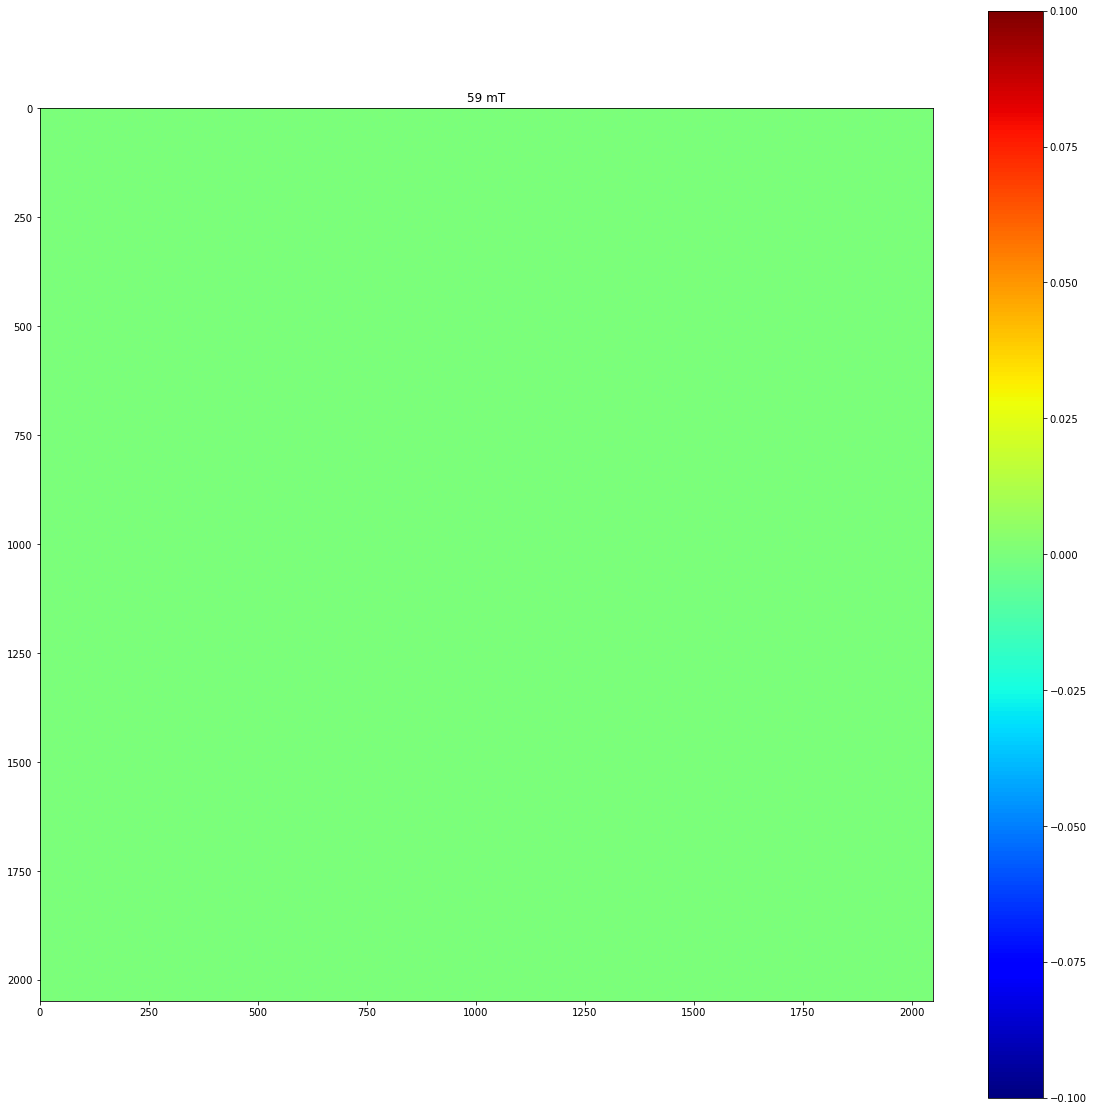

In [36]:
"""
Display the results.
"""
importlib.reload(utils)

for field in range(max_field):
    utils.imshow(bkg_in_clusters_per_field[field], title=f"{field} mT")


In [39]:
"""
Plot wavelength vs field.
"""

import pyFAI

# Run some azimuthal integrations on the data.

# Initialize the integrator.
fai = pyFAI.load(utils.PONI_PATH)


def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))


azimuthal_integrals = []
k_vectors = []
k_vector_errors = []
relative_errors = []

max_working_field = 40
for field in range(max_working_field+1):
    shift = 4000 * field
    azimuthal_integrals.append(
        fai.integrate1d(bkg_in_clusters_per_field[field], 1000))
    if len(clusters_per_field[field]) == 0:
        k_vectors.append(np.nan)
        k_vector_errors.append(np.nan)
        relative_errors.append(np.nan)
        print(field)
    else:
        mean, stddev = weighted_avg_and_std(
            azimuthal_integrals[field][0], azimuthal_integrals[field][1])
        k_vectors.append(mean)
        k_vector_errors.append(stddev)
        relative_errors.append(k_vector_errors[field]/k_vectors[field])
# plt.plot(k_vectors)


<ErrorbarContainer object of 3 artists>

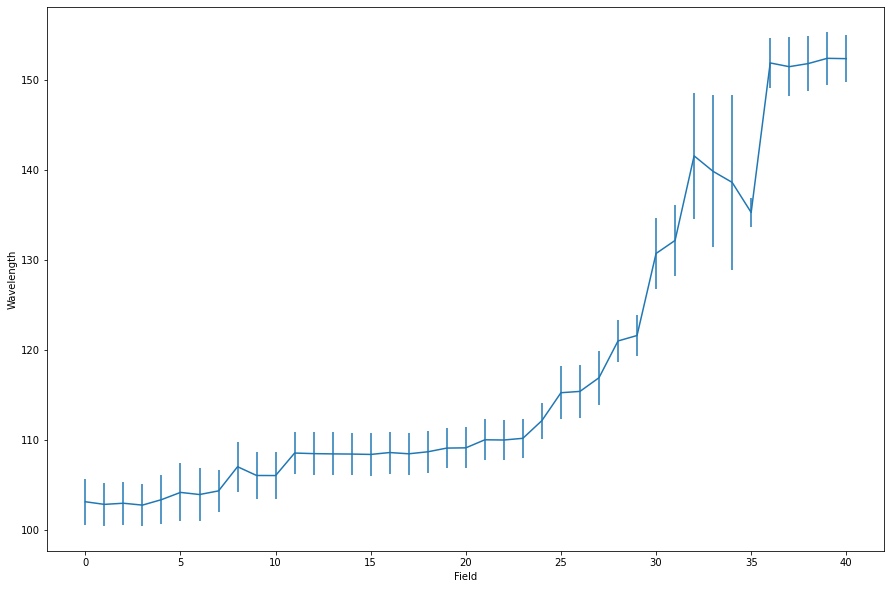

In [40]:
"""
Plot it.
"""

import matplotlib.pyplot as plt

wavelengths = 2*np.pi/np.array(k_vectors)

plt.figure(figsize=(15, 10))
plt.xlabel("Field")
plt.ylabel("Wavelength")
plt.errorbar(range(max_working_field+1), wavelengths, yerr=np.array(
    relative_errors)*wavelengths)
